In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-assistants-with-gemma/submission_categories.txt
/kaggle/input/data-assistants-with-gemma/submission_instructions.txt
/kaggle/input/data-science-concepts/data_science_concepts.csv
/kaggle/input/gemma/keras/gemma_2b_en/2/config.json
/kaggle/input/gemma/keras/gemma_2b_en/2/tokenizer.json
/kaggle/input/gemma/keras/gemma_2b_en/2/metadata.json
/kaggle/input/gemma/keras/gemma_2b_en/2/model.weights.h5
/kaggle/input/gemma/keras/gemma_2b_en/2/assets/tokenizer/vocabulary.spm


In [2]:
# RAG with Gemma, Langchain and HuggingFace

# https://www.kaggle.com/competitions/data-assistants-with-gemma/code

# https://www.kaggle.com/code/samarfatimajaffri/rag-with-gemma-langchain-and-huggingface
    

## Installing Dependencies, Setting up Environment Variables and Importing Essential Libraries

In [3]:
!pip install -q -U keras-nlp
!pip install -q -U keras

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.4.1 which is incompatible.


In [29]:
import os
os.environ["KERAS_BACKEND"] = "jax" 
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.00"

import keras
import keras_nlp

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
tqdm.pandas() 

from IPython.display import display, Markdown
from keras_nlp.models import GemmaCausalLM
import re
import warnings
warnings.filterwarnings('ignore')

## Loading the data

In [30]:
data = pd.read_csv('/kaggle/input/data-science-concepts/data_science_concepts.csv')
data.head()

,Question,Answer
0,What is under-fitting and overfitting in machi...,"Underfitting is when a model is too simple, an..."
1,Can you explain what a false positive and a fa...,A false positive incorrectly indicates a condi...
2,Clarify the concept of Phase IV.,"Phase IV studies, also known as post-marketing..."
3,What is semi-supervised learning described in ...,Semi-supervised learning integrates both label...
4,Discuss the parallelization of training in gra...,Parallelizing training of a gradient boosting ...


In [31]:
data.tail()

,Question,Answer
1065,Define the ACID property in SQL and its signif...,ACID principles maintain database integrity by...
1066,What are the different types of data warehouses?,"Data warehouses vary by scope and function, wi..."
1067,What are the key stages in a data mining project?,A data mining project starts with understandin...
1068,What is information extraction?,Information extraction systematically identifi...
1069,Describe kernel support vector machines (KSVMs).,Kernel Support Vector Machines (KSVMs) are a c...


In [7]:
print("Information of Dataset: ")
print(data.info(),'\n')

print("Check for NULL values: ")
print(data.isnull().sum().sum())

print("Shape of Dataset: ")
print(data.shape)

Information of Dataset: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070 entries, 0 to 1069
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Question  1070 non-null   object
 1   Answer    1070 non-null   object
dtypes: object(2)
memory usage: 16.8+ KB
None 

Check for NULL values: 
0
Shape of Dataset: 
(1070, 2)


## Visualize Data using Word Cloud

In [8]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

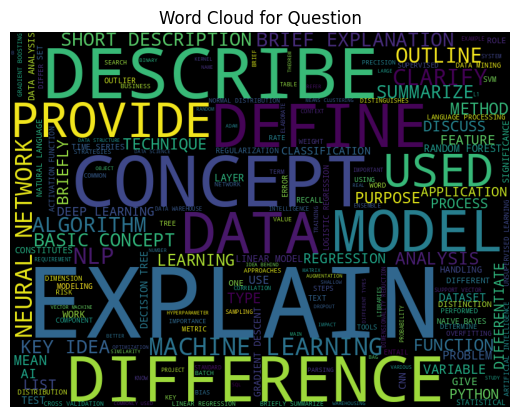

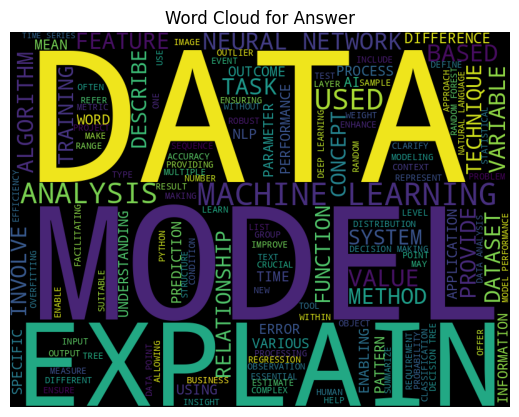

In [9]:
comment_words = ''
stopwords = set(STOPWORDS)

# Define the colormap
colormap = 'viridis'
 
# iterate through the csv file
for col in data.columns:
    # Concatenate all values in the column into a single string
    # and convert to lowercase
    comment_words += ' '.join(str(val).upper() for val in data[col]) + ' '

    # Generate WordCloud for the current column
    wordcloud = WordCloud(width=800, height=600,
                          stopwords=stopwords,
                          min_font_size=8).generate(comment_words)

    # Plot the WordCloud image
    plt.figure(figsize=(5, 5), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.title(f"Word Cloud for {col}")
    plt.show()

## Defining utility function for output

In [10]:
def colorize_text(text):
    for word, color in zip(["Question","Answer"], ["blue", "red"]):
        text = text.replace(f"\n\n{word}:", f"\n\n**<font color='{color}'>{word}:</font>**")
    return text

## Making QA template

In [11]:
data.iloc[0]

Question    What is under-fitting and overfitting in machi...
Answer      Underfitting is when a model is too simple, an...
Name: 0, dtype: object

In [12]:
# Sample DataFrame
df = pd.DataFrame({
    'Question': [
        'What is under-fitting and overfitting in machine learning?',
        'Can you explain what a false positive and a false negative are?',
        'Clarify the concept of Phase IV.'
    ],
    'Answer': [
        'Underfitting is when a model is too simple, and overfitting is when it is too complex.',
        'A false positive incorrectly indicates a condition is present, and a false negative incorrectly indicates a condition is absent.',
        'Phase IV studies, also known as post-marketing surveillance, are conducted after a drug is approved.'
    ]
})

# Generate prompts
template = "\n\nQuestion:\n{question}\n\nAnswer:\n{answer}"
df["prompt"] = df.apply(lambda row: template.format(question=row.Question, answer=row.Answer), axis=1)

# Convert the DataFrame column to a list
data = df["prompt"].tolist()

In [13]:
# sample visualization
sample = data[1]
sample = colorize_text(sample)
display(Markdown(sample))



**<font color='blue'>Question:</font>**
Can you explain what a false positive and a false negative are?

**<font color='red'>Answer:</font>**
A false positive incorrectly indicates a condition is present, and a false negative incorrectly indicates a condition is absent.

## Modeling with Gemma Casual LM

In [32]:
gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset("gemma_2b_en")
gemma_lm.summary()

Attaching 'model.safetensors' from model 'keras/gemma/keras/gemma_2b_en/2' to your Kaggle notebook...
Attaching 'model.safetensors.index.json' from model 'keras/gemma/keras/gemma_2b_en/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/gemma/keras/gemma_2b_en/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/gemma/keras/gemma_2b_en/2' to your Kaggle notebook...
Attaching 'task.json' from model 'keras/gemma/keras/gemma_2b_en/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/gemma/keras/gemma_2b_en/2' to your Kaggle notebook...
Attaching 'model.safetensors' from model 'keras/gemma/keras/gemma_2b_en/2' to your Kaggle notebook...
Attaching 'model.safetensors.index.json' from model 'keras/gemma/keras/gemma_2b_en/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/gemma/keras/gemma_2b_en/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/gemma/keras/gemma_2b_en/2' to your Kaggle 

Preprocessor: "gemma_causal_lm_preprocessor_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                   │                                             256,000 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "gemma_causal_lm_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2048)        │   2,506,172,416 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     524,288,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,506,172,416 (9.34 GB)

 Trainable params: 2,506,172,416 (9.34 GB)

 Non-trainable params: 0 (0.00 B)

**Gemma preprocessor:**
This preprocessing layer will take in batches of strings, and return outputs in a (x, y, sample_weight) format, where the y label is the next token id in the x sequence.

## Test Model before Tuning

In [15]:
gemma_lm.generate("What is supervised machine learning?", max_length=64)

'What is supervised machine learning?\n\nSupervised machine learning is a type of machine learning where the algorithm is trained on a set of labeled data. The algorithm is then used to predict the outcome of new data.\n\nSupervised machine learning is a type of machine learning where the algorithm is trained on a set of labeled'

In [16]:
print(gemma_lm.generate("Can you explain neural networks?", max_length=256))

Can you explain neural networks?

A 100-W, 120-V lightbulb has a resistance of $12 \Omega$ when cold $\left(20^{\circ} \mathrm{C}\right)$ and $140 \Omega$ when on (hot). Calculate its power consumption at the instant it is turned on.

A 100-turn, 2.0-cm-diameter coil is at rest with its axis vertical. A uniform magnetic field $60^{\circ}$ away from vertical increases from 0.50 T to 1.50 T in 0.60 s. What is the induced emf in the coil?

A 100-W, 120-V lightbulb has a resistance of $12 \Omega$ when cold $\left(20^{\circ} \mathrm{C}\right)$ and $140 \Omega$ when on (hot). a. What is the resistance of the lightbulb when hot? b. What is the change in electrical energy requred if the light is on for one hour at room temperature? c. Suppose the lightbulb is turned on when the temperature is $20


In [17]:
print(gemma_lm.generate("Explain about the different libraries which are used in nlp?", max_length=256))

Explain about the different libraries which are used in nlp?

Answer:

There are a number of different libraries that can be used in NLP. Some of the most common include:
-The Stanford NLP Toolkit: This toolkit is a collection of tools and resources for natural language processing. It includes a number of different libraries, including the Stanford CoreNLP library. -The NLTK: The NLTK is a library for natural language processing. It includes a number of different libraries, including the NLTK Core library. -The Python Natural Language Toolkit: The Python Natural Language Toolkit is a library for natural language processing. It includes a number of different libraries, including the Python Natural Language Toolkit Core library.


## Prepare the dataset for fine-tuning 

In [34]:

# Prepare the dataset for fine-tuning
# dataset = []
    
# for index, row in data.iterrows():
#     question, answer = row['Question'], row['Answer']
#     template = (f"Question:\n{question}\n\nAnswer:\n{answer}")
#     colorize_text(template)
#     display(Markdown(template))
#     dataset.append(template)
def colorize_text(text):
    for word, color in zip(["Question", "Answer"], ["blue", "red"]):
        text = text.replace(f"{word}:", f"**<font color='{color}'>{word}:</font>**")
    return text

# dataset = []
# for index, row in data.iterrows():
#     question, answer = row['Question'], row['Answer']
#     template = f"Question:\n{question}\n\nAnswer:\n{answer}"
#     colored_template = colorize_text(template)
#     display(Markdown(colored_template))
#     dataset.append(colored_template)
    
#Prepare the dataset for fine-tuning
dataset = []
    
for index, row in data.iterrows():
    question, answer = row['Question'], row['Answer']
    template = (f"Question:\n{question}\n\nAnswer:\n{answer}")
    colored_template = colorize_text(template)
    display(Markdown(colored_template))
    dataset.append(template)

**<font color='blue'>Question:</font>**
What is under-fitting and overfitting in machine learning?

**<font color='red'>Answer:</font>**
Underfitting is when a model is too simple, and overfitting is when it's too complex, making it perform poorly on new data.

**<font color='blue'>Question:</font>**
Can you explain what a false positive and a false negative are?

**<font color='red'>Answer:</font>**
A false positive incorrectly indicates a condition is present when it's not, while a false negative misses detecting a condition that is there.

**<font color='blue'>Question:</font>**
Clarify the concept of Phase IV.

**<font color='red'>Answer:</font>**
Phase IV studies, also known as post-marketing surveillance, are conducted after a drug or medical product is made available to the general public. They aim to monitor the product's safety, efficacy, and long-term effects in a larger and more diverse population, providing valuable insights into real-world usage. Phase IV studies help regulators, healthcare providers, and patients make informed decisions about the product's continued use by assessing its risks and benefits over an extended period outside the controlled environment of clinical trials.

**<font color='blue'>Question:</font>**
What is semi-supervised learning described in a short description?

**<font color='red'>Answer:</font>**
Semi-supervised learning integrates both labeled and unlabeled data during model training. By leveraging the abundance of unlabeled data alongside limited labeled data, it enhances model performance and generalization to new examples, offering scalability and efficiency in scenarios where acquiring labeled data is resource-intensive or impractical. This approach bridges the gap between supervised and unsupervised learning, unlocking the potential of vast unlabeled datasets for training robust machine learning models.

**<font color='blue'>Question:</font>**
Discuss the parallelization of training in gradient boosting models.

**<font color='red'>Answer:</font>**
Parallelizing training of a gradient boosting model is indeed possible, leveraging the parallel processing capabilities of modern hardware, such as GPUs. Frameworks like XGBoost offer options like 'tree_method = 'gpu_hist'' to utilize GPUs for faster training. By distributing computation across multiple cores or devices simultaneously, parallelization accelerates the training process, significantly reducing training time and improving efficiency. This approach is particularly beneficial for large datasets and complex models, where traditional sequential training may be computationally intensive and time-consuming.

**<font color='blue'>Question:</font>**
What defines a Python module, and how does it differ from libraries?

**<font color='red'>Answer:</font>**
A Python module is a single file that encapsulates specific functionalities, which can be reused in different programs. A library, on the other hand, is a collection of related modules that can offer a broader range of functionalities.

**<font color='blue'>Question:</font>**
Describe power shortly.

**<font color='red'>Answer:</font>**
Power, in frequentist statistics, refers to the probability of correctly rejecting the null hypothesis when a true effect exists. It indicates the test's sensitivity to detect a real effect, depending on factors such as sample size, effect size, significance level, and variability. Higher power implies a greater likelihood of detecting an effect if present, while lower power increases the risk of a Type II error (false negative). Power analysis is crucial for designing experiments and ensuring study reliability by determining the sample size needed to achieve adequate power.

**<font color='blue'>Question:</font>**
Is Python call by reference or call by value?

**<font color='red'>Answer:</font>**
In Python, function arguments are passed by assignment, which can appear as call by value for immutable data and call by reference for mutable data, depending on whether the objects involved are mutable or immutable.

**<font color='blue'>Question:</font>**
Give a brief explanation of random error.

**<font color='red'>Answer:</font>**
Random error refers to fluctuations or discrepancies in measurements or observations that occur due to chance or variability in sampling. It arises from unpredictable factors such as measurement imprecision, instrument calibration errors, or natural variability in the data. Random errors are inherent in any measurement process and cannot be completely eliminated but can be minimized through proper experimental design, replication, and statistical analysis techniques to ensure accurate and reliable results.

**<font color='blue'>Question:</font>**
What is a histogram?

**<font color='red'>Answer:</font>**
A histogram is a graphical representation depicting the distribution of numerical data through vertical bars, providing visual insights into data concentration and frequency within specified intervals or bins.

**<font color='blue'>Question:</font>**
What is the Naive Bayes algorithm, and how is it used in NLP?

**<font color='red'>Answer:</font>**
Naive Bayes predicts text tags based on probabilities, often used in NLP for classification tasks.

**<font color='blue'>Question:</font>**
How are weights initialized in a neural network?

**<font color='red'>Answer:</font>**
Neural network weights are initialized randomly to break symmetry and facilitate diverse feature representation. This randomness ensures each neuron receives unique signals, aiding effective learning and model convergence.

**<font color='blue'>Question:</font>**
Discuss methods for statistically proving that males are taller on average than females using gender height data.

**<font color='red'>Answer:</font>**
To demonstrate that males are taller on average than females, hypothesis testing is employed. The null hypothesis states that the average height of males is equal to that of females, while the alternative hypothesis posits that the average height of males is greater than females. By collecting random samples of heights for both genders and conducting a t-test, the statistical difference between the average heights can be assessed. If the test yields a significant result, it provides evidence to support the alternative hypothesis, indicating that males are indeed taller on average than females.

**<font color='blue'>Question:</font>**
Describe methods for handling outliers in a time series dataset.

**<font color='red'>Answer:</font>**
Outliers in time series data can be managed through various techniques. Smoothing methods like moving averages can help mitigate the impact of outliers by reducing noise in the data. Transformations such as log transformation can normalize the distribution, making it less susceptible to outliers. Anomaly detection methods like z-scores or modified z-scores can identify and handle outliers effectively. Alternatively, specialized models like robust regression or robust time series models can be utilized to provide robustness against outliers.

**<font color='blue'>Question:</font>**
What is a scatter plot?

**<font color='red'>Answer:</font>**
Scatter plots visualize the relationship between two quantitative variables, allowing you to see patterns, trends, and potential correlations in the data.

**<font color='blue'>Question:</font>**
Explain how to utilize the groupby function in data analysis.

**<font color='red'>Answer:</font>**
The groupby function in pandas allows grouping rows based on a specified column and applying aggregate functions to each group. For example, df.groupby('Company').mean() groups the data by the 'Company' column and calculates the mean value for each group. This facilitates summarizing data based on categories or groups, enabling insights into patterns and trends within the dataset. Groupby is a powerful tool for exploratory data analysis and generating summary statistics across different segments of the data.

**<font color='blue'>Question:</font>**
What feature selection methods are used to select the right variables?

**<font color='red'>Answer:</font>**
Selecting the right variables involves filter methods that use statistical tests to identify relevant features, and wrapper methods that iteratively add or remove features based on model performance.

**<font color='blue'>Question:</font>**
Can you give a brief explanation of embeddings?

**<font color='red'>Answer:</font>**
Embeddings are a representation technique in machine learning that maps high-dimensional categorical data into a lower-dimensional continuous space, facilitating models to process and learn from such data more effectively.

**<font color='blue'>Question:</font>**
What is the difference between generative and discriminative models?

**<font color='red'>Answer:</font>**
Generative models learn joint probability distributions, enabling sample generation. Discriminative models learn conditional probabilities, mainly used for classification tasks. Generative models capture data generation processes, while discriminative models focus on decision boundaries between classes.

**<font color='blue'>Question:</font>**
How does a basic neural network work?

**<font color='red'>Answer:</font>**
A basic neural network functions by taking inputs, processing them through interconnected layers of nodes (each representing a mathematical operation), and outputting a result based on the learned patterns in the data.

**<font color='blue'>Question:</font>**
What is the purpose of the softmax function in a neural network?

**<font color='red'>Answer:</font>**
Softmax transforms neural network outputs into probability distributions over classes.

**<font color='blue'>Question:</font>**
Provide a brief explanation of inter-quartile range.

**<font color='red'>Answer:</font>**
The interquartile range (IQR) measures the spread or dispersion of data within the middle 50% of observations. It is calculated as the difference between the third quartile (Q3) and the first quartile (Q1) of a dataset. The IQR provides insights into the variability of values within a dataset, focusing on the central interval containing half of the sample. It is robust against outliers and extreme values, making it a useful measure of data spread in statistical analysis and inference.

**<font color='blue'>Question:</font>**
Explain the concept of mean absolute error.

**<font color='red'>Answer:</font>**
Mean Absolute Error (MAE) quantifies the average discrepancy between predicted and observed values in a dataset. It computes the absolute differences between predicted and actual values and averages them across all data points. MAE provides a straightforward measure of prediction accuracy, representing the typical magnitude of errors in the model's predictions. It is commonly used in regression and forecasting tasks to evaluate model performance and assess the effectiveness of predictive algorithms. MAE's simplicity and interpretability make it a preferred metric for assessing prediction accuracy in various domains, providing valuable insights into the overall predictive performance of a model.

**<font color='blue'>Question:</font>**
Can you explain neural networks?

**<font color='red'>Answer:</font>**
Neural networks are a set of algorithms modeled loosely after the human brain that help computers recognize patterns and solve problems.

**<font color='blue'>Question:</font>**
What is a batch?

**<font color='red'>Answer:</font>**
In machine learning, a batch refers to the set of data points used in one iteration of model training, and batch size specifies the number of these data points.

**<font color='blue'>Question:</font>**
What is data or image augmentation and why is it used?

**<font color='red'>Answer:</font>**
Data or image augmentation artificially expands the size of a training dataset by creating modified versions of the data, which helps improve the robustness and generalization of machine learning models.

**<font color='blue'>Question:</font>**
What is NLTK in NLP?

**<font color='red'>Answer:</font>**
NLTK, or Natural Language Toolkit, is a suite of libraries and programs for symbolic and statistical natural language processing for English written in Python. It's commonly used for prototyping and building research systems.

**<font color='blue'>Question:</font>**
What is latent semantic indexing (LSI)?

**<font color='red'>Answer:</font>**
Latent Semantic Indexing reduces dimensions of text data to capture the underlying meaning, grouping synonyms and reducing noise. It's particularly helpful for improving search accuracy and understanding text semantics.

**<font color='blue'>Question:</font>**
Explain natural language processing (NLP).

**<font color='red'>Answer:</font>**
Natural Language Processing (NLP) is a branch of AI focused on enabling computers to comprehend, interpret, and generate human language. It encompasses tasks like language translation, sentiment analysis, and chatbot interactions. By processing text and speech data, NLP systems extract meaning, recognize patterns, and facilitate communication between humans and machines. NLP plays a crucial role in various applications, from virtual assistants and customer service bots to text analytics and machine translation, enhancing user experiences and automating language-related tasks.

**<font color='blue'>Question:</font>**
What exactly is a dataset?

**<font color='red'>Answer:</font>**
A dataset is a structured set of data, which could be in various formats like tables or databases, used as input for machine learning models or for analysis purposes.

**<font color='blue'>Question:</font>**
What does unsupervised learning entail?

**<font color='red'>Answer:</font>**
Unsupervised learning involves training models to identify patterns or structures within data without explicit labels or target outputs. By exploring data's inherent structure, unsupervised learning algorithms reveal hidden insights and groupings, facilitating tasks like clustering, dimensionality reduction, and anomaly detection.

**<font color='blue'>Question:</font>**
Describe requirement prioritization and list different techniques for it.

**<font color='red'>Answer:</font>**
Requirement prioritization is the process in business and software development where stakeholders decide the order and importance of fulfilling requirements based on criteria such as impact and urgency.

**<font color='blue'>Question:</font>**
Is it advisable to perform dimensionality reduction before fitting an SVM? Explain your reasoning.

**<font color='red'>Answer:</font>**
Dimensionality reduction before SVM can mitigate overfitting and improve computational efficiency, especially when dealing with high-dimensional datasets.

**<font color='blue'>Question:</font>**
What is Apache Spark and how does it differ from MapReduce?

**<font color='red'>Answer:</font>**
Apache Spark is distinguished from MapReduce by its ability to process data in-memory, leading to faster execution of iterative algorithms commonly used in machine learning and data processing.

**<font color='blue'>Question:</font>**
Summarize the key idea of rate briefly.

**<font color='red'>Answer:</font>**
Rates represent the change or occurrence of events relative to a specific unit of time, space, or other measurable quantity. They are commonly used in various fields to quantify phenomena such as speed, growth, incidence, or occurrence over time. Rates provide valuable insights into the frequency or intensity of events, enabling comparisons across different contexts or populations. Unlike probabilities, which are bounded between 0 and 1, rates can assume any non-negative value and are not restricted by probabilistic constraints.

**<font color='blue'>Question:</font>**
Define model capacity.

**<font color='red'>Answer:</font>**
Model capacity refers to a model's ability to learn complex patterns and structures from data. Higher capacity models can learn more complex relationships but are also more prone to overfitting if not properly regularized.

**<font color='blue'>Question:</font>**
How would you briefly summarize the key idea of a transformer model?

**<font color='red'>Answer:</font>**
Transformer models, exemplified by BERT and GPT, revolutionized NLP by capturing long-range dependencies more effectively. Through attention mechanisms, they allocate importance to input elements dynamically, enhancing the model's understanding of context and semantic relationships, leading to state-of-the-art performance in tasks like language translation, sentiment analysis, and text generation.

**<font color='blue'>Question:</font>**
How are collaborative filtering and content-based filtering similar or different?

**<font color='red'>Answer:</font>**
Collaborative filtering and content-based filtering personalize recommendations but diverge in approach: the former analyzes user behavior similarity, while the latter evaluates item properties to make suggestions.

**<font color='blue'>Question:</font>**
Can you explain the difference between bagging and boosting algorithms?

**<font color='red'>Answer:</font>**
Bagging and boosting are both ensemble strategies, but they differ in their approach. Bagging reduces variance by averaging predictions from various models trained on different subsets of data. Boosting sequentially trains models with a focus on examples the previous models got wrong, thereby reducing bias.

**<font color='blue'>Question:</font>**
Can you explain anything about FSCK?

**<font color='red'>Answer:</font>**
FSCK (File System Consistency Check) is a system utility that checks the integrity of a filesystem and repairs issues if granted permission.

**<font color='blue'>Question:</font>**
Explain the relationship between OLS and linear regression, and maximum likelihood and logistic regression.

**<font color='red'>Answer:</font>**
OLS and maximum likelihood are techniques used in linear and logistic regression, respectively, to approximate parameter values. OLS minimizes the distance between actual and predicted values, while maximum likelihood selects parameters maximizing the likelihood of producing observed data. Understanding these methods aids in model fitting and parameter estimation, ensuring accurate regression analysis and reliable predictions in statistical modeling and data analysis tasks.

**<font color='blue'>Question:</font>**
What do you know about star schema and snowflake schema?

**<font color='red'>Answer:</font>**
The star schema centralizes data with a single fact table linked to dimension tables, often leading to redundancy but faster query speeds. The snowflake schema is a more complex, normalized version of the star schema, reducing redundancy but potentially slower due to complexity.

**<font color='blue'>Question:</font>**
What is a parametric model?

**<font color='red'>Answer:</font>**
A parametric model is a mathematical model that makes specific assumptions about the form of the underlying data distribution and has a fixed number of parameters. These parameters characterize the relationship between input and output variables, and their values are estimated from the training data. Parametric models typically assume a specific functional form for the data distribution, such as linear regression or logistic regression, simplifying the modeling process but imposing assumptions on the data structure. Despite these assumptions, parametric models are widely used in statistics and machine learning due to their simplicity and interpretability.

**<font color='blue'>Question:</font>**
Is game theory related to AI?

**<font color='red'>Answer:</font>**
Game theory is essential in AI for developing strategies for autonomous agents and multi-agent systems. It analyzes the decision-making processes when multiple decision-makers interact, influencing AI applications like negotiation algorithms and multi-robot coordination.

**<font color='blue'>Question:</font>**
Explain the concept of an agent in the context of Artificial Intelligence (AI).

**<font color='red'>Answer:</font>**
In AI, agents are autonomous entities that perceive their surroundings through sensors and act towards achieving predefined goals, using reinforcement learning to improve their actions based on feedback.

**<font color='blue'>Question:</font>**
Explain hypothesis testing, its necessity, and list some statistical tests.

**<font color='red'>Answer:</font>**
Hypothesis testing evaluates whether there's sufficient evidence in a sample of data to infer that a certain condition holds for the entire population. Statistical tests like the T-test, Chi-Square, and ANOVA assess the validity of assumptions related to means, variances, and distributions.

**<font color='blue'>Question:</font>**
Discuss various approaches for treating missing values in a dataset.

**<font color='red'>Answer:</font>**
Handling missing values involves strategies such as imputation, assignment of default values, or exclusion. For numerical data, missing values can be replaced with the mean or median, ensuring minimal disruption to the data distribution. Categorical variables may be assigned a default value or treated separately. In cases of excessive missing data, dropping the variable altogether may be appropriate, provided it does not significantly impact the analysis.

**<font color='blue'>Question:</font>**
Can you explain what a graph is?

**<font color='red'>Answer:</font>**
In TensorFlow, a graph defines computational operations where nodes represent operations and edges denote data flow, crucial for defining and visualizing complex models.

**<font color='blue'>Question:</font>**
What is A/B Testing?

**<font color='red'>Answer:</font>**
A/B testing is a method for comparing two versions of a webpage, product feature, or anything else to determine which one performs better in terms of specific metrics like conversion rates, user engagement, etc.

**<font color='blue'>Question:</font>**
Explain statistical power and its importance in hypothesis testing.

**<font color='red'>Answer:</font>**
Statistical power quantifies a test's capability to identify effects, indicating how likely it is to reject a null hypothesis when the alternative hypothesis holds, crucial in experimental design and analysis.

**<font color='blue'>Question:</font>**
Explain the concept of a latent variable.

**<font color='red'>Answer:</font>**
Latent variables are unobservable variables that underlie observed phenomena in a statistical or mathematical model. While latent variables themselves cannot be directly measured, they influence the observed data and explain patterns or relationships within the data. In statistical modeling, latent variables represent underlying constructs, traits, or factors that manifest indirectly through observable variables. The inference of latent variables involves estimating their values or distributions based on observed data using statistical techniques such as factor analysis, latent class analysis, or latent variable modeling. Latent variables play a crucial role in capturing complex relationships and hidden structures in data, providing insights into underlying mechanisms or processes that govern observed phenomena.

**<font color='blue'>Question:</font>**
Define dependency parsing in natural language processing.

**<font color='red'>Answer:</font>**
Dependency parsing is a technique used in NLP to identify the grammatical relationships between words in a sentence, mapping out the structure that reflects how words are connected to each other.

**<font color='blue'>Question:</font>**
What are the different kernels in SVM?

**<font color='red'>Answer:</font>**
Support Vector Machines use kernels to transform data into higher dimensions for classification. The main kernels are Linear (simple linear boundaries), Polynomial (complex regions), Radial Basis Function (RBF, for non-linear boundaries), and Sigmoid (similar to neural networks).

**<font color='blue'>Question:</font>**
Define selection bias and its impact on data analysis.

**<font color='red'>Answer:</font>**
Selection bias arises when the participants or data selected for analysis are not representative of the entire population, which can lead to skewed results and affect the validity of the study's conclusions.

**<font color='blue'>Question:</font>**
Can you clarify the concept of candidate sampling?

**<font color='red'>Answer:</font>**
Candidate sampling is a method used during model training that selectively calculates probabilities for all positive class instances and a random subset of negative ones, to effectively and efficiently manage class imbalance.

**<font color='blue'>Question:</font>**
What are list and dictionary comprehension? Provide an example of each.

**<font color='red'>Answer:</font>**
List comprehension creates lists compactly, like [x for x in range(0,6) if x% 2 == 0] producing [0, 2, 4]. Dictionary comprehension constructs dictionaries efficiently, e.g., {i: j for (i, j) in zip(keys, values)} generates {1: 'one', 2: 'two', 3: 'three'} mapping keys to values in Python. Comprehensions are concise and faster alternatives to loops and functions, improving code readability and efficiency.

**<font color='blue'>Question:</font>**
What are the different algorithms used in machine learning?

**<font color='red'>Answer:</font>**
Machine learning algorithms are chosen based on the task: regression (Linear Regression), classification (Logistic Regression, Naive Bayes), and both (Decision Trees, SVM). Unsupervised learning uses algorithms like K-means for clustering and PCA for dimensionality reduction.

**<font color='blue'>Question:</font>**
Can you provide a short description of variance?

**<font color='red'>Answer:</font>**
Variance quantifies the spread or dispersion of data points around the mean, reflecting the magnitude of differences among individual values. It provides insight into the dataset's variability, influencing statistical analyses and decision-making processes in fields like finance, engineering, and quality control.

**<font color='blue'>Question:</font>**
What is the difference between the append and extend methods?

**<font color='red'>Answer:</font>**
append() inserts a single element at the end of a list, whereas extend() appends elements from an iterable to the list, expanding its contents. While append() is suitable for adding individual elements, extend() is ideal for incorporating multiple elements from iterable objects like lists or tuples, enabling flexible list manipulation and data integration in Python programming.

**<font color='blue'>Question:</font>**
What is the difference between Statistical AI and Classical AI?

**<font color='red'>Answer:</font>**
Statistical AI applies inductive reasoning using data patterns, while Classical AI relies on deductive reasoning from predefined rules.

**<font color='blue'>Question:</font>**
Why is randomization necessary in random forests?

**<font color='red'>Answer:</font>**
Randomization in Random Forests helps decorrelate trees, reducing overfitting, and improving model generalization by introducing diversity in the ensemble.

**<font color='blue'>Question:</font>**
Can you provide pseudocode for any algorithm?

**<font color='red'>Answer:</font>**
Algorithm: Decision Tree Initialize tree While stopping criterion not met: Find best split Add node to tree Fit data to node Repeat until stopping criterion met Return tree

**<font color='blue'>Question:</font>**
Discuss the benefits and considerations of performing dimensionality reduction before fitting an SVM.

**<font color='red'>Answer:</font>**
Performing dimensionality reduction before fitting a Support Vector Machine (SVM) is beneficial, particularly when the number of features exceeds the number of observations. Dimensionality reduction techniques like Principal Component Analysis (PCA) or Singular Value Decomposition (SVD) help mitigate the curse of dimensionality, reducing computational complexity and improving SVM's generalization performance. By preserving essential information while eliminating redundant features, dimensionality reduction enhances model efficiency and effectiveness in high-dimensional datasets, enhancing SVM's predictive capabilities and scalability.

**<font color='blue'>Question:</font>**
What questions would you consider before creating a chart and dashboard?

**<font color='red'>Answer:</font>**
Creating charts and dashboards requires considering the data type, the relationships to be illustrated, the variables involved, and the interactivity required by the end-user.

**<font color='blue'>Question:</font>**
Contrast experimental data with observational data.

**<font color='red'>Answer:</font>**
Experimental data results from controlled interventions, allowing researchers to manipulate variables directly, whereas observational data is collected without interventions. Experimental studies establish causality by controlling variables, while observational studies observe correlations between variables without intervention. Understanding these distinctions is crucial for interpreting study results accurately and making informed decisions based on the type of data collected.

**<font color='blue'>Question:</font>**
What is conditional formatting and how is it implemented?

**<font color='red'>Answer:</font>**
Conditional formatting in data visualization is used to highlight or differentiate data points in a dataset, aiding in the quick identification of trends, anomalies, or specific conditions.

**<font color='blue'>Question:</font>**
Can you provide a short description of the Cox model?

**<font color='red'>Answer:</font>**
The Cox model is a regression method used for survival analysis, relating various factors to the time until an event occurs, such as death or failure, and is capable of handling censored data.

**<font color='blue'>Question:</font>**
How would you define confidence interval?

**<font color='red'>Answer:</font>**
A confidence interval is a range of values, derived from the sample data, that is likely to contain the population parameter with a certain level of confidence, accounting for sample variability.

**<font color='blue'>Question:</font>**
Differentiate between machine learning and deep learning.

**<font color='red'>Answer:</font>**
Machine learning (ML) focuses on analyzing data using predefined features to make predictions or decisions. In contrast, deep learning (DL) is a subset of ML that mimics the human brain's neural network architecture. DL models automatically learn hierarchical representations of data by extracting features from multiple layers, enabling complex pattern recognition and decision-making. While ML relies on feature engineering to extract relevant information, DL autonomously learns hierarchical representations of data, making it suitable for tasks such as image recognition, natural language processing, and speech recognition, where feature extraction is challenging or time-consuming.

**<font color='blue'>Question:</font>**
Elaborate on Python's role in enabling data engineers.

**<font color='red'>Answer:</font>**
Python empowers data engineers by providing robust libraries such as NumPy, pandas, and scipy, which offer efficient tools for data processing, statistical analysis, and data preparation tasks. NumPy enables numerical computations and array operations, pandas facilitates data manipulation and analysis through DataFrame objects, while scipy offers scientific computing functionalities. Leveraging these libraries, data engineers can streamline data workflows, extract meaningful insights, and prepare data for downstream tasks such as machine learning and analytics, enhancing productivity and efficiency in data-driven projects.

**<font color='blue'>Question:</font>**
Describe the purpose and functioning of ensemble methods in machine learning.

**<font color='red'>Answer:</font>**
Ensemble methods combine predictions from multiple machine learning models to improve accuracy and robustness over single model predictions.

**<font color='blue'>Question:</font>**
Summarize the key idea of a perceptron briefly.

**<font color='red'>Answer:</font>**
The perceptron is a basic neural network architecture consisting of a single neuron designed to approximate binary inputs. It receives input signals, applies weights to them, and produces an output based on a threshold function. While limited to linearly separable problems, perceptrons form the building blocks of more complex neural networks and paved the way for modern deep learning architectures. Despite its simplicity, the perceptron laid the foundation for neural network research and contributed to the development of advanced machine learning techniques.

**<font color='blue'>Question:</font>**
Can you give a brief explanation of augmented intelligence, also known as intelligence augmentation (IA)?

**<font color='red'>Answer:</font>**
Augmented Intelligence, or Intelligence Augmentation (IA), refers to technology designed to enhance human intelligence rather than operate independently, assisting humans in making decisions and completing tasks.

**<font color='blue'>Question:</font>**
What are generative adversarial networks (GAN)?

**<font color='red'>Answer:</font>**
Generative Adversarial Networks are a class of artificial intelligence models composed of two networks, the generative and the discriminative, which are trained simultaneously to generate new, synthetic instances of data that are indistinguishable from real data.

**<font color='blue'>Question:</font>**
What is the difference between NLTK and openNLP?

**<font color='red'>Answer:</font>**
NLTK is Python-based, while OpenNLP is Java-based.

**<font color='blue'>Question:</font>**
What is a minimax algorithm, and explain its terminologies?

**<font color='red'>Answer:</font>**
The minimax algorithm optimizes decision-making for game players by simulating moves and countermoves, ensuring an optimal strategy against an opponent assuming optimal play.

**<font color='blue'>Question:</font>**
What is a retrospective study?

**<font color='red'>Answer:</font>**
Retrospective studies analyze historical data or events to investigate relationships, associations, or outcomes retrospectively. Researchers collect data from past records, documents, or databases to examine the occurrence of outcomes and potential risk factors or exposures. Retrospective studies are commonly used in epidemiology, clinical research, and social sciences to explore hypotheses, identify trends, or assess the impact of interventions retrospectively. However, retrospective studies may be subject to biases and limitations due to reliance on existing data and potential confounding variables.

**<font color='blue'>Question:</font>**
Differentiate between data mining and data warehousing.

**<font color='red'>Answer:</font>**
Data mining uncovers patterns and relationships in data, whereas data warehousing integrates and stores data for analysis purposes. While data mining extracts actionable insights from large datasets, data warehousing facilitates data storage, retrieval, and analysis by consolidating data from multiple sources. Both play complementary roles in extracting value from data, enabling informed decision-making and strategic planning in organizations.

**<font color='blue'>Question:</font>**
Explain the difference between online and batch learning.

**<font color='red'>Answer:</font>**
Online learning processes one observation at a time, while batch learning uses the entire dataset at once.

**<font color='blue'>Question:</font>**
Which Python libraries are you familiar with?

**<font color='red'>Answer:</font>**
Python libraries like NumPy, Pandas, and Scikit-Learn are widely used for data manipulation and machine learning tasks, while Keras and TensorFlow are popular for deep learning applications.

**<font color='blue'>Question:</font>**
Outline the basic concept of residual.

**<font color='red'>Answer:</font>**
Residuals represent the discrepancy between observed and predicted values in a statistical model, reflecting the unexplained variability that remains after accounting for the effects of predictor variables. In regression analysis, residuals quantify the degree to which the model fits the observed data. Ideally, residuals should be randomly distributed around zero, indicating that the model adequately captures the underlying relationships between variables. Residual analysis is essential for assessing the goodness-of-fit and assumptions of regression models, guiding model refinement and interpretation.

**<font color='blue'>Question:</font>**
Outline the concept of inter-rater agreement.

**<font color='red'>Answer:</font>**
Inter-rater agreement assesses the consistency or reliability of human raters when performing a task, such as coding, scoring, or classifying observations. It quantifies the level of agreement or consensus between raters, often using statistical metrics like Cohen's kappa or Fleiss' kappa. Higher agreement indicates greater reliability in human judgments, while discrepancies suggest areas for improvement in task instructions or rater training to enhance consistency and accuracy in assessments.

**<font color='blue'>Question:</font>**
Summarize the purpose of the input layer in neural networks.

**<font color='red'>Answer:</font>**
The input layer of a neural network is where the raw input data is received and processed. It consists of nodes corresponding to input features, with each node representing a feature value. The input layer serves as the entry point for data into the neural network, transmitting input signals to subsequent layers for further processing and analysis. Its primary function is to transform raw data into a format suitable for propagation through the network, initiating the process of information flow and computation in the neural architecture.

**<font color='blue'>Question:</font>**
Describe strata and stratified sampling shortly.

**<font color='red'>Answer:</font>**
Stratified sampling involves partitioning the population into distinct and homogeneous subgroups (strata) based on specific characteristics. By drawing random samples from each stratum, this technique ensures proportional representation of various subgroups, enabling more accurate and precise estimates of population parameters while minimizing sampling bias and enhancing the reliability of study results.

**<font color='blue'>Question:</font>**
Discuss the relationship between data imputation and mean imputation.

**<font color='red'>Answer:</font>**
Mean imputation of missing data is often discouraged due to several limitations and drawbacks. Firstly, mean imputation ignores the potential relationship between features, leading to biased estimates and inaccurate representations of the data. For instance, if missing values are imputed with the mean of the entire dataset, it may artificially inflate or deflate feature values, distorting the underlying patterns or distributions. Additionally, mean imputation reduces the variability of the data, increasing bias and underestimating uncertainty in the model. This narrower confidence interval limits the model's robustness and generalization performance, compromising the reliability of predictions or inferences. Consequently, alternative imputation methods that preserve data structure and account for feature dependencies, such as multiple imputation or predictive modeling, are preferred in practice for handling missing data effectively.

**<font color='blue'>Question:</font>**
Explain how time series forecasting is performed in machine learning.

**<font color='red'>Answer:</font>**
Time series forecasting involves employing a range of techniques tailored to the data characteristics. Autoregressive models capture dependencies between lagged observations, while moving average models focus on smoothing fluctuations. Advanced methods like Prophet or LSTM networks excel at capturing complex patterns and long-term dependencies in sequential data. Choosing the appropriate technique depends on the data properties and forecasting requirements to ensure accurate predictions.

**<font color='blue'>Question:</font>**
Can you outline the basic concept of root mean squared error or RMSE?

**<font color='red'>Answer:</font>**
Root Mean Squared Error (RMSE) quantifies the average deviation between observed and predicted values in a regression analysis. It measures the dispersion or variability of data points around the regression line, providing a comprehensive assessment of model accuracy. By taking the square root of the mean squared error, RMSE represents the typical magnitude of prediction errors, facilitating the comparison of model performance and guiding model selection or refinement processes.

**<font color='blue'>Question:</font>**
What does OLAP signify in data warehousing?

**<font color='red'>Answer:</font>**
OLAP systems facilitate complex analytical queries and multi-dimensional analysis, which is essential for decision support and business intelligence applications.

**<font color='blue'>Question:</font>**
Summarize how to prevent overfitting in a model.

**<font color='red'>Answer:</font>**
Preventing overfitting involves techniques like cross-validation, regularization, and model complexity control. Cross-validation methods such as K-fold validation help assess model performance on unseen data, reducing the risk of overfitting to training data. Regularization techniques penalize overly complex models to prioritize simpler, more generalizable solutions. Controlling model complexity through feature selection or dimensionality reduction also mitigates overfitting by focusing on essential information. By applying these strategies, practitioners can build robust models that generalize well to new data and avoid overfitting pitfalls in machine learning applications.

**<font color='blue'>Question:</font>**
Differentiate between supervised and unsupervised learning.

**<font color='red'>Answer:</font>**
Supervised learning utilizes labeled data for training, whereas unsupervised learning extracts patterns from unlabeled data, useful for tasks like clustering or dimensionality reduction.

**<font color='blue'>Question:</font>**
Differentiate between indexing and slicing.

**<font color='red'>Answer:</font>**
Indexing retrieves individual elements; slicing fetches sequences of elements.

**<font color='blue'>Question:</font>**
Define machine learning and its types.

**<font color='red'>Answer:</font>**
Machine learning involves training models to perform tasks by learning from data, rather than through explicit programming. It encompasses a variety of techniques and algorithms used for pattern recognition, prediction, and data-driven decision-making.

**<font color='blue'>Question:</font>**
What is the basic concept of gradient?

**<font color='red'>Answer:</font>**
The gradient indicates the direction of maximum increase of a function, essential for optimization algorithms like gradient descent.

**<font color='blue'>Question:</font>**
Clarify the concept of limited memory.

**<font color='red'>Answer:</font>**
Limited memory systems can retain information within a defined timeframe, essential for tasks requiring temporal context or real-time processing.

**<font color='blue'>Question:</font>**
What is superintelligence?

**<font color='red'>Answer:</font>**
Superintelligence refers to hypothetical artificial or human-created intelligence that significantly exceeds the cognitive abilities of humans across multiple domains. Speculation about the implications of such intelligence often revolves around its potential to solve complex problems, accelerate scientific discovery, and fundamentally alter societal structures, posing both opportunities and risks for humanity.

**<font color='blue'>Question:</font>**
What are project deliverables?

**<font color='red'>Answer:</font>**
Project deliverables are the tangible or intangible outcomes of a project that fulfill the project's objectives and are handed over to the client or stakeholder upon completion.

**<font color='blue'>Question:</font>**
What is flexible string matching?

**<font color='red'>Answer:</font>**
Flexible string matching, or fuzzy string matching, allows for the identification of strings that are similar but not identical to a given pattern, useful in search functions and data cleaning.

**<font color='blue'>Question:</font>**
Can you provide a brief explanation of gradient descent?

**<font color='red'>Answer:</font>**
Gradient descent updates model parameters iteratively, moving towards the minimum loss point by adjusting weights and biases based on the computed gradients.

**<font color='blue'>Question:</font>**
How do you clarify the concept of type I error?

**<font color='red'>Answer:</font>**
Type I error occurs when a statistical test incorrectly concludes that there is a significant effect or difference when, in reality, no such effect exists. It represents the probability of erroneously rejecting the null hypothesis, potentially leading to erroneous conclusions and misguided decisions based on statistical analyses.

**<font color='blue'>Question:</font>**
Can you explain the Boltzmann machine and what is a restricted Boltzmann machine?

**<font color='red'>Answer:</font>**
A Boltzmann machine is a network that makes decisions by considering how changing one piece can affect the whole, and an RBM simplifies this by restricting connections.

**<font color='blue'>Question:</font>**
What are confounding variables?

**<font color='red'>Answer:</font>**
Confounding variables affect both dependent and independent variables, leading to misleading associations and potentially erroneous conclusions, highlighting the importance of controlling for confounding factors in research and statistical analysis to ensure accurate and valid results.

**<font color='blue'>Question:</font>**
What is the mean squared error (MSE)?

**<font color='red'>Answer:</font>**
Mean Squared Error (MSE) calculates the average of the squared differences between predicted and observed values in a dataset. It provides a measure of the average magnitude of errors in a predictive model, emphasizing larger errors due to the squaring operation. MSE is commonly used as a loss function in regression and optimization tasks, guiding the training process to minimize prediction errors. While sensitive to outliers, MSE penalizes larger errors more heavily than smaller ones, offering a comprehensive assessment of prediction accuracy. Its widespread adoption in machine learning and statistical modeling underscores its utility in evaluating model performance and guiding model improvement efforts.

**<font color='blue'>Question:</font>**
Define PAC learning.

**<font color='red'>Answer:</font>**
Probably Approximately Correct (PAC) learning is a framework in theoretical computer science that seeks to understand the efficiency of machine learning algorithms in terms of their ability to provide guarantees on the performance of learned functions from limited samples.

**<font color='blue'>Question:</font>**
Explain standard deviation briefly.

**<font color='red'>Answer:</font>**
Standard deviation measures the spread or variability of data points around the mean of a distribution. It quantifies the average distance of individual data points from the mean, providing insights into the dispersion of data. By taking the square root of the variance, standard deviation expresses the typical deviation of data values from the mean, offering a concise summary of data variability and aiding in statistical analysis and decision-making processes.

**<font color='blue'>Question:</font>**
Give a brief explanation of recurrent neural network (RNN).

**<font color='red'>Answer:</font>**
Recurrent neural networks (RNNs) are neural network architectures designed to process sequential data by maintaining an internal state or memory. Unlike feedforward neural networks, RNNs establish connections between nodes in a directed graph along a temporal sequence, enabling them to capture temporal dependencies and exhibit dynamic behavior over time. RNNs are well-suited for tasks involving sequential data, such as time series forecasting, natural language processing, speech recognition, and handwriting recognition, due to their ability to model temporal relationships and context.

**<font color='blue'>Question:</font>**
Can you explain the concept of random forests?

**<font color='red'>Answer:</font>**
Random forests are an ensemble learning method that builds numerous decision trees during training and makes predictions by averaging the results. This process helps in reducing overfitting and improving the model's ability to generalize.

**<font color='blue'>Question:</font>**
Define the p-value.

**<font color='red'>Answer:</font>**
The p-value is the probability of observing results as extreme as the ones obtained under the null hypothesis.

**<font color='blue'>Question:</font>**
Explain pragmatic analysis in NLP.

**<font color='red'>Answer:</font>**
Pragmatic analysis in NLP involves deriving the intended meaning or action from a given text by considering context, goals of the speaker, and inferred knowledge, beyond just the literal content.

**<font color='blue'>Question:</font>**
What distinguishes a regular expression from regular grammar?

**<font color='red'>Answer:</font>**
Regular expressions are pattern matching tools for character sequences, enabling string manipulation and matching, whereas regular grammars generate regular languages, describing formal language structures. While regular expressions facilitate text processing and pattern matching tasks, regular grammars provide formal rules for generating and recognizing regular languages, offering essential tools for linguistic analysis and formal language description in various computational contexts.

**<font color='blue'>Question:</font>**
Name the life stages of model development in a machine learning project.

**<font color='red'>Answer:</font>**
Model development progresses through various stages, starting with defining the business problem and understanding data requirements. Exploratory analysis and data preparation ensure data quality and understanding. Feature engineering optimizes input variables for modeling. Data split separates training and testing datasets. Model building, testing, and implementation iteratively refine and deploy the model. Performance tracking monitors model effectiveness over time, ensuring continuous improvement and alignment with evolving business needs.

**<font color='blue'>Question:</font>**
What is the key idea behind robotics summarized briefly?

**<font color='red'>Answer:</font>**
Robotics encompasses the interdisciplinary field of technology involving the design, development, operation, and application of robots. These machines are designed to perform tasks autonomously or semi-autonomously, ranging from industrial automation to healthcare assistance and exploration. Robotics aims to enhance productivity, improve safety, and expand the capabilities of humans by automating repetitive, hazardous, or physically demanding tasks across various industries and domains.

**<font color='blue'>Question:</font>**
What types of biases can occur during sampling?

**<font color='red'>Answer:</font>**
Sampling biases include selection bias, undercoverage bias, and survivorship bias, all of which can skew results and misrepresent populations.

**<font color='blue'>Question:</font>**
Explain the ROC curve and when to use it.

**<font color='red'>Answer:</font>**
The ROC curve evaluates binary classifiers' performance and is used when predicting probabilities of binary outcomes.

**<font color='blue'>Question:</font>**
What are type I and type II errors?

**<font color='red'>Answer:</font>**
A type I error occurs when a correct hypothesis is wrongly rejected, while a type II error occurs when an incorrect hypothesis is wrongly accepted, reflecting the two main kinds of errors in statistical hypothesis testing.

**<font color='blue'>Question:</font>**
Summarize the key idea of predictive modeling briefly.

**<font color='red'>Answer:</font>**
Predictive modeling involves building mathematical models based on historical data to forecast future outcomes. By identifying patterns and relationships in past data, predictive models can make accurate predictions about future events or behaviors, enabling businesses to make informed decisions and optimize strategies. These models are trained using algorithms such as regression, decision trees, or neural networks to learn from data and generalize patterns, allowing for reliable predictions in real-world scenarios.

**<font color='blue'>Question:</font>**
Which Python libraries are frequently used in machine learning?

**<font color='red'>Answer:</font>**
Common ML libraries include Pandas for data manipulation, NumPy for numerical operations, SciPy for scientific computing, Sklearn for ML algorithms, and TensorFlow for deep learning.

**<font color='blue'>Question:</font>**
Provide a short description of a model.

**<font color='red'>Answer:</font>**
A model in statistical analysis specifies the probabilistic relationship between variables, enabling predictions. It's constructed using algorithms and trained on data to learn patterns and make forecasts. Models play a crucial role in various domains, facilitating decision-making and understanding complex systems by quantifying relationships and predicting outcomes based on input variables.

**<font color='blue'>Question:</font>**
Describe K-fold cross-validation.

**<font color='red'>Answer:</font>**
K-fold cross-validation involves dividing the dataset into k consecutive folds and then systematically using one fold as the validation set and the others as the training set. This method ensures that each data point is used for both training and validation, which helps in assessing the model's generalization performance.

**<font color='blue'>Question:</font>**
What are the possible approaches to solving the cold start problem?

**<font color='red'>Answer:</font>**
Content-based filtering and demographic filtering are common strategies to address the cold start problem in recommendation systems. Content-based filtering recommends items based on their attributes and similarities to items a user has interacted with, bypassing the need for historical user ratings. Demographic filtering leverages user profiles or demographic information to recommend items tailored to user preferences, mitigating the cold start problem for new users by identifying similarities with existing user segments. These approaches enable recommendation systems to provide personalized recommendations even for new users or items with sparse data, enhancing user satisfaction and engagement.

**<font color='blue'>Question:</font>**
What does classification entail in machine learning?

**<font color='red'>Answer:</font>**
Classification in machine learning is the process of predicting the category to which a new observation belongs, based on a training dataset of pre-categorized instances.

**<font color='blue'>Question:</font>**
Outline strategies for dealing with unbalanced binary classification.

**<font color='red'>Answer:</font>**
Addressing unbalanced binary classification involves several strategies: reconsidering evaluation metrics, increasing the penalty for misclassifying the minority class, and balancing class distribution through oversampling or undersampling techniques. By adopting appropriate metrics such as precision and recall, adjusting misclassification penalties, or rebalancing class distribution, classifiers can effectively handle imbalanced datasets and improve performance in identifying minority classes, ensuring reliable predictions in real-world scenarios.

**<font color='blue'>Question:</font>**
Can you summarize the key concept of a chatbot?

**<font color='red'>Answer:</font>**
A chatbot is an AI application that simulates a conversation with human users by interpreting and responding to their messages, often providing customer service or information access.

**<font color='blue'>Question:</font>**
Outline the basic concept of predictor, explanatory variable, risk factor, covariate, covariable, independent variable.

**<font color='red'>Answer:</font>**
In statistical analysis, various terms are used interchangeably to refer to variables that influence outcomes. Predictors, explanatory variables, risk factors, covariates, covariables, and independent variables are all terms used to describe factors that may affect the outcome of interest. These variables can be measured at baseline or updated over time and are essential for understanding relationships and making predictions in research or modeling. Differentiating between these terms helps clarify their roles in statistical analysis and experimental design.

**<font color='blue'>Question:</font>**
What is partial order planning?

**<font color='red'>Answer:</font>**
Partial order planning is used in artificial intelligence to build plans that are flexible regarding the order of operations. It allows for more complex planning where the exact sequence of actions is not predetermined, allowing for more adaptable solutions.

**<font color='blue'>Question:</font>**
Discuss different algorithms for hyperparameter optimization.

**<font color='red'>Answer:</font>**
Hyperparameter optimization employs various algorithms like Grid Search, Random Search, and Bayesian Optimization. Grid Search exhaustively explores parameter combinations, Random Search randomly samples from a predefined space, and Bayesian Optimization uses Bayesian inference to direct the search efficiently, each offering distinct advantages in finding optimal hyperparameters for machine learning models.

**<font color='blue'>Question:</font>**
What are the common ETL tools used during data warehousing activities?

**<font color='red'>Answer:</font>**
In data warehousing, popular ETL (Extract, Transform, Load) tools include Informatica for enterprise data integration, Talend for data management and integration, Ab Initio for handling large data volumes, Oracle Data Integrator for combining with Oracle databases, Skyvia for cloud data integration, SSIS for SQL Server integration, Pentaho for business analytics, and Xplenty for ETL processes in the cloud.

**<font color='blue'>Question:</font>**
What are the two paradigms of ensemble methods?

**<font color='red'>Answer:</font>**
Ensemble methods improve predictions by combining models. Parallel methods like Bagging build models independently, while sequential methods like Boosting focus on correcting predecessor errors.

**<font color='blue'>Question:</font>**
Provide a brief explanation of k-nearest neighbors (KNN).

**<font color='red'>Answer:</font>**
K-nearest neighbors (KNN) is a simple and intuitive machine learning algorithm used for classification and regression tasks. It operates by identifying the 'k' nearest data points (neighbors) to a query point in the feature space and classifying the query point based on the majority class (for classification) or averaging the target values (for regression) of its neighbors. KNN relies on the assumption that similar data points tend to belong to the same class or have similar target values, making it effective for tasks involving local patterns or neighborhoods in the data.

**<font color='blue'>Question:</font>**
Define and illustrate the concept of convex hull in geometry.

**<font color='red'>Answer:</font>**
In support vector machines (SVM), the convex hull concept relates to finding the hyperplane that best divides data into classes with the maximum margin, ensuring optimal separation.

**<font color='blue'>Question:</font>**
Clarify whether logistic regression is considered a linear model and explain why.

**<font color='red'>Answer:</font>**
Logistic Regression is indeed a linear model because it models the relationship between the independent variables and the logarithm of the odds of the dependent variable. Despite the name "regression," logistic regression is used for classification tasks, where it predicts the probability of an observation belonging to a particular class. The model's decision boundary is linear in the feature space, making logistic regression a linear classifier suitable for binary and multiclass classification problems.

**<font color='blue'>Question:</font>**
List variants of recurrent neural networks (RNN).

**<font color='red'>Answer:</font>**
Variants of Recurrent Neural Networks (RNNs) include Long Short-term Memory (LSTM) and Gated Recurrent Unit (GRU), designed to address the vanishing gradient problem. Additionally, architectures like end-to-end networks and memory networks enhance RNN capabilities for tasks involving sequential data processing, offering improved memory and learning capacity. These variants cater to different requirements in NLP and sequential modeling, providing flexibility and efficiency in capturing long-range dependencies and context in data.

**<font color='blue'>Question:</font>**
Explain weak AI briefly.

**<font color='red'>Answer:</font>**
Weak AI, referred to as Narrow or Applied AI, encompasses AI systems tailored for specific tasks or domains, exhibiting intelligence within limited contexts. Unlike AGI, weak AI lacks human-like cognitive abilities, focusing on solving particular problems efficiently, making it suitable for applications like virtual assistants, recommendation systems, and image recognition.

**<font color='blue'>Question:</font>**
Define TF/IDF vectorization and its role in text processing.

**<font color='red'>Answer:</font>**
TF-IDF vectorization converts text into numerical vectors, capturing word importance for analysis, aiding tasks like document clustering or sentiment analysis.

**<font color='blue'>Question:</font>**
Define hyperparameters and their definition.

**<font color='red'>Answer:</font>**
Hyperparameters are parameters set before model training, governing network architecture, training process, and optimization strategy, influencing model performance and behavior, and requiring careful selection and tuning to ensure optimal learning and generalization in machine learning tasks.

**<font color='blue'>Question:</font>**
Differentiate between pass, continue, and break.

**<font color='red'>Answer:</font>**
Pass is a placeholder; Continue skips iteration; Break exits loop prematurely.

**<font color='blue'>Question:</font>**
Are CNNs resistant to rotations? What happens to the predictions of a CNN if an image is rotated?

**<font color='red'>Answer:</font>**
Convolutional Neural Networks (CNNs) inherently lack rotation invariance, meaning a model's predictions can be affected if the input image is rotated unless the dataset has been augmented with rotated examples during training.

**<font color='blue'>Question:</font>**
How can the entropy of the English language be estimated?

**<font color='red'>Answer:</font>**
English language entropy estimation utilizes N-grams analysis to evaluate letter probabilistic distributions and sequences, providing insights into linguistic complexity and information content.

**<font color='blue'>Question:</font>**
Explain parsing.

**<font color='red'>Answer:</font>**
Parsing is the process by which sentences are broken down and analyzed to understand the grammatical structure and relationship between words, which is crucial for natural language understanding and other NLP tasks.

**<font color='blue'>Question:</font>**
What is econometrics?

**<font color='red'>Answer:</font>**
Econometrics uses statistical techniques to analyze economic data, helping to understand economic relationships and predict future trends based on historical data.

**<font color='blue'>Question:</font>**
Explain the differences between %, /, and // operators in Python.

**<font color='red'>Answer:</font>**
% calculates the remainder after division, / yields the quotient, and // performs floor division, truncating the quotient to the nearest integer. These operators serve distinct purposes in arithmetic operations, addressing specific requirements like computing remainders or obtaining integer results. Understanding their distinctions enables precise numerical computations across various mathematical contexts.

**<font color='blue'>Question:</font>**
Clarify the concept of Jupyter Notebook.

**<font color='red'>Answer:</font>**
Jupyter Notebook is a popular open-source web application utilized for creating and sharing documents that integrate live code, equations, visualizations, and narrative text. It provides an interactive computing environment where users can write and execute code, visualize data, and generate dynamic reports or presentations. Jupyter notebooks support various programming languages, including Python, R, and Julia, making them versatile tools for data analysis, scientific computing, and machine learning experimentation. With features like inline plotting and markdown support, Jupyter notebooks facilitate collaborative research, prototyping, and reproducible workflows in fields like artificial intelligence, data science, and academic research. Their flexibility and interactivity make them invaluable tools for exploring, documenting, and sharing computational workflows and findings.

**<font color='blue'>Question:</font>**
Describe the bag of words model and its application in text classification.

**<font color='red'>Answer:</font>**
The Bag of Words model simplifies text by treating it as a collection of independent items, allowing for straightforward but effective text categorization and information retrieval based on word frequencies.

**<font color='blue'>Question:</font>**
Can you describe the concept of transfer learning in computer vision?

**<font color='red'>Answer:</font>**
Transfer learning in computer vision is a technique where a model developed for a specific task is repurposed on a second related task, utilizing the knowledge gained during training on the first task to improve learning on the second.

**<font color='blue'>Question:</font>**
Give a brief explanation of principal component analysis.

**<font color='red'>Answer:</font>**
Principal Component Analysis (PCA) is a dimensionality reduction technique used to identify patterns and relationships in high-dimensional data. It analyzes the variance in the data and identifies the principal components, which are linear combinations of the original variables that explain the maximum variance. By retaining the most important features while reducing dimensionality, PCA simplifies complex datasets, facilitates visualization, and enables efficient data analysis and interpretation. PCA is widely used in various fields, including finance, image processing, and genetics.

**<font color='blue'>Question:</font>**
Which algorithm does Facebook use for face verification, and how does it work?

**<font color='red'>Answer:</font>**
Facebook utilizes DeepFace for face verification, employing neural networks to detect, align, extract patterns, and classify faces accurately, leveraging large training datasets for robust performance.

**<font color='blue'>Question:</font>**
What are some key differences between OLAP and OLTP?

**<font color='red'>Answer:</font>**
OLAP and OLTP serve distinct purposes in data management and analysis. OLTP, or Online Transaction Processing, handles operational data and transactions, supporting quick access to essential business information through simple queries and normalized database structures. In contrast, OLAP, or Online Analytical Processing, integrates data from diverse sources to provide multidimensional insights for decision-making, utilizing denormalized databases and specialized querying techniques to analyze complex business events and trends.

**<font color='blue'>Question:</font>**
Can you clarify the concept of generalized linear model?

**<font color='red'>Answer:</font>**
Generalized linear models (GLMs) extend traditional linear regression to allow for response variables that have error distribution models other than a normal distribution, accommodating binary, count, and other data types.

**<font color='blue'>Question:</font>**
Explain the difference between data profiling and data mining.

**<font color='red'>Answer:</font>**
Data profiling examines individual data attributes, providing insights into data characteristics, while data mining uncovers patterns and relations in data, enabling predictive modeling and decision-making. While data profiling offers a descriptive summary of data attributes, data mining performs exploratory analysis to extract actionable insights and discover hidden relationships, enhancing understanding and utilization of data in various domains and applications.

**<font color='blue'>Question:</font>**
What is openNLP?

**<font color='red'>Answer:</font>**
Apache OpenNLP is a machine learning-based toolkit for processing natural language text. It supports common NLP tasks such as tokenization, parsing, named entity recognition, and more.

**<font color='blue'>Question:</font>**
What is a detectable difference?

**<font color='red'>Answer:</font>**
Detectable difference refers to the smallest effect size that can be reliably identified by a statistical test, given its power to discern true effects from random variation in the data.

**<font color='blue'>Question:</font>**
How can you combat overfitting and underfitting?

**<font color='red'>Answer:</font>**
To combat overfitting and underfitting, one can utilize various methods. Resampling the data and estimating model accuracy, using a validation set to evaluate the model's performance, and applying regularization techniques are common approaches. Regularization adds a penalty term to the model's loss function to prevent it from becoming overly complex, thus reducing overfitting.

**<font color='blue'>Question:</font>**
What does an S curve entail?

**<font color='red'>Answer:</font>**
The S-curve is a graphical depiction of variable changes over time, characterized by an initial slow growth phase, followed by rapid acceleration, and eventual saturation or stabilization. It is often observed in phenomena such as technological adoption, population growth, or product lifecycle, reflecting the dynamics of exponential growth and market saturation. The S-curve serves as a visual tool for analyzing and forecasting trends, guiding strategic decision-making and resource allocation.

**<font color='blue'>Question:</font>**
What are the tools of AI?

**<font color='red'>Answer:</font>**
AI tools range from libraries like Scikit Learn for machine learning to TensorFlow and Keras for deep learning, providing environments for developing AI models.

**<font color='blue'>Question:</font>**
What does computer-aided diagnosis (CADx) involve?

**<font color='red'>Answer:</font>**
Computer-aided diagnosis (CADx) systems support the interpretation of medical images, providing assistance to radiologists in differentiating between benign and malignant findings.

**<font color='blue'>Question:</font>**
What is TensorFlow?

**<font color='red'>Answer:</font>**
TensorFlow is a versatile and scalable machine learning framework designed for building and deploying AI models across various domains. Developed by Google Brain, TensorFlow offers comprehensive support for deep learning, reinforcement learning, and distributed computing, empowering developers and researchers to create advanced AI solutions, from simple neural networks to complex deep learning architectures.

**<font color='blue'>Question:</font>**
Explain the survival function.

**<font color='red'>Answer:</font>**
The survival function, also known as the survival curve, represents the probability that a subject will survive beyond a given time point. It estimates the proportion of individuals free from an event of interest, such as death or failure, at each time point, providing valuable insights into the time course of events in survival analysis.

**<font color='blue'>Question:</font>**
What is the "kernel trick," and how is it useful?

**<font color='red'>Answer:</font>**
The kernel trick computes inner products between data pairs in a higher-dimensional space efficiently, enabling algorithms to operate effectively with lower-dimensional data. It enhances computational efficiency and performance, making high-dimensional calculations feasible with lower-dimensional data.

**<font color='blue'>Question:</font>**
Define ETL (Extract, Transform, Load) and its role in data integration.

**<font color='red'>Answer:</font>**
ETL stands for Extract, Transform, Load, and it describes the process of taking data from one or more sources, converting it into a format that can be analyzed, and loading it into a data warehouse or system for use in reporting and analytics.

**<font color='blue'>Question:</font>**
Explain the concept and significance of cross-validation in model evaluation.

**<font color='red'>Answer:</font>**
Cross-validation is a statistical technique for evaluating how well a model will generalize to an independent dataset by partitioning the original data into a training set to train the model and a test set to evaluate it.

**<font color='blue'>Question:</font>**
Can you summarize the significance of classification threshold?

**<font color='red'>Answer:</font>**
The classification threshold is a cutoff point used in logistic regression and other probabilistic classifiers to distinguish between different class labels based on predicted probabilities.

**<font color='blue'>Question:</font>**
Can you summarize the purpose of cross-validation in machine learning?

**<font color='red'>Answer:</font>**
Cross-validation is a technique used to evaluate the generalizability of a statistical model, by partitioning the data into subsets and testing the model’s ability to predict new data not used during training.

**<font color='blue'>Question:</font>**
What are three types of statistical biases, and can you explain each with an example?

**<font color='red'>Answer:</font>**
Sampling bias occurs when a sample is biased due to non-random selection. For instance, if out of 10 people in a room, only three females are surveyed about their preference between grapes and bananas, and the conclusion is drawn that most people prefer grapes, it demonstrates sampling bias. Confirmation bias refers to the inclination to favor information that aligns with one's beliefs. Survivorship bias is observed when only individuals who have "survived" a lengthy process are included or excluded in an analysis, leading to a skewed sample.

**<font color='blue'>Question:</font>**
What is COSHH (Control of Substances Hazardous to Health)?

**<font color='red'>Answer:</font>**
COSHH is an approach to scheduling tasks in a Hadoop environment that takes into account the classification and optimization of jobs based on various resource characteristics and demands.

**<font color='blue'>Question:</font>**
Clarify the concept of an outlier.

**<font color='red'>Answer:</font>**
Outliers are data points that deviate significantly from the general trend or distribution of the dataset. They may indicate measurement errors, rare events, or genuine anomalies in the data. Identifying and handling outliers is essential in data analysis to prevent skewed results and ensure accurate modeling and inference. Outliers can be detected using statistical methods or visual inspection and should be carefully examined to determine their impact on analysis outcomes and whether they warrant further investigation or data treatment.

**<font color='blue'>Question:</font>**
Outline the process of data validation.

**<font color='red'>Answer:</font>**
Data validation involves multiple checks such as verifying data types, detecting outliers and data range, ensuring data formats (especially for dates), and assessing data consistency and uniqueness. These validation steps help identify data quality issues, including inconsistencies, inaccuracies, or missing values, ensuring that data meets predefined quality standards. By validating data integrity and completeness, practitioners can enhance the reliability and usability of datasets for analysis, modeling, and decision-making, minimizing the risk of errors and biases in downstream tasks such as machine learning and business intelligence.

**<font color='blue'>Question:</font>**
Can you clarify the concept of Adagrad?

**<font color='red'>Answer:</font>**
AdaGrad, short for Adaptive Gradient Algorithm, adjusts the learning rates for each parameter individually by scaling them according to the accumulation of past gradients, enabling different learning rates for each parameter.

**<font color='blue'>Question:</font>**
What type of algorithm is behind the “Customers who purchased this item also bought…” suggestions on Amazon?

**<font color='red'>Answer:</font>**
The recommendations on Amazon are generated through a collaborative filtering algorithm, which relies on user behavior such as transaction history and ratings to suggest items to new users without needing to know the features of the items themselves.

**<font color='blue'>Question:</font>**
Explain how to determine the appropriate number of trees in a random forest.

**<font color='red'>Answer:</font>**
The number of trees in a random forest is determined using the n_estimators parameter. Initially, start with a reasonable number of trees and monitor the model's performance as the number of trees increases. Continue adding trees until the performance stabilizes, indicating diminishing returns in predictive accuracy. Finding the optimal number of trees involves a trade-off between model complexity and computational resources.

**<font color='blue'>Question:</font>**
What does the term Q-Learning refer to in reinforcement learning?

**<font color='red'>Answer:</font>**
Q-Learning teaches an agent to find the best actions to take by trying them out and learning from the rewards or penalties.

**<font color='blue'>Question:</font>**
Differentiate between supervised and unsupervised learning in data science.

**<font color='red'>Answer:</font>**
Data science uses scientific methods and algorithms to extract insights from data. Supervised learning uses labeled data for prediction and classification, while unsupervised learning finds patterns and relationships in unlabeled data.

**<font color='blue'>Question:</font>**
Outline the basic concept of recommendation algorithms.

**<font color='red'>Answer:</font>**
Recommendation algorithms analyze past user preferences and interactions to generate personalized suggestions or recommendations for items or content. By identifying patterns and similarities in historical data, these algorithms predict user preferences and offer relevant recommendations, thereby enhancing user experience and engagement. Recommendation algorithms are widely used in e-commerce platforms, content streaming services, social media, and online advertising to personalize content delivery and improve user satisfaction and retention.

**<font color='blue'>Question:</font>**
Describe the process and advantages of business process modeling.

**<font color='red'>Answer:</font>**
Business process modeling involves creating detailed flowcharts or diagrams that map out the steps of a business process, offering clarity, improving efficiency, identifying bottlenecks, and streamlining workflow.

**<font color='blue'>Question:</font>**
Clarify the concept of one-hot encoding.

**<font color='red'>Answer:</font>**
One hot encoding transforms categorical variables into a binary format, where each category is represented by a binary vector. In this encoding, only one bit is "hot" (set to 1) for each category, indicating its presence. This method ensures interpretability for machine learning models, allowing them to understand and process categorical data effectively by representing each category as a separate feature.

**<font color='blue'>Question:</font>**
What is goodness of fit?

**<font color='red'>Answer:</font>**
Goodness of fit evaluates how well the observed data aligns with expected patterns or distributions, crucial for validating statistical models.

**<font color='blue'>Question:</font>**
What is the basic concept of an estimator?

**<font color='red'>Answer:</font>**
An estimator is a mathematical formula or algorithm that processes sample data to produce a value, which serves as an estimate of an unknown parameter such as a population mean or proportion.

**<font color='blue'>Question:</font>**
Outline the basic concept of relative risk or risk ratio.

**<font color='red'>Answer:</font>**
The relative risk or risk ratio compares the probability of an event occurring in one group to the probability of the same event occurring in another group. It measures the strength of association between exposure to a risk factor and the likelihood of experiencing an outcome. Unlike odds ratios and hazard ratios, which can be constant across different populations, risk ratios depend on the baseline risk level and the definition of the event being studied. Understanding relative risk is crucial in epidemiology and clinical research for assessing the impact of interventions or exposures on health outcomes.

**<font color='blue'>Question:</font>**
What is a perceptron?

**<font color='red'>Answer:</font>**
The perceptron is a fundamental unit of a neural network, often used in binary classification tasks. It is an algorithm that makes predictions based on a linear predictor function by weighing inputs with weights and biases.

**<font color='blue'>Question:</font>**
What is the difference between information extraction and information retrieval?

**<font color='red'>Answer:</font>**
Information Extraction (IE) derives semantic info like named entity recognition. Information Retrieval (IR) stores and retrieves data, akin to database searches. IE deals with text analysis, while IR focuses on data storage and retrieval, both crucial for information management systems.

**<font color='blue'>Question:</font>**
Can you explain the gate or general architecture for text engineering?

**<font color='red'>Answer:</font>**
GATE (General Architecture for Text Engineering) is a comprehensive framework that provides tools for various NLP tasks, and its modular design allows for the incorporation and integration of additional processing resources.

**<font color='blue'>Question:</font>**
List some real-world applications of natural language processing (NLP).

**<font color='red'>Answer:</font>**
NLP finds application in speech recognition, powering virtual assistants to understand and respond to spoken commands, enhancing user experience.

**<font color='blue'>Question:</font>**
What are the three types of slowly changing dimensions?

**<font color='red'>Answer:</font>**
Slowly Changing Dimensions (SCD) manage changes over time in a data warehouse. Type 1 overwrites data, Type 2 preserves historical data, and Type 3 tracks changes using additional columns.

**<font color='blue'>Question:</font>**
What is rack awareness, and how does it apply to distributed systems?

**<font color='red'>Answer:</font>**
Rack awareness is a strategy in distributed systems like Hadoop that optimizes network traffic and data reliability by organizing data storage across multiple racks efficiently.

**<font color='blue'>Question:</font>**
What tools are used for training NLP models?

**<font color='red'>Answer:</font>**
Tools for training NLP models include NLTK for language processing tasks, spaCy for advanced NLP, and PyTorch-NLP for deep learning in NLP.

**<font color='blue'>Question:</font>**
Explain how to set the learning rate in machine learning algorithms.

**<font color='red'>Answer:</font>**
Setting the learning rate in machine learning involves starting with a small value (e.g., 0.01) and adjusting based on model performance. The learning rate controls the size of parameter updates during training and affects convergence speed and model stability. Experimentation and evaluation help identify an optimal learning rate that balances convergence speed without overshooting or converging too slowly. By iteratively adjusting the learning rate and monitoring model performance, practitioners can optimize training dynamics and achieve faster convergence and better generalization in machine learning models.

**<font color='blue'>Question:</font>**
Define and describe the concept of knowledge engineering.

**<font color='red'>Answer:</font>**
Knowledge engineering is a discipline within artificial intelligence (AI) concerned with designing, building, and maintaining knowledge-based systems that mimic human expertise in specific domains. It involves eliciting, representing, and formalizing knowledge from human experts into a computable form that machines can utilize for problem-solving, decision-making, and reasoning tasks. Knowledge engineers leverage various techniques, including rule-based systems, ontologies, and knowledge graphs, to capture and encode domain-specific knowledge effectively. By bridging the gap between human expertise and machine intelligence, knowledge engineering facilitates the development of expert systems, diagnostic tools, and decision support systems across diverse fields such as medicine, finance, and engineering.

**<font color='blue'>Question:</font>**
Explain how XGBoost manages the bias-variance tradeoff.

**<font color='red'>Answer:</font>**
XGBoost mitigates bias and variance by employing boosting and ensemble techniques. Boosting iteratively combines weak models to produce a strong learner, focusing on minimizing errors and improving predictions. By taking a weighted average of multiple weak models, XGBoost reduces both bias and variance, resulting in a robust and accurate final model. Additionally, ensemble techniques, such as bagging and feature subsampling, further enhance model generalization by reducing overfitting and increasing diversity among base learners. This comprehensive approach effectively balances bias and variance, yielding high-performance models across various machine learning tasks.

**<font color='blue'>Question:</font>**
What assumptions underlie linear regression?

**<font color='red'>Answer:</font>**
Linear regression assumes that variables have linear relationships, errors exhibit constant variance (homoscedasticity), predictors are not highly correlated (no multicollinearity), and errors follow a normal distribution.

**<font color='blue'>Question:</font>**
What are some ways to reshape a pandas DataFrame?

**<font color='red'>Answer:</font>**
In pandas, reshaping dataframes can be done by stacking or unstacking levels, or melting, which changes the shape by pivoting on identifiers and making data more tidy for analysis.

**<font color='blue'>Question:</font>**
Are there regularizers for neural networks?

**<font color='red'>Answer:</font>**
Neural networks use regularizers like dropout to prevent overfitting, which involves randomly disabling neurons during training to encourage model simplicity.

**<font color='blue'>Question:</font>**
Explain capturing correlation between continuous and categorical variables.

**<font color='red'>Answer:</font>**
ANCOVA (Analysis of Covariance) is a statistical technique used to analyze the relationship between a continuous dependent variable and a categorical independent variable, while controlling for one or more continuous covariates. It extends the traditional ANOVA method by incorporating covariates into the analysis, enabling the assessment of the relationship between the main effects and the covariates. ANCOVA allows researchers to investigate how categorical variables impact continuous outcomes while accounting for the influence of covariates, providing a comprehensive understanding of the relationship between variables in statistical analysis.

**<font color='blue'>Question:</font>**
How would you briefly summarize the key idea of true positive?

**<font color='red'>Answer:</font>**
True positives signify instances where a diagnostic test correctly identifies individuals as having a particular condition when they truly possess it. They are fundamental for evaluating a test's sensitivity, reflecting its ability to accurately detect the presence of a condition, thereby aiding in early diagnosis and intervention.

**<font color='blue'>Question:</font>**
Explain the bias-variance tradeoff in machine learning.

**<font color='red'>Answer:</font>**
The bias-variance tradeoff manages model complexity, preventing underfitting or overfitting. A balanced model captures underlying patterns without memorizing noise. High bias models simplify relationships, risking underfitting, while high variance models capture noise, risking overfitting. Achieving an optimal balance enhances predictive performance.

**<font color='blue'>Question:</font>**
Clarify the concept of marginal and marginalization.

**<font color='red'>Answer:</font>**
Marginal quantities or estimates represent averages over specific units or characteristics, often obtained by summing or averaging conditional quantities. Marginalization refers to removing conditioning on a factor, allowing for analysis across broader contexts or aggregating information. For example, in a 2x2 frequency table, marginal estimates sum columns across rows to obtain overall probabilities, enabling broader insights into the relationship between variables. Marginalization facilitates understanding patterns and relationships by considering overall trends rather than specific conditions.

**<font color='blue'>Question:</font>**
What is the purpose of a namenode in HDFS?

**<font color='red'>Answer:</font>**
The NameNode in HDFS is like a library's index; it keeps track of where all the files are stored in the system.

**<font color='blue'>Question:</font>**
What is a brief description of a baseline?

**<font color='red'>Answer:</font>**
A baseline in machine learning establishes a reference point against which the performance of more complex models can be compared, often serving as a simple starting model.

**<font color='blue'>Question:</font>**
Why are activation functions required in neural networks?

**<font color='red'>Answer:</font>**
Activation functions introduce nonlinearity, enabling neural networks to learn complex relationships between inputs and outputs, enhancing model capacity and expressiveness.

**<font color='blue'>Question:</font>**
Can you explain a bidirectional search algorithm?

**<font color='red'>Answer:</font>**
A bidirectional search algorithm runs two simultaneous searches: one forward from the starting point and one backward from the goal. The aim is to meet in the middle, thus potentially finding a solution faster than a unidirectional search.

**<font color='blue'>Question:</font>**
Do gradient descent methods always converge to similar points?

**<font color='red'>Answer:</font>**
Gradient descent methods may converge to different local optima, which depend on the starting conditions and the nature of the cost function.

**<font color='blue'>Question:</font>**
Describe word2vec.

**<font color='red'>Answer:</font>**
Word2vec is a suite of models used to produce word embeddings, trained to predict surrounding words in a linguistic context.

**<font color='blue'>Question:</font>**
What is the difference between a generative and discriminative model?

**<font color='red'>Answer:</font>**
Generative models learn data categories, while discriminative models learn category distinctions. Discriminative models generally outperform generative models in classification tasks.

**<font color='blue'>Question:</font>**
How do you compare NumPy and SciPy?

**<font color='red'>Answer:</font>**
NumPy and SciPy are both Python libraries used for numerical computations, where NumPy provides basic functionalities for array operations, and SciPy offers additional capabilities for scientific and technical computing.

**<font color='blue'>Question:</font>**
Can you explain how LSTM and GRU work and compare their effectiveness?

**<font color='red'>Answer:</font>**
LSTM and GRU are types of neural networks that remember information over time, which helps in tasks like language modeling; GRU is simpler and faster, making it often preferable.

**<font color='blue'>Question:</font>**
When should you use a for loop versus a while loop?

**<font color='red'>Answer:</font>**
For loops are used for known iterations, while while loops are suitable for iterating until a condition is met, especially when the exact number of iterations is uncertain.

**<font color='blue'>Question:</font>**
Explain the pagerank algorithm.

**<font color='red'>Answer:</font>**
PageRank is an algorithm used by Google to rank web pages in search engine results.

**<font color='blue'>Question:</font>**
What is active data warehousing?

**<font color='red'>Answer:</font>**
Active data warehousing involves the integration and analysis of real-time transaction data with historical data, providing the ability to make immediate and informed decisions based on current and comprehensive information.

**<font color='blue'>Question:</font>**
Name some mutable and immutable objects.

**<font color='red'>Answer:</font>**
Mutable objects in Python can be altered after creation, while immutable objects cannot. Mutable examples include lists, sets, and dictionary values, allowing changes to their elements. Immutable objects like integers, strings, floats, and tuples remain fixed once created, preventing modifications to their contents. Understanding mutability is crucial for managing data structures effectively and avoiding unintended changes or errors in Python programs.

**<font color='blue'>Question:</font>**
Explain the difference between a list and a tuple.

**<font color='red'>Answer:</font>**
Lists support mutable sequences denoted by square brackets, allowing modification after creation, whereas tuples represent immutable sequences enclosed in parentheses, prohibiting alterations. While lists facilitate dynamic data manipulation and storage, tuples ensure data integrity and prevent unintended changes, catering to different programming requirements and scenarios. Choosing between them depends on the need for flexibility or data protection in a given context.

**<font color='blue'>Question:</font>**
Why is mean square error considered a poor metric of model performance?

**<font color='red'>Answer:</font>**
MSE can overweight large errors, skewing model evaluation. MAE or MAPE may offer better insights into model performance.

**<font color='blue'>Question:</font>**
What is a hidden Markov model?

**<font color='red'>Answer:</font>**
A hidden Markov model is a statistical tool that models sequences, like speech or written text, where the state is hidden, and the output depends on that state and certain probabilities.

**<font color='blue'>Question:</font>**
What are the consequences of setting the learning rate too high or too low?

**<font color='red'>Answer:</font>**
Setting the learning rate too low results in slow convergence of the model, whereas a high learning rate can cause overshooting, preventing the model from finding the optimal solution.

**<font color='blue'>Question:</font>**
What is sentiment analysis?

**<font color='red'>Answer:</font>**
Sentiment analysis involves analyzing text to identify and categorize the emotional tone or sentiment expressed within it. By examining language patterns and contextual cues, sentiment analysis can discern whether the sentiment conveyed is positive, negative, or neutral, providing insights into public opinion, customer feedback, or social media sentiment regarding specific topics, products, or services. This technique enables businesses, organizations, and researchers to monitor and understand sentiment trends, guiding strategic decisions and sentiment-aware applications.

**<font color='blue'>Question:</font>**
Provide a short description of nonparametric tests.

**<font color='red'>Answer:</font>**
Nonparametric tests make minimal assumptions about data distribution or model parameters. They're based on data ranks and are robust to violations of normality. Examples include Wilcoxon-Mann-Whitney and Spearman correlation tests. These tests offer reliable alternatives to parametric tests, ensuring valid inference even when data characteristics are unknown or unconventional. Understanding nonparametric methods is essential for conducting accurate statistical analyses in various research fields.

**<font color='blue'>Question:</font>**
What happens if we set all the weights of a neural network to 0?

**<font color='red'>Answer:</font>**
Initializing all weights to zero in a neural network causes neurons to update identically, preventing differentiation of features and learning, leading to ineffective training.

**<font color='blue'>Question:</font>**
How would you clarify the concept of ensemble learning?

**<font color='red'>Answer:</font>**
Ensemble learning is the process where multiple models, such as decision trees or neural networks, are combined to solve the same problem. By pooling their predictions, we can often achieve better accuracy and reduce the chance of overfitting compared to using a single model.

**<font color='blue'>Question:</font>**
What feature selection techniques are you familiar with?

**<font color='red'>Answer:</font>**
Principal Component Analysis, Neighborhood Component Analysis, and ReliefF Algorithm are feature selection techniques.

**<font color='blue'>Question:</font>**
What is the normal equation used for?

**<font color='red'>Answer:</font>**
Normal equations estimate regression parameters using partial derivatives.

**<font color='blue'>Question:</font>**
What are the hyperparameters of ANN?

**<font color='red'>Answer:</font>**
In artificial neural networks, hyperparameters like activation functions, learning rate, and the number of layers and epochs are crucial for defining the network structure and how it learns from data.

**<font color='blue'>Question:</font>**
What is the difference between L2 and L1 regularization?

**<font color='red'>Answer:</font>**
L1 regularization penalizes with the sum of absolute weights, encouraging feature selection. L2 regularization penalizes with the sum of squared weights, promoting computational efficiency and multicollinearity handling.

**<font color='blue'>Question:</font>**
What are autoencoders, and what is their use?

**<font color='red'>Answer:</font>**
Autoencoders, comprising encoder and decoder parts, learn to map input data to itself, facilitating tasks like dimensionality reduction and image reconstruction. Their unsupervised nature enables learning without labeled data, making them versatile tools for various applications like denoising and image colorization.

**<font color='blue'>Question:</font>**
Can you outline the basic concept of robotic process automation (RPA)?

**<font color='red'>Answer:</font>**
Robotic Process Automation (RPA) employs software robots equipped with artificial intelligence (AI) and machine learning (ML) capabilities to automate repetitive tasks traditionally carried out by humans. These robots mimic human actions to interact with digital systems, applications, and interfaces, executing tasks with speed, accuracy, and scalability. RPA streamlines workflows, enhances operational efficiency, and reduces human errors, enabling organizations to focus on higher-value activities and strategic initiatives.

**<font color='blue'>Question:</font>**
What is market basket analysis, and how can AI be used for it?

**<font color='red'>Answer:</font>**
Market basket analysis examines transaction data to identify patterns and correlations between the sale of different products. It's commonly used in retail to increase cross-selling opportunities by identifying products often bought together.

**<font color='blue'>Question:</font>**
Explain the meaning of ACF and PACF in time series analysis.

**<font color='red'>Answer:</font>**
ACF measures self-similarity in time series, while PACF removes intervening correlations for direct correlations.

**<font color='blue'>Question:</font>**
How can important features be identified for a decision tree model?

**<font color='red'>Answer:</font>**
Decision tree feature importance is assessed by analyzing information gain or Gini impurity reduction at each split, with methods like gradient boosting or random forests generating feature importance rankings, guiding feature selection processes.

**<font color='blue'>Question:</font>**
Explain the difference between batch gradient descent and stochastic gradient descent.

**<font color='red'>Answer:</font>**
Batch gradient descent calculates gradients with the entire dataset, ensuring stable convergence but slow iteration, whereas stochastic gradient descent computes gradients with single data points, enabling faster but noisier updates. While batch gradient descent guarantees accurate gradients, stochastic gradient descent offers computational efficiency, balancing convergence speed and noise levels in optimization processes across various machine learning tasks.

**<font color='blue'>Question:</font>**
Address whether more data is always beneficial in machine learning.

**<font color='red'>Answer:</font>**
The statement "more data is always better" holds true under certain conditions but requires careful consideration of various factors. While increasing the volume of data can improve the robustness and generalization performance of machine learning models, its effectiveness depends on factors such as data quality, model complexity, and computational resources. In practice, adding more data is beneficial when the existing dataset is insufficient or biased, providing diverse samples to capture underlying patterns and reduce model variance. However, if the model suffers from high bias or structural limitations, acquiring more data may not yield significant improvements beyond a certain threshold. Moreover, increasing data volume entails additional costs in terms of storage, computational resources, and processing time, necessitating a trade-off between data quantity and resource constraints. Therefore, the decision to acquire more data should consider the balance between potential benefits and associated costs, ensuring optimal model performance within practical constraints.

**<font color='blue'>Question:</font>**
What are the various types of business process modeling tools?

**<font color='red'>Answer:</font>**
Business process modeling tools like SIPOC, UML, and Gantt charts help document, visualize, and manage business processes to improve efficiency and productivity.

**<font color='blue'>Question:</font>**
Discuss methods for addressing multicollinearity in a regression model.

**<font color='red'>Answer:</font>**
Multicollinearity in regression models, where independent variables are highly correlated, can be addressed by removing one of the correlated variables, applying regularization techniques to penalize large coefficients, or conducting dimensionality reduction to reduce the number of variables. These strategies help mitigate multicollinearity issues and improve the stability and interpretability of regression models.

**<font color='blue'>Question:</font>**
Explain how the K-Nearest Neighbor algorithm operates.

**<font color='red'>Answer:</font>**
K-Nearest Neighbors (KNN) is a classification algorithm that assigns a class label to a new sample based on the class labels of its k nearest neighbors in the training dataset. The algorithm's performance depends on the choice of k, where smaller values increase sensitivity to local variations but may lead to overfitting, while larger values smooth decision boundaries but risk overlooking subtle patterns. By adjusting k appropriately, KNN can effectively classify samples based on their proximity to existing data points.

**<font color='blue'>Question:</font>**
Explain principal component analysis (PCA) and the types of problems where PCA is applicable.

**<font color='red'>Answer:</font>**
PCA is used to lower data dimensions by projecting high-dimensional data onto a lower-dimensional subspace, preserving as much variance as possible. It’s often applied for noise reduction, feature extraction, and data visualization.

**<font color='blue'>Question:</font>**
Explain the construction of a data pipeline.

**<font color='red'>Answer:</font>**
Building a data pipeline involves several steps: data ingestion, processing, transformation, and storage. Tools like Apache Airflow streamline pipeline orchestration, while cloud platforms like Google Cloud, AWS, or Azure provide infrastructure for hosting and scaling pipelines. My experience involves designing and implementing pipelines that automate data workflows, ensuring reliability, scalability, and efficiency in processing large volumes of data for machine learning models and analytics.

**<font color='blue'>Question:</font>**
Explain forward and backward propagation in neural networks.

**<font color='red'>Answer:</font>**
Forward propagation involves calculating the predicted output for given inputs, and backward propagation involves updating the network weights in reverse, starting from the output towards the inputs, to reduce prediction error.

**<font color='blue'>Question:</font>**
What is keyword normalization?

**<font color='red'>Answer:</font>**
Keyword normalization involves simplifying words to their base or root form. This process helps group different inflections of a word together, making it useful for search and text analysis to treat different forms of a word, like "running" and "ran," as the same term.

**<font color='blue'>Question:</font>**
What are the differences between structured and unstructured datasets?

**<font color='red'>Answer:</font>**
Structured datasets are highly organized and easily searchable, typically stored in databases, while unstructured datasets lack this organization and include formats like text, images, and videos.

**<font color='blue'>Question:</font>**
Define the central limit theorem and its importance in statistics.

**<font color='red'>Answer:</font>**
The Central Limit Theorem enables drawing conclusions about population parameters from sample statistics, vital when complete population data is inaccessible. By asserting that the distribution of sample means tends toward normality regardless of population distribution, it permits estimating population parameters from sample statistics, forming the foundation of statistical inference, hypothesis testing, and confidence interval estimation.

**<font color='blue'>Question:</font>**
Can you explain the concept of a confusion matrix?

**<font color='red'>Answer:</font>**
A confusion matrix is a tabular representation that quantifies the accuracy of a classification model by comparing the actual outcomes with the predicted ones, highlighting true positives, false negatives, and more.

**<font color='blue'>Question:</font>**
What is a masked language model?

**<font color='red'>Answer:</font>**
Masked language models predict missing words in sentences using context from the surrounding words.

**<font color='blue'>Question:</font>**
What are the major applications of NLP?

**<font color='red'>Answer:</font>**
Natural Language Processing (NLP) is applied in translating languages, recognizing and interpreting speech, gauging sentiments in texts, and categorizing text into various classifications.

**<font color='blue'>Question:</font>**
What is fuzzy logic?

**<font color='red'>Answer:</font>**
Fuzzy logic is a form of logic that deals with reasoning that is approximate rather than fixed and exact. It's used in systems where an accurate model cannot be made due to the complex nature of the inputs, like human language or subjective assessment.

**<font color='blue'>Question:</font>**
Can you clarify the concept of gradient boosting?

**<font color='red'>Answer:</font>**
Gradient boosting iteratively improves model performance by combining weak learners, minimizing prediction errors through a gradient-based optimization approach.

**<font color='blue'>Question:</font>**
List some open-source libraries used for NLP.

**<font color='red'>Answer:</font>**
Open-source NLP libraries such as NLTK and spaCy offer tools for text processing, sentiment analysis, and language modeling, empowering developers with flexible and scalable solutions.

**<font color='blue'>Question:</font>**
What is the typical order of steps in natural language understanding?

**<font color='red'>Answer:</font>**
NLU involves signal processing, syntactic and semantic analysis, and pragmatic understanding.

**<font color='blue'>Question:</font>**
What is the explanation of true negative?

**<font color='red'>Answer:</font>**
True negatives represent instances where a diagnostic test correctly identifies individuals as not having a particular condition when they are truly disease-free. They are crucial for assessing a test's specificity, indicating its ability to accurately rule out the presence of a condition, thereby minimizing false alarms and unnecessary interventions.

**<font color='blue'>Question:</font>**
What is a convolutional neural network (CNN) used for?

**<font color='red'>Answer:</font>**
A Convolutional Neural Network (CNN) is a deep learning architecture specially designed to process data with a grid-like topology, such as images, by employing convolutional layers for feature extraction and analysis.

**<font color='blue'>Question:</font>**
Discuss the process of selecting augmentation techniques.

**<font color='red'>Answer:</font>**
Augmentation selection depends on data characteristics and model requirements. For example, if the dataset contains poorly illuminated images, applying channel shifting can enhance the model's ability to predict under varying lighting conditions. Understanding the data distribution and desired model capabilities helps determine suitable augmentation techniques for improving model performance and generalization. By experimenting with different augmentations and evaluating their impact on model accuracy, practitioners can optimize data preprocessing pipelines and enhance the robustness of machine learning models across diverse scenarios.

**<font color='blue'>Question:</font>**
Provide a brief overview of JavaScript.

**<font color='red'>Answer:</font>**
JavaScript is a versatile scripting language initially developed for web page interactivity and functionality. It allows developers to embed dynamic behavior and logic into web pages, enhancing user experience and interactivity. Over time, JavaScript has evolved into a full-fledged programming language, enabling the development of complex web applications and server-side programming. With extensive libraries and frameworks, JavaScript remains a popular choice for web development, powering interactive features, animations, and user interfaces across various platforms and devices. Its versatility and widespread adoption make it a fundamental technology in modern web development and software engineering.

**<font color='blue'>Question:</font>**
Are multiple small decision trees better than a single large one? Justify.

**<font color='red'>Answer:</font>**
Employing multiple small decision trees, as in a random forest model, is generally preferable to using a single large decision tree, as it can lead to increased accuracy and better generalization by reducing overfitting and variance.

**<font color='blue'>Question:</font>**
What is the purpose of the Adam optimizer in deep learning?

**<font color='red'>Answer:</font>**
The Adam optimizer adapts learning rates for faster convergence in deep learning.

**<font color='blue'>Question:</font>**
Provide a brief explanation of scripting.

**<font color='red'>Answer:</font>**
Scripting involves utilizing computer languages that allow direct execution of programs or scripts without prior compilation. These languages, such as Python or Perl, feature simpler syntax compared to compiled languages, enabling faster development and execution cycles for tasks like automation and data processing.

**<font color='blue'>Question:</font>**
Describe SQL shortly.

**<font color='red'>Answer:</font>**
SQL, or Structured Query Language, is a standardized programming language used for managing and manipulating relational databases. It enables users to perform tasks such as querying, updating, and deleting data from databases, as well as defining database structures and access controls. SQL's versatility and compatibility with various database management systems make it a fundamental tool in data management, analysis, and application development across different industries and domains.

**<font color='blue'>Question:</font>**
Define shallow parsing and its role in NLP.

**<font color='red'>Answer:</font>**
Shallow parsing, or chunking, identifies sentence constituents and assigns them to grammatical groups, offering a simplified view of sentence structure.

**<font color='blue'>Question:</font>**
What does a data engineer do in the field of data science?

**<font color='red'>Answer:</font>**
A data engineer specializes in preparing and structuring data for analytical or operational uses, often involving tasks such as data collection, storage, and processing to enable data-driven decision-making.

**<font color='blue'>Question:</font>**
Provide a brief explanation of the null hypothesis.

**<font color='red'>Answer:</font>**
The null hypothesis is the initial assumption before statistical analysis, often stating no significant difference or effect. For example, in hypothesis testing, it represents no association between variables. Understanding the null hypothesis guides hypothesis formulation and inference, facilitating rigorous testing of research questions and ensuring valid conclusions in scientific investigations and data analysis.

**<font color='blue'>Question:</font>**
Discuss various imputation techniques for handling missing data.

**<font color='red'>Answer:</font>**
Dealing with missing values in datasets involves various techniques such as mean/mode imputation, where missing values are replaced with the mean or mode of the feature, predictive imputation using regression models to estimate missing values, or deletion of rows or columns containing missing values. Mean imputation is commonly used due to its simplicity and effectiveness in preserving data integrity. However, the choice of technique depends on factors such as data distribution and the percentage of missing values.

**<font color='blue'>Question:</font>**
Explain how to check if a variable follows the normal distribution.

**<font color='red'>Answer:</font>**
Assessing if a variable follows a normal distribution involves multiple methods. Plotting a histogram helps visualize the distribution's shape. Skewness and kurtosis measures indicate departure from normality. Normality tests such as Kolmogorov-Smirnov or Shapiro-Wilk assess deviations quantitatively. Quantile-Quantile plots compare sample quantiles against theoretical quantiles, aiding in identifying deviations from normality visually.

**<font color='blue'>Question:</font>**
How can dimensionality reduction be performed on a dataset?

**<font color='red'>Answer:</font>**
Dimensionality reduction can be achieved through techniques that extract the most important features (PCA), create low-dimensional embeddings (Isomap), or learn efficient representations (Autoencoding).

**<font color='blue'>Question:</font>**
What is a normal distribution?

**<font color='red'>Answer:</font>**
A normal distribution is a bell-shaped curve where data is symmetrically distributed around the mean, indicating that the mean, median, and mode of the dataset are identical.

**<font color='blue'>Question:</font>**
What is a prior distribution?

**<font color='red'>Answer:</font>**
In Bayesian statistics, the prior distribution represents the initial beliefs or assumptions about the uncertainty of a parameter before observing any data. It encapsulates prior knowledge or subjective beliefs about the parameter's distribution, providing a foundation for Bayesian inference. The prior distribution influences the posterior distribution, which incorporates observed data to update beliefs. Choosing an appropriate prior distribution is crucial for accurate inference and can impact the credibility and robustness of Bayesian analyses.

**<font color='blue'>Question:</font>**
Can you describe the k-nearest neighbors algorithm?

**<font color='red'>Answer:</font>**
The k-nearest neighbors algorithm classifies new examples based on the majority label or average outcome of the k most similar instances in the training dataset.

**<font color='blue'>Question:</font>**
What are the drawbacks of the linear model?

**<font color='red'>Answer:</font>**
The linear model is not suitable for count or binary outcomes due to its assumption of error linearity, and it cannot resolve issues of overfitting without additional measures.

**<font color='blue'>Question:</font>**
Differentiate between "is" and "==."

**<font color='red'>Answer:</font>**
‘==’ tests if values are equal; ‘is’ checks if objects are the same. ‘==’ compares values, while ‘is’ checks if objects occupy the same memory location.

**<font color='blue'>Question:</font>**
Describe how to maintain a deployed model.

**<font color='red'>Answer:</font>**
Maintaining a deployed model entails continuous monitoring of performance metrics, periodic evaluation of model accuracy, comparison with alternative models, and rebuilding if necessary. By monitoring performance metrics, organizations can assess model effectiveness and identify potential issues or areas for improvement. Evaluating metrics helps determine the need for model updates or replacements, while comparing alternative models enables organizations to select the most suitable approach. Rebuilding the model ensures alignment with current data and business requirements, optimizing performance and enhancing decision-making capabilities.

**<font color='blue'>Question:</font>**
What experience do you have with big data tools like Spark used in ML?

**<font color='red'>Answer:</font>**
Apache Spark is widely used for processing large datasets quickly and supports a variety of ML algorithms, making it a vital tool for data scientists and engineers working in big data environments.

**<font color='blue'>Question:</font>**
What is an objective function?

**<font color='red'>Answer:</font>**
An objective function maximizes or minimizes outcomes by manipulating decision variables, constraints, and other factors. It guides optimization processes in various domains, from machine learning to engineering design. By quantifying objectives and constraints, objective functions facilitate efficient decision-making and model optimization, ensuring optimal outcomes in complex systems and processes.

**<font color='blue'>Question:</font>**
Describe how exception handling is implemented in Python.

**<font color='red'>Answer:</font>**
Exception handling in Python utilizes the try and except keywords to manage errors during runtime. The try block contains code that may raise an exception, while the except block catches and handles specific errors that occur within the try block. By implementing exception handling, Python ensures graceful handling of errors, preventing abrupt termination of the program. For example, dividing by zero or attempting invalid operations can trigger exceptions, which can be handled using try-except blocks to maintain program stability and usability.

**<font color='blue'>Question:</font>**
Summarize the key idea of PageRank.

**<font color='red'>Answer:</font>**
PageRank is an algorithm used by search engines to rank web pages based on their importance and relevance. It evaluates the quality and quantity of links pointing to a page, considering them as votes of confidence. Pages receiving more high-quality links are deemed more important and receive higher rankings in search results. PageRank's underlying principle is that pages with more inbound links from authoritative sources are likely to be more valuable and relevant to users, making it a fundamental component of search engine optimization (SEO) and information retrieval systems.

**<font color='blue'>Question:</font>**
Can you outline the basic concept of artificial neural network (ANN)?

**<font color='red'>Answer:</font>**
Artificial Neural Networks (ANNs) are computing systems vaguely inspired by the biological neural networks that constitute animal brains, designed to simulate the way a human brain processes information.

**<font color='blue'>Question:</font>**
Summarize the key idea of an intelligent agent.

**<font color='red'>Answer:</font>**
Intelligent agents are software entities that observe their environment, make decisions, and take actions to accomplish specific objectives or goals. They interact with their surroundings, receiving inputs and generating outputs based on predefined rules or learning mechanisms. Intelligent agents are fundamental in artificial intelligence, powering various applications such as autonomous systems, recommender systems, and chatbots. Their ability to perceive, reason, and act enables them to adapt to dynamic environments and perform tasks autonomously or in collaboration with other agents.

**<font color='blue'>Question:</font>**
Clarify the concept of replication, reproduction, robustness, and generalization.

**<font color='red'>Answer:</font>**
Replication, reproduction, robustness, and generalization are essential concepts in research methodology and data analysis. Reproduction involves independently replicating the original analysis using the same dataset and methodology to verify the findings. Replication extends this by applying the original analysis to new datasets or populations to assess the generalizability of results. Robustness refers to the stability of findings across different analytical approaches or variations in data preprocessing, indicating the reliability of results. Generalization involves applying findings to different settings or populations while ensuring consistent outcomes, demonstrating the validity and applicability of research findings beyond specific contexts or conditions. Understanding these concepts is critical for ensuring the reliability, validity, and utility of scientific research and data analysis.

**<font color='blue'>Question:</font>**
Define an inlier in data analysis.

**<font color='red'>Answer:</font>**
Inliers are data observations that, while not fitting the typical pattern, do not deviate as significantly as outliers and require careful analysis to distinguish from noise.

**<font color='blue'>Question:</font>**
Why is the rectified linear unit (ReLU) activation function favored?

**<font color='red'>Answer:</font>**
ReLU prevents vanishing gradients, enabling effective learning in deep networks, and its simple computation enhances training efficiency.

**<font color='blue'>Question:</font>**
What constitutes a slowly changing dimension?

**<font color='red'>Answer:</font>**
Slowly Changing Dimensions (SCDs) are methods in data warehousing to manage and track changes in dimension data over time, reflecting gradual changes to attributes or entities.

**<font color='blue'>Question:</font>**
What is the difference between random forest and gradient boosting?

**<font color='red'>Answer:</font>**
Random Forest constructs independent trees, while Gradient Boosting builds trees sequentially, refining predictions by adjusting for residuals.

**<font color='blue'>Question:</font>**
Explain iterative deepening depth-first search algorithms.

**<font color='red'>Answer:</font>**
Iterative deepening DFS explores levels incrementally until a solution is found, maintaining node stacks for each level to efficiently backtrack and explore deeper levels, ensuring completeness and optimality in searching large state spaces while minimizing memory usage and computational overhead.

**<font color='blue'>Question:</font>**
Explain how logistic regression is performed.

**<font color='red'>Answer:</font>**
Logistic regression models the relationship between a dependent variable and independent variables by estimating probabilities using the sigmoid function. By fitting a sigmoid curve to the data, logistic regression quantifies the likelihood of a binary outcome based on predictor variables. This approach makes logistic regression suitable for binary classification tasks, such as predicting whether an email is spam or not spam, or whether a patient has a disease or not. The sigmoid function ensures that predicted probabilities lie within the range [0, 1], facilitating interpretation and decision-making based on the model's outputs.

**<font color='blue'>Question:</font>**
What is a Tensor in TensorFlow?

**<font color='red'>Answer:</font>**
Tensors in TensorFlow are akin to multi-dimensional arrays, representing complex data structures that algorithms can manipulate and learn from.

**<font color='blue'>Question:</font>**
Describe designing an experiment for a new feature and identifying relevant metrics.

**<font color='red'>Answer:</font>**
Designing an experiment for a new feature involves formulating hypotheses, creating control and test groups, and analyzing results using statistical tests like t-test or chi-squared test. My approach includes defining null and alternative hypotheses, random sampling for group assignment, and conducting rigorous statistical tests to determine the feature's impact on relevant metrics. My experience includes designing and executing experiments to evaluate feature effectiveness and drive data-driven decision-making.

**<font color='blue'>Question:</font>**
What are the constraints in SQL?

**<font color='red'>Answer:</font>**
Constraints in SQL ensure data integrity by enforcing rules like not allowing null values or duplicate values in certain table columns.

**<font color='blue'>Question:</font>**
What is Hadoop, and what is its main feature?

**<font color='red'>Answer:</font>**
Hadoop's main feature is its distributed file system (HDFS), which allows processing large datasets across clusters of computers, making it ideal for big data applications due to its scalability and fault tolerance.

**<font color='blue'>Question:</font>**
What is the standard design scheme in data modeling?

**<font color='red'>Answer:</font>**
Data modeling commonly employs two schemas: Star Schema and Snowflake Schema.

**<font color='blue'>Question:</font>**
Explain the differences between valid and same padding in CNN.

**<font color='red'>Answer:</font>**
In Convolutional Neural Networks (CNNs), valid padding preserves input-output dimensions by not applying padding, resulting in smaller output dimensions. In contrast, same padding adds elements around the input matrix to maintain the same dimensions in the output, ensuring spatial alignment between input and output layers. Valid padding is suitable when no padding is required, while same padding is useful for preserving spatial information and preventing dimensionality reduction during convolution operations in CNN architectures.

**<font color='blue'>Question:</font>**
Explain how to determine the optimal number of trees in a gradient boosting model.

**<font color='red'>Answer:</font>**
Selecting the number of trees in gradient boosting models can be done through default settings or hyperparameter tuning. Most implementations default to a relatively small number of trees, but for optimal performance, a grid search with cross-validation can be conducted. By systematically evaluating different values for the number of trees and selecting the one that maximizes model performance metrics, such as accuracy or F1 score, the optimal number of trees can be determined, ensuring robustness and effectiveness of the gradient boosting model.

**<font color='blue'>Question:</font>**
How do the map, reduce, and filter functions operate?

**<font color='red'>Answer:</font>**
Map applies functions to elements of an iterable, reduce aggregates elements using a function, and filter removes elements that don't meet a condition.

**<font color='blue'>Question:</font>**
Describe pareto analysis.

**<font color='red'>Answer:</font>**
Pareto analysis, or the 80/20 rule, posits that 80% of effects come from 20% of causes. In a business context, it’s used to identify and prioritize the most significant factors or problems to focus on for optimal improvements.

**<font color='blue'>Question:</font>**
Explain overfitting.

**<font color='red'>Answer:</font>**
Overfitting occurs when a machine learning model learns not only the underlying patterns but also the noise in the training dataset. This results in poor performance on unseen data as the model is too tuned to the specifics of the training data.

**<font color='blue'>Question:</font>**
Describe the role of the activation function in neural networks.

**<font color='red'>Answer:</font>**
Activation functions introduce non-linearity for complex pattern learning in neural networks. They determine neuron activation based on weighted sum and bias.

**<font color='blue'>Question:</font>**
What is a kernel, and explain the kernel trick?

**<font color='red'>Answer:</font>**
The kernel trick involves mapping data to a higher-dimensional space to resolve non-linear separability, allowing for linear classification methods to work on non-linear problems.

**<font color='blue'>Question:</font>**
Explain eigenvalue and eigenvector.

**<font color='red'>Answer:</font>**
Eigenvalues represent transformation directions, while eigenvectors elucidate linear transformations, commonly computed for covariance or correlation matrices in data analysis, aiding in understanding data structures and identifying principal components for dimensionality reduction and feature extraction purposes.

**<font color='blue'>Question:</font>**
Define and explain inference.

**<font color='red'>Answer:</font>**
In machine learning, inference refers to the ability of a trained model to make predictions or draw conclusions based on input data. It applies the learned patterns or relationships from training data to new, unseen instances, enabling the model to generalize and perform tasks such as classification, regression, or clustering. Inference is essential for deploying machine learning models in real-world applications, where they make decisions or provide insights based on input data.

**<font color='blue'>Question:</font>**
Explain skewness.

**<font color='red'>Answer:</font>**
Skewness measures the asymmetry of a probability distribution or dataset around its mean. A symmetric distribution has zero skewness, while positive skewness indicates a longer tail on the right side of the distribution, and negative skewness implies a longer tail on the left side. Understanding skewness helps assess the shape and characteristics of data, informing statistical analyses and modeling decisions in fields like finance, economics, and social sciences.

**<font color='blue'>Question:</font>**
What does "estimand" refer to in statistical analysis?

**<font color='red'>Answer:</font>**
Estimand is a term used in statistics and research to refer to the specific quantity or property that a study aims to estimate or make inferences about. It represents the true effect or difference that the study is designed to investigate.

**<font color='blue'>Question:</font>**
What is a relational database, and what is meant by DBMS?

**<font color='red'>Answer:</font>**
A relational database organizes data into tables with predefined relationships between them, which are efficiently managed and queried using a Database Management System (DBMS).

**<font color='blue'>Question:</font>**
Discuss the frequency of updating an algorithm.

**<font color='red'>Answer:</font>**
Algorithms should be updated periodically to maintain accuracy and relevance, especially when they start exhibiting inaccuracies or when changes occur in infrastructure, data sources, or business context. By monitoring algorithm performance and adapting to evolving conditions, organizations can ensure that their models remain effective and aligned with business objectives. Regular updates help optimize model performance, enhance predictive accuracy, and mitigate potential risks associated with outdated or obsolete algorithms.

**<font color='blue'>Question:</font>**
How does a ROC curve function?

**<font color='red'>Answer:</font>**
The ROC curve visualizes the performance of a classification model by showing the trade-off between correctly identifying positives and the rate of false positives.

**<font color='blue'>Question:</font>**
Can you explain the concept of convolutional neural networks (CNNs)?

**<font color='red'>Answer:</font>**
Convolutional Neural Networks (CNNs) are specialized neural networks that excel in analyzing visual data such as images. They do this by using convolutional layers to filter and learn hierarchical feature representations, which enables them to perform exceptionally well in visual tasks like image recognition and object detection.

**<font color='blue'>Question:</font>**
How are categorical variables handled?

**<font color='red'>Answer:</font>**
Categorical variables must be transformed into a numerical format that machine learning algorithms can process, using methods like one-hot, label, ordinal, or target encoding.

**<font color='blue'>Question:</font>**
Define orchestration.

**<font color='red'>Answer:</font>**
Orchestration in IT refers to the automated arrangement, coordination, and management of complex computer systems, middleware, and services. It is crucial in cloud environments and helps to streamline and optimize various operations and workflows.

**<font color='blue'>Question:</font>**
What are the common functions performed by OLAP?

**<font color='red'>Answer:</font>**
OLAP (Online Analytical Processing) supports key operations like Roll-Up to aggregate data, Drill-Down to access detailed data, Slice to examine a single data layer, Dice to analyze data by two or more dimensions, and Pivot to rotate the data perspective. These functions facilitate complex analytical queries and data exploration crucial for business intelligence.

**<font color='blue'>Question:</font>**
What is Phase II?

**<font color='red'>Answer:</font>**
Phase II studies are conducted to evaluate the feasibility and safety of a new treatment in a larger group of patients with specific diseases or conditions. These trials aim to estimate treatment activity, such as efficacy and adverse effects, and generate hypotheses for further testing in later phases. Phase II trials provide valuable insights into the potential efficacy and safety profile of investigational treatments and guide decisions regarding their progression to larger-scale efficacy trials in subsequent phases of clinical development.

**<font color='blue'>Question:</font>**
Can you explain cluster sampling?

**<font color='red'>Answer:</font>**
Cluster sampling is used when a population is divided into groups that are internally similar, and a few of these groups are randomly chosen for the sample to represent the entire population.

**<font color='blue'>Question:</font>**
Clarify the concept of logarithm.

**<font color='red'>Answer:</font>**
Logarithms transform exponential relationships into linear ones, easing analysis. For instance, in log scale, data distribution with high skewness appears more symmetrical, aiding in interpretation and modeling. Logarithmic transformations are valuable in various fields, including finance, biology, and engineering, where data often exhibit exponential growth or decay. The base of the logarithm determines the scale of transformation, with common bases being 10 (log base 10) and Euler's number (natural logarithm).

**<font color='blue'>Question:</font>**
Provide a short description of linear regression.

**<font color='red'>Answer:</font>**
Linear regression visually portrays how independent variables relate to a dependent variable through a straight-line equation on a graph.

**<font color='blue'>Question:</font>**
What is an n-gram?

**<font color='red'>Answer:</font>**
N-grams analyze patterns in sequences of 'N' items, commonly applied in natural language processing (NLP). Examples include unigram, bigram, and trigram analysis, where 'N' represents the number of items scanned together. N-grams capture contextual information and relationships between words, facilitating tasks like text prediction, sentiment analysis, and language generation. By analyzing sequences of varying lengths, N-grams enable nuanced understanding and processing of textual data in NLP applications.

**<font color='blue'>Question:</font>**
Explain how to design an experiment to measure the impact of latency on user engagement.

**<font color='red'>Answer:</font>**
To determine the impact of latency on user engagement, I'd conduct an A/B test with added latency and measure user engagement metrics. By comparing user behavior between control and test groups, we can assess the effect of latency on engagement. My approach involves formulating hypotheses, creating test conditions with varying levels of latency, and analyzing user interaction data to quantify the impact on engagement metrics such as session duration or click-through rate. My experience includes designing and executing latency experiments to optimize user experience and platform performance.

**<font color='blue'>Question:</font>**
Describe the memory management process in Python.

**<font color='red'>Answer:</font>**
Memory management in Python revolves around a private heap managed by the interpreter. Programmers cannot directly access the heap; instead, the Python interpreter handles memory allocation and deallocation. The core API provides interfaces for interacting with Python's memory management tools. Python's memory manager allocates heap space for objects and data structures dynamically, while the garbage collector reclaims memory from objects that are no longer in use, ensuring efficient utilization of heap space and preventing memory leaks.

**<font color='blue'>Question:</font>**
Explain proportional hazards.

**<font color='red'>Answer:</font>**
Proportional hazards assumption posits that hazard rates between two groups remain proportional over time in survival analysis, meaning the relative risk of an event remains constant. While the instantaneous hazards may vary, the hazard ratio between groups remains constant throughout the study period. Proportional hazards assumption is essential for Cox proportional hazards regression, a widely used survival analysis technique, ensuring valid estimation of hazard ratios and reliable inference about covariate effects.

**<font color='blue'>Question:</font>**
What is a decision tree?

**<font color='red'>Answer:</font>**
Decision trees are predictive models that map out decision paths based on data attributes. They're intuitive but may not always be the most accurate without sufficient depth and breadth.

**<font color='blue'>Question:</font>**
What is the statistical power of sensitivity, and how is it calculated?

**<font color='red'>Answer:</font>**
Sensitivity, or true positive rate, measures a test's ability to correctly detect positive instances and is calculated by dividing the number of true positives by the sum of true positives and false negatives.

**<font color='blue'>Question:</font>**
Explain discourse analysis in the context of NLP.

**<font color='red'>Answer:</font>**
Discourse analysis in NLP involves studying large units of language such as paragraphs or conversations to understand the broader context and meaning beyond individual sentences.

**<font color='blue'>Question:</font>**
What are the most common algorithms for supervised learning and unsupervised learning?

**<font color='red'>Answer:</font>**
Supervised learning algorithms predict outcomes with labeled data, while unsupervised algorithms find patterns in unlabeled data, using methods like clustering, dimensionality reduction, and association rules.

**<font color='blue'>Question:</font>**
Provide a short description of R.

**<font color='red'>Answer:</font>**
R is a powerful programming language and environment specifically designed for statistical analysis, data visualization, and graphical representation. It offers extensive libraries and packages for conducting various statistical tests, modeling techniques, and creating publication-quality graphs. R's open-source nature and cross-platform compatibility make it a preferred choice among statisticians, data analysts, and researchers for exploring, analyzing, and visualizing data across different domains and disciplines.

**<font color='blue'>Question:</font>**
What CNN architectures are commonly used for classification?

**<font color='red'>Answer:</font>**
CNN architectures like Inception v3, VGG16, and ResNet are designed for image classification tasks, each offering unique features and performance characteristics.

**<font color='blue'>Question:</font>**
Could you give a brief explanation of deep learning?

**<font color='red'>Answer:</font>**
Deep learning is an advanced subset of machine learning using deep neural networks to model complex patterns and high-level abstractions in data across various applications.

**<font color='blue'>Question:</font>**
Define supervised learning.

**<font color='red'>Answer:</font>**
Supervised learning involves training machine learning models using labeled data, where each input is associated with a corresponding output. By learning from these examples, models develop relationships between inputs and outputs, allowing them to make predictions or decisions on new, unseen data. Supervised learning is widely used for tasks like classification, regression, and recommendation systems.

**<font color='blue'>Question:</font>**
What Is Pooling on CNN, and how does it work?

**<font color='red'>Answer:</font>**
Pooling in convolutional neural networks (CNNs) is a down-sampling operation that reduces the spatial size of the feature map to decrease computational complexity and overfitting. It helps to extract dominant features that are rotational and positional invariant.

**<font color='blue'>Question:</font>**
Explain the significance level.

**<font color='red'>Answer:</font>**
The significance level, often denoted as alpha (α), sets the threshold for determining the statistical significance of results. It represents the probability of rejecting the null hypothesis (H0) when it is true, also known as the Type I error rate. By comparing the P-value of a statistical test to the significance level, researchers decide whether to reject the null hypothesis and infer the presence of a significant effect or relationship in the data. Setting the significance level controls the balance between Type I and Type II errors, guiding hypothesis testing and decision-making in statistical analysis.

**<font color='blue'>Question:</font>**
What is the learning rate in machine learning?

**<font color='red'>Answer:</font>**
The learning rate governs how quickly a model adapts during training, dictating the size of parameter updates. It's crucial for optimization, impacting convergence speed and overall performance.

**<font color='blue'>Question:</font>**
Can you summarize the key idea of heterogeneity of treatment effect?

**<font color='red'>Answer:</font>**
Heterogeneity of Treatment Effect (HTE) describes varying treatment responses among individuals due to factors like disease severity or genetic makeup, crucial for tailoring therapies to patient characteristics.

**<font color='blue'>Question:</font>**
Could you explain AI?

**<font color='red'>Answer:</font>**
AI, or Artificial Intelligence, refers to the development of computer systems capable of performing tasks that typically require human intelligence, including learning, problem-solving, and perception.

**<font color='blue'>Question:</font>**
What is the purpose of the map function in Python?

**<font color='red'>Answer:</font>**
The map function in Python automates applying a function to each item in an iterable, streamlining transformations and operations on data collections.

**<font color='blue'>Question:</font>**
Can you provide a short description of artificial general intelligence (AGI)?

**<font color='red'>Answer:</font>**
Artificial General Intelligence (AGI) refers to a level of AI capability where machines can understand or learn any intellectual task that a human being can, often referred to as strong AI or deep AI.

**<font color='blue'>Question:</font>**
Explain a neural network.

**<font color='red'>Answer:</font>**
Neural networks are computational models inspired by the human brain's structure and function. They consist of interconnected nodes, or neurons, organized into layers that process input data, learn patterns, and make predictions. By adjusting connections and weights based on training data, neural networks can recognize complex patterns, classify data, and make decisions. Neural networks are fundamental to deep learning, powering applications like image recognition, speech synthesis, and autonomous driving, where complex patterns and nonlinear relationships exist in data.

**<font color='blue'>Question:</font>**
What are the differences between del(), clear(), remove(), and pop()?

**<font color='red'>Answer:</font>**
del() deletes by position, clear() empties the list, remove() deletes by value, pop() removes the last item. del() and pop() modify the list, while remove() and clear() affect specific items or the entire list, respectively.

**<font color='blue'>Question:</font>**
What is K-means?

**<font color='red'>Answer:</font>**
K-means is a clustering algorithm that partitions a dataset into k distinct, non-overlapping groups or clusters, with each data point belonging to the cluster with the nearest mean or centroid.

**<font color='blue'>Question:</font>**
What is the key idea of data mining?

**<font color='red'>Answer:</font>**
Data mining involves analyzing large datasets to discover underlying patterns, trends, or insights, which can be used to make informed decisions or predictions, often leveraging AI algorithms for efficiency.

**<font color='blue'>Question:</font>**
How do you explain the ROC curve?

**<font color='red'>Answer:</font>**
The Receiver Operating Characteristic (ROC) curve is a graphical representation used to evaluate the performance of a diagnostic test or marker in distinguishing between two classes or conditions. By plotting sensitivity (true positive rate) against one minus specificity (false positive rate), the ROC curve illustrates the trade-off between sensitivity and specificity across different threshold values. It provides insights into the test's discriminatory power and helps optimize cut-off points for diagnostic decision-making, considering the balance between sensitivity and specificity.

**<font color='blue'>Question:</font>**
What is the Monte Carlo method?

**<font color='red'>Answer:</font>**
The Monte Carlo method solves numerical problems by generating random numbers and analyzing their outcomes to approximate solutions. It's invaluable for problems with complex mathematical solutions, such as those involving high-dimensional integrals or stochastic processes. By simulating numerous random scenarios, Monte Carlo methods provide estimates and insights into challenging problems, aiding decision-making and optimization in diverse fields like finance, engineering, and physics.

**<font color='blue'>Question:</font>**
What is a long-tailed distribution?

**<font color='red'>Answer:</font>**
Long-tailed distributions have a large number of occurrences far from the 'head' or average, often requiring special consideration in analysis.

**<font color='blue'>Question:</font>**
What is conditioning in statistics?

**<font color='red'>Answer:</font>**
Conditioning in statistics refers to setting a variable at a certain level within an analysis to understand its effects or to control for other variables, helping to isolate specific relationships.

**<font color='blue'>Question:</font>**
What constitutes a misuse case?

**<font color='red'>Answer:</font>**
Misuse cases identify and describe how not to use a system, focusing on potential security breaches and ensuring that the system is robust against such misuse.

**<font color='blue'>Question:</font>**
What are the top-down and bottom-up approaches in a data warehouse?

**<font color='red'>Answer:</font>**
Top-down starts with overall design and fills in with data; bottom-up starts with specific sections and builds up.

**<font color='blue'>Question:</font>**
What kinds of problems can neural nets solve?

**<font color='red'>Answer:</font>**
Neural networks excel at solving non-linear problems such as speech recognition and image identification, leveraging their ability to learn complex patterns from data.

**<font color='blue'>Question:</font>**
What is YAML, and how would you explain it briefly?

**<font color='red'>Answer:</font>**
YAML, or YAML Ain't Markup Language, is a human-readable data serialization format commonly used for configuration files in AI systems, valued for its simplicity and readability.

**<font color='blue'>Question:</font>**
Clarify the concept of a p-value.

**<font color='red'>Answer:</font>**
The p-value quantifies the probability of observing a test statistic as extreme as or more extreme than the actual result, assuming that the null hypothesis is true. It indicates the strength of evidence against the null hypothesis, with lower p-values suggesting stronger evidence against it. Understanding p-values is crucial in hypothesis testing and statistical inference, as they help determine the significance of research findings and guide decisions regarding hypothesis acceptance or rejection based on predefined significance levels.

**<font color='blue'>Question:</font>**
What is a cohort study in research methodology?

**<font color='red'>Answer:</font>**
A cohort study is a longitudinal research approach that follows a group of individuals who share a common characteristic or experience within a defined period, tracking their developments or outcomes.

**<font color='blue'>Question:</font>**
Describe how to determine the value of K in K-means clustering.

**<font color='red'>Answer:</font>**
Selecting the optimal value of K for K-means clustering can be achieved through domain expertise or techniques such as the elbow method and average silhouette method. Domain knowledge allows experts to determine the appropriate number of clusters based on contextual understanding. Alternatively, the elbow method involves plotting the total within-cluster sum of squares against the number of clusters and selecting the point where the curve exhibits an "elbow-like" bend. The average silhouette method computes the silhouette score for different values of K and chooses the value that maximizes the average silhouette, indicating optimal cluster separation. These methods aid in effective cluster selection, ensuring meaningful segmentation and interpretation of data clusters in K-means clustering.

**<font color='blue'>Question:</font>**
Describe the appearance of L1 regularization in a linear model.

**<font color='red'>Answer:</font>**
In linear models, L1 regularization introduces a penalty term to the cost function, proportional to the sum of the absolute values of the model coefficients multiplied by a hyperparameter λ. Mathematically, L1 regularization seeks to minimize the cost function, subject to the constraint imposed by the L1 norm of the coefficient vector. This regularization technique encourages sparsity in the model by shrinking less important coefficients towards zero, effectively selecting relevant features and reducing overfitting. By controlling the magnitude of the penalty parameter λ, L1 regularization allows fine-tuning of the trade-off between model complexity and generalization performance, making it a valuable tool for feature selection and regularization in linear models.

**<font color='blue'>Question:</font>**
Define and discuss dropout and batch normalization techniques in neural networks.

**<font color='red'>Answer:</font>**
Dropout prevents overfitting by randomly disabling a fraction of the network's neurons during training, forcing the network to learn more robust features. Batch normalization standardizes the inputs to layers within a network, accelerating training and stabilizing the learning process.

**<font color='blue'>Question:</font>**
Differentiate between merge, join, and concatenate.

**<font color='red'>Answer:</font>**
Merge combines based on column values; Join combines based on index; Concatenate joins along an axis.

**<font color='blue'>Question:</font>**
What is a convolutional layer?

**<font color='red'>Answer:</font>**
Convolutional layers assume spatial proximity of relevant information for decision-making, utilizing weight sharing among nodes. Multiple kernels create parallel channels, and stacking layers aids in finding high-level features.

**<font color='blue'>Question:</font>**
Explain the difference between precision and recall.

**<font color='red'>Answer:</font>**
Precision measures accurate positive identifications; recall assesses actual positives found.

**<font color='blue'>Question:</font>**
What is the essence of Ruby summarized briefly?

**<font color='red'>Answer:</font>**
Ruby is a dynamic, object-oriented scripting language renowned for its simplicity and productivity in web development and automation tasks. While Ruby is favored by some data scientists, it has fewer specialized libraries and frameworks compared to Python, limiting its adoption in data science and machine learning domains. However, Ruby remains popular for web development, server-side scripting, and building scalable web applications.

**<font color='blue'>Question:</font>**
Explain the workings of an LSTM network.

**<font color='red'>Answer:</font>**
Long Short-Term Memory (LSTM) networks excel at learning sequential data with long-term dependencies. They operate in three key steps: forgetting unnecessary information, selectively updating cell states, and deciding what information to output. This architecture enables LSTMs to retain relevant information over extended periods, making them ideal for tasks such as natural language processing and time series forecasting.

**<font color='blue'>Question:</font>**
What is the Hawthorne effect?

**<font color='red'>Answer:</font>**
The Hawthorne effect describes altered behavior due to awareness of being studied, affecting research outcomes.

**<font color='blue'>Question:</font>**
What is spaCy, and how is it used in NLP?

**<font color='red'>Answer:</font>**
spaCy, an open-source NLP library, utilizes CNN models, catering to production-level NLP requirements with features like named entity recognition and dependency parsing.

**<font color='blue'>Question:</font>**
Explain Latent Dirichlet Allocation.

**<font color='red'>Answer:</font>**
Latent Dirichlet Allocation (LDA) is a generative statistical model that allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar. It's widely used for identifying topics distributed across a collection of documents.

**<font color='blue'>Question:</font>**
Explain machine learning concepts to a layman.

**<font color='red'>Answer:</font>**
Machine learning empowers computers to learn from data without being explicitly programmed. It involves algorithms that parse data, identify patterns, and make predictions or decisions based on learned insights. In simple terms, machine learning allows computers to improve accuracy over time by learning from past experiences, similar to how humans learn from examples. This technology underpins various applications like recommendation systems, image recognition, and predictive analytics, enabling intelligent decision-making and automation across industries.

**<font color='blue'>Question:</font>**
Are data engineers and data scientists the same?

**<font color='red'>Answer:</font>**
Data engineers specialize in setting up and maintaining data infrastructure and pipelines, while data scientists analyze data and develop algorithms to solve problems and gain insights.

**<font color='blue'>Question:</font>**
What are measures and dimensions?

**<font color='red'>Answer:</font>**
Measures represent numerical data while dimensions denote categorical attributes in data analysis, aiding in understanding data structure and facilitating various analytical tasks such as aggregation, filtering, and visualization based on different data characteristics. Differentiating between measures and dimensions is essential for proper data interpretation and analysis in fields like business intelligence and data mining.

**<font color='blue'>Question:</font>**
Why is a Convolutional Neural Network (CNN) typically preferred over a Feedforward Neural Network (FNN) for image data?

**<font color='red'>Answer:</font>**
CNNs leverage spatial hierarchies, parameter sharing, and translation invariance, making them efficient for extracting features from images compared to FNNs.

**<font color='blue'>Question:</font>**
Explain the interaction between NameNode and DataNode in Hadoop's HDFS.

**<font color='red'>Answer:</font>**
In the Hadoop Distributed File System (HDFS), the NameNode manages file system metadata and coordinates DataNodes. It interacts with DataNodes through periodic reports, where DataNodes provide information about block storage and health status. Additionally, the NameNode sends heartbeat signals to DataNodes to confirm their operational status. This communication ensures the integrity and availability of data across the HDFS cluster, enabling efficient storage and retrieval of large-scale distributed data.

**<font color='blue'>Question:</font>**
What is a pivot table, and what are its different sections?

**<font color='red'>Answer:</font>**
A pivot table is an interactive table used in spreadsheets and data analysis software to summarize and analyze large amounts of data, allowing for dynamic rearrangement and aggregation.

**<font color='blue'>Question:</font>**
Name the deep learning frameworks and tools that you have used.

**<font color='red'>Answer:</font>**
Deep learning frameworks like Keras and TensorFlow provide high-level APIs for building neural networks efficiently. PyTorch offers flexibility and dynamic computation graphs. Theano and CNTK are older frameworks with powerful symbolic computation capabilities. Caffe2 and MXNet are known for scalability and efficiency in production environments. Understanding the features and strengths of these frameworks helps in selecting the most suitable tool for specific deep learning tasks, considering factors like ease of use, performance, and community support.

**<font color='blue'>Question:</font>**
Differentiate between series and vectors.

**<font color='red'>Answer:</font>**
Series are single-column data structures; Vectors are homogeneous numerical arrays.

**<font color='blue'>Question:</font>**
What are various methods for predicting a binary response variable, and when is one more appropriate than the other?

**<font color='red'>Answer:</font>**
Predicting a binary response requires considering the data size (N), number of features (P), whether features are linearly separable and independent, model complexity, and computational efficiency. Logistic regression and SVM are common choices, with logistic regression better for probability outcomes and SVM for distinct class separation.

**<font color='blue'>Question:</font>**
What is semantic analysis in NLP, and how is it used?

**<font color='red'>Answer:</font>**
Semantic analysis in natural language processing deals with interpreting and understanding the meaning of words within context, thereby grasping the intended message or information conveyed through language.

**<font color='blue'>Question:</font>**
What is model checkpointing?

**<font color='red'>Answer:</font>**
Model checkpointing involves saving the state of a machine learning model at various stages during training. This allows the training process to resume from these checkpoints if interrupted, which is especially useful for lengthy training processes.

**<font color='blue'>Question:</font>**
What optimization techniques are commonly employed for training neural networks?

**<font color='red'>Answer:</font>**
Optimization techniques for neural networks include Gradient Descent variants like SGD, Mini-Batch GD, and advanced methods like Adam, optimizing model parameters efficiently.

**<font color='blue'>Question:</font>**
Can both L1 and L2 regularization components be in a linear model?

**<font color='red'>Answer:</font>**
Elastic Net regularization is a linear model that incorporates both L1 and L2 penalties to benefit from the properties of both regularization techniques.

**<font color='blue'>Question:</font>**
Describe the process of image recognition.

**<font color='red'>Answer:</font>**
Image recognition refers to artificial intelligence's capability to analyze digital images, identifying objects, patterns, or features within them. It is a crucial subfield of computer vision, enabling machines to interpret and understand visual information similar to humans. Image recognition systems leverage deep learning algorithms, neural networks, and convolutional neural networks (CNNs) to process image data, extract relevant features, and classify or detect objects with high accuracy and efficiency. This technology finds applications in various domains, including autonomous vehicles, medical imaging, surveillance, and augmented reality.

**<font color='blue'>Question:</font>**
Can you explain the importance of the central limit theorem?

**<font color='red'>Answer:</font>**
The Central Limit Theorem is a fundamental principle in statistics which asserts that when independent random variables are summed up, their normalized sum tends to form a normal distribution, regardless of the shape of the original distributions. This is crucial for hypothesis testing and determining confidence intervals.

**<font color='blue'>Question:</font>**
Describe the difference between point estimates and confidence intervals.

**<font color='red'>Answer:</font>**
Point estimates give single value predictions; confidence intervals provide a range of likely values.

**<font color='blue'>Question:</font>**
How do you clarify the concept of vector-space?

**<font color='red'>Answer:</font>**
Vector space encompasses all possible vectors, typically represented as matrices, providing a mathematical framework for analyzing vectors' properties and relationships. It forms the basis for vector algebra and enables operations like addition, subtraction, and scaling, essential for various mathematical and computational tasks.

**<font color='blue'>Question:</font>**
What are tensors and their role?

**<font color='red'>Answer:</font>**
Tensors are the core data structures in deep learning, similar to multi-dimensional arrays, that facilitate the storage and manipulation of data across multiple dimensions. They're fundamental for operations in neural networks, allowing for the handling of various data types with different dimensions, which is essential for the processing and modeling of complex data patterns.

**<font color='blue'>Question:</font>**
Do you advocate for using batch normalization? If yes, elucidate why.

**<font color='red'>Answer:</font>**
Batch normalization accelerates training and stabilizes the learning process by reducing internal covariate shift, enabling faster convergence and better generalization.

**<font color='blue'>Question:</font>**
Clarify the concept of intention-to-treat.

**<font color='red'>Answer:</font>**
Intention-to-treat analysis evaluates subjects in a randomized trial according to their assigned treatment group, irrespective of actual treatment received. It ensures the integrity of randomization and reflects real-world scenarios where patients may deviate from prescribed treatments. By analyzing subjects as randomized, intention-to-treat analysis maintains the trial's validity and accounts for non-adherence or protocol deviations, providing a pragmatic approach to evaluating treatment effects in clinical research.

**<font color='blue'>Question:</font>**
What is GloVe in NLP?

**<font color='red'>Answer:</font>**
GloVe is an unsupervised learning algorithm for generating vector representations of words by aggregating global word-word co-occurrence statistics from a corpus. It's used in various NLP tasks for semantic word relationships.

**<font color='blue'>Question:</font>**
What is the difference between inductive and deductive reasoning?

**<font color='red'>Answer:</font>**
Inductive reasoning makes broad generalizations from specific examples, whereas deductive reasoning starts with a general statement and deduces specific conclusions.

**<font color='blue'>Question:</font>**
Describe the differences between range, xrange, and range.

**<font color='red'>Answer:</font>**
Range generates a Python list of integers; Xrange creates a range object; Arange is a Numpy function for array generation.

**<font color='blue'>Question:</font>**
Explain the purpose and usage of FacetGrid in data visualization.

**<font color='red'>Answer:</font>**
FacetGrid is a feature from the Seaborn library for creating multiple plots that show the relationship between multiple variables and enables categorizing data by columns and rows within the grid for intricate comparison.

**<font color='blue'>Question:</font>**
Summarize the key idea of Perl briefly.

**<font color='red'>Answer:</font>**
Perl is a scripting language known for its powerful text processing capabilities and flexibility in handling various data manipulation tasks. Originally developed for UNIX systems, Perl gained popularity for tasks like data cleanup, data extraction, and system administration tasks. Its concise syntax and extensive library support make it suitable for rapid prototyping and automating repetitive tasks in data preprocessing and analysis workflows. Although newer languages have emerged, Perl remains relevant in certain domains, particularly for text-based data processing and manipulation tasks.

**<font color='blue'>Question:</font>**
Explain the concept of decision boundary.

**<font color='red'>Answer:</font>**
A decision boundary in machine learning is the demarcation line or multidimensional surface that separates different classes in a classification model.

**<font color='blue'>Question:</font>**
Should feature values be scaled when using scikit-learn, especially when they vary greatly?

**<font color='red'>Answer:</font>**
Yes, scaling is crucial for ML algorithms using Euclidean distance metrics. Varying feature ranges can distort results, requiring normalization for fair comparisons and precise model training.

**<font color='blue'>Question:</font>**
Explain the concept of machine learning.

**<font color='red'>Answer:</font>**
Machine learning involves developing algorithms that automatically learn patterns and relationships from data, enabling them to make predictions or decisions without explicit programming. By iteratively learning from examples, machine learning models improve their performance over time, adapting to new data and environments. Machine learning encompasses various approaches, including supervised learning, unsupervised learning, and reinforcement learning, and finds applications across diverse domains, from finance and healthcare to e-commerce and autonomous systems.

**<font color='blue'>Question:</font>**
Describe the process of validating a predictive model based on multiple regression.

**<font color='red'>Answer:</font>**
Validating a multiple regression model can be done through cross-validation or the Adjusted R-squared method. Cross-validation assesses model performance by splitting the data into training and testing sets, iteratively fitting the model, and evaluating its predictive accuracy. Alternatively, the Adjusted R-squared method measures the proportion of variance explained by the independent variables, providing insights into model accuracy. Both approaches ensure robust validation, enabling reliable predictions and insights from the multiple regression model.

**<font color='blue'>Question:</font>**
Explain the difference between stemming and lemmatization.

**<font color='red'>Answer:</font>**
Stemming reduces words to their base form by removing suffixes; lemmatization returns words to their base form using language and context analysis.

**<font color='blue'>Question:</font>**
Give a brief explanation of unstructured data.

**<font color='red'>Answer:</font>**
Unstructured data refers to information lacking a predefined data model or organization, often found in forms like text documents, emails, or multimedia content. Its complexity and lack of organization pose challenges for traditional data analysis methods, requiring specialized techniques for extraction and interpretation.

**<font color='blue'>Question:</font>**
Explain sensitivity/recall and how to calculate it.

**<font color='red'>Answer:</font>**
Sensitivity, or recall, measures the proportion of actual positives correctly identified by the model. It's calculated as the number of true positives divided by the sum of true positives and false negatives.

**<font color='blue'>Question:</font>**
Discuss incorporating implicit feedback into recommender systems.

**<font color='red'>Answer:</font>**
Incorporating implicit feedback into recommender systems involves techniques like weighted alternating least squares (wALS). Unlike explicit feedback, implicit feedback lacks negative examples and represents user actions such as clicks or purchases. wALS addresses this challenge by modeling the strength of observations in implicit feedback datasets, leveraging latent factors to predict user preferences for items. By analyzing user interactions and inferring implicit feedback, wALS enhances recommendation accuracy and relevance, enabling personalized recommendations in various domains such as e-commerce, content streaming, and social media platforms.

**<font color='blue'>Question:</font>**
What is a Pareto chart, when is it used, and how is it created in Tableau?

**<font color='red'>Answer:</font>**
A Pareto chart highlights the most significant factors in a dataset and is used for quality control and prioritizing issues. In Tableau, it can be created by combining bar charts for individual values and a line graph for the cumulative total.

**<font color='blue'>Question:</font>**
How can AI be utilized in fraud detection?

**<font color='red'>Answer:</font>**
AI in fraud detection applies machine learning algorithms to detect irregularities and discern fraudulent patterns within data. Processes involve data extraction, cleaning, model training, and evaluation, leveraging techniques such as logistic regression and hyperparameter tuning for enhanced accuracy.

**<font color='blue'>Question:</font>**
What is a symmetric distribution?

**<font color='red'>Answer:</font>**
In a symmetric distribution, data points are equally distributed around the mean, resulting in a balanced shape without skewness. The symmetry implies that the mean, median, and mode are all located at the same central point, and the spread of data is uniform in both directions from the center, facilitating easier interpretation and analysis of the distribution's characteristics.

**<font color='blue'>Question:</font>**
Define signal processing in NLP and its significance.

**<font color='red'>Answer:</font>**
Signal processing in NLP manipulates text or sound signals to extract meaningful data, aiding tasks like speech recognition or sentiment analysis.

**<font color='blue'>Question:</font>**
What does VLOOKUP do?

**<font color='red'>Answer:</font>**
VLOOKUP in Excel searches for a value in a column and returns a corresponding value from another column.

**<font color='blue'>Question:</font>**
Describe Phase I shortly.

**<font color='red'>Answer:</font>**
Phase I studies focus on obtaining initial information about a new treatment's safety, dosage levels, and pharmacokinetics in a small group of participants. These studies aim to determine the maximum tolerated dose, absorption rates, metabolism, and early indications of treatment toxicity. Phase I trials are essential for assessing the safety profile of investigational drugs and providing crucial data for designing subsequent phases of clinical trials. They typically involve healthy volunteers or patients with advanced disease who have exhausted standard treatment options.

**<font color='blue'>Question:</font>**
What is the purpose of a feature set?

**<font color='red'>Answer:</font>**
A feature set is the collection of attributes or properties upon which a machine learning model is trained, such as the age and mileage of a car, which can then be used to estimate the car's market value.

**<font color='blue'>Question:</font>**
What is INVEST?

**<font color='red'>Answer:</font>**
The INVEST principle serves as a guideline in agile project management to create clear and actionable user stories or deliverables, ensuring they are independent, negotiable, valuable, estimable, small, and testable.

**<font color='blue'>Question:</font>**
Would you opt for a gradient boosting trees model or logistic regression for text classification using bag of words?

**<font color='red'>Answer:</font>**
Logistic Regression is usually preferred for text classification with bag of words due to its simplicity, efficiency, and effectiveness, especially for high-dimensional data.

**<font color='blue'>Question:</font>**
What is a Multi-layer Perceptron (MLP)?

**<font color='red'>Answer:</font>**
A Multi-layer Perceptron (MLP) is a class of feedforward artificial neural network that consists of at least three layers of nodes: an input layer, one or more hidden layers, and an output layer. MLP utilizes a supervised learning technique called backpropagation for training the network.

**<font color='blue'>Question:</font>**
Define text summarization in NLP and its applications.

**<font color='red'>Answer:</font>**
Text summarization distills lengthy texts while retaining essential information, aiding in efficient information consumption, valuable in scenarios like document summarization or news aggregation.

**<font color='blue'>Question:</font>**
What is Scrum?

**<font color='red'>Answer:</font>**
Scrum is an Agile project management framework that emphasizes frequent updates, team collaboration, and iterative progress towards a defined goal, often used in software development.

**<font color='blue'>Question:</font>**
What distinguishes the Fish model from the V-shaped model?

**<font color='red'>Answer:</font>**
Fish model suits certain requirements, albeit being more costly and time-consuming, unlike the V-Shaped model, which handles uncertainties efficiently with less time and cost.

**<font color='blue'>Question:</font>**
Explain the distinction between agile and waterfall models.

**<font color='red'>Answer:</font>**
Agile embraces iterative development and adaptability to changing requirements, while waterfall adheres to a linear development approach with predetermined requirements. Agile emphasizes collaboration, customer feedback, and incremental progress, promoting agility and responsiveness, whereas waterfall prioritizes sequential planning and development, ensuring stability and predictability. Choosing between them depends on project dynamics, client needs, and development goals.

**<font color='blue'>Question:</font>**
Provide a short description of virtual reality (VR).

**<font color='red'>Answer:</font>**
Virtual reality (VR) simulates immersive, three-dimensional environments, engaging users in interactive experiences. AI enhances VR by creating intelligent virtual characters or objects, improving user interactions and personalizing experiences, making VR applications more engaging and realistic for entertainment, education, training, and simulations.

**<font color='blue'>Question:</font>**
What are the differences between star and snowflake schema?

**<font color='red'>Answer:</font>**
In a star schema, data is organized into fact tables and denormalized dimension tables, facilitating fast queries due to a simple design. The snowflake schema extends this by normalizing dimension tables into sub-dimensions, reducing data redundancy at the cost of more complex queries and potentially slower data retrieval.

**<font color='blue'>Question:</font>**
Describe the goal of A/B Testing.

**<font color='red'>Answer:</font>**
A/B testing compares variables to optimize strategies statistically.

**<font color='blue'>Question:</font>**
What defines a continuous variable in statistics?

**<font color='red'>Answer:</font>**
A continuous variable is one that can take on any value within a continuum or a whole interval, often representing measurements like length, temperature, or time.

**<font color='blue'>Question:</font>**
Can you provide a short description of big data?

**<font color='red'>Answer:</font>**
Big data pertains to data sets that are too large or complex for traditional data-processing application software to adequately deal with, characterized by high volume, high velocity, and high variety.

**<font color='blue'>Question:</font>**
When should we use crosstab and pivot_table?

**<font color='red'>Answer:</font>**
Crosstab summarizes and formats data, requiring explicit aggfunc and values. Pivot_table, by default, aggregates all numeric columns automatically, simplifying aggregation tasks without explicit values.

**<font color='blue'>Question:</font>**
Can you provide a short description of dimension reduction?

**<font color='red'>Answer:</font>**
Dimension reduction is a process in data processing where the number of random variables under consideration is reduced, thereby simplifying the model without sacrificing too much accuracy.

**<font color='blue'>Question:</font>**
What constitutes ambiguity in Natural Language Processing (NLP)?

**<font color='red'>Answer:</font>**
Ambiguity in NLP refers to the challenge of interpreting language elements that have more than one meaning, leading to complexities in understanding and processing natural language computationally.

**<font color='blue'>Question:</font>**
When is ridge regression favorable over lasso regression?

**<font color='red'>Answer:</font>**
Ridge regression is favored when multicollinearity is present or when retaining all features is important. It handles multicollinearity effectively and includes all features in the model, distinguishing it from Lasso regression, which may exclude some features.

**<font color='blue'>Question:</font>**
Why are NumPy arrays preferred over nested Python lists?

**<font color='red'>Answer:</font>**
NumPy arrays offer efficient vector operations and simplified syntax compared to nested lists, enhancing computational performance and code readability.

**<font color='blue'>Question:</font>**
How can you address the vanishing and exploding gradient problem?

**<font color='red'>Answer:</font>**
To address vanishing gradients, use ReLU and proper initialization; for exploding gradients, apply gradient clipping or switch to LSTM models in neural networks.

**<font color='blue'>Question:</font>**
What is the normal distribution, and why is it important?

**<font color='red'>Answer:</font>**
The normal distribution is important due to the Central Limit Theorem, indicating that sample means converge to a normal distribution. This facilitates analysis of various phenomena and simplifies statistical calculations, enhancing understanding and inference in data science.

**<font color='blue'>Question:</font>**
Can you explain risk briefly?

**<font color='red'>Answer:</font>**
Risk represents the combined likelihood and consequence of an adverse event or outcome, incorporating both the probability of occurrence and the potential severity of consequences. It is commonly used in various domains, including finance, insurance, healthcare, and project management, to assess and manage uncertainties and potential losses. Understanding risk allows decision-makers to evaluate trade-offs, allocate resources, and implement mitigation strategies to minimize adverse impacts and maximize opportunities. Risk analysis and risk management are integral components of decision-making processes in complex systems and uncertain environments.

**<font color='blue'>Question:</font>**
What is doc2vec and how does it work?

**<font color='red'>Answer:</font>**
Doc2Vec is an extension of the Word2Vec methodology that provides a vectorized representation of documents or paragraphs, which allows for the analysis of document similarity in the vector space.

**<font color='blue'>Question:</font>**
What are the components of the expert system?

**<font color='red'>Answer:</font>**
Expert systems consist of a User Interface for user interaction, an Inference Engine acting as the processor applying logic to reach conclusions, and a Knowledge Base storing domain-specific information. These components work together to simulate human expertise in decision-making processes.

**<font color='blue'>Question:</font>**
How do BRD and SRS differ?

**<font color='red'>Answer:</font>**
BRD outlines the business requirements and goals, whereas SRS translates those into detailed technical specifications for designing and building the system.

**<font color='blue'>Question:</font>**
Can you explain the concept of batch normalization in neural networks?

**<font color='red'>Answer:</font>**
Batch normalization is a technique that normalizes the inputs to each layer within a network, which helps to stabilize learning by reducing internal covariate shift and accelerating training.

**<font color='blue'>Question:</font>**
Can you explain heuristic search techniques briefly?

**<font color='red'>Answer:</font>**
Heuristic search techniques streamline solution exploration by employing heuristic information to eliminate unpromising options, facilitating efficient discovery of optimal solutions.

**<font color='blue'>Question:</font>**
What data structures are supported by Hive?

**<font color='red'>Answer:</font>**
Hive supports various data structures including arrays (ordered collections), maps (key-value pairs), structs (complex data types with named fields), and unions (data types that can hold any one of its declared data types).

**<font color='blue'>Question:</font>**
Why is the requirement traceability matrix utilized?

**<font color='red'>Answer:</font>**
Requirement Traceability Matrix records and tracks requirements, ensuring they are met throughout the project lifecycle, aiding in project management and quality assurance.

**<font color='blue'>Question:</font>**
What is the Poisson distribution?

**<font color='red'>Answer:</font>**
The Poisson distribution is a probability distribution that models the number of independent events occurring within a fixed interval of time or space, given a known average rate of occurrence. It is characterized by a single parameter λ (lambda), representing the average rate of events. The Poisson distribution is commonly used in scenarios such as queuing systems, rare event prediction, and population studies to estimate the likelihood of observing a specific number of events within a given timeframe, assuming events occur randomly and independently at a constant rate.

**<font color='blue'>Question:</font>**
Describe Python as an object-oriented language and define object-oriented programming.

**<font color='red'>Answer:</font>**
Python is indeed an object-oriented programming language, enabling the encapsulation of code within objects. Object-oriented programming (OOP) is a programming paradigm that organizes software design around objects, which represent real-world entities or concepts. In OOP, objects encapsulate data (attributes) and behavior (methods) into a single unit, promoting modularity, reusability, and maintainability of code. Python supports key OOP principles such as inheritance, polymorphism, and encapsulation, allowing developers to create complex software systems with clear structure and abstraction levels. By leveraging objects and classes, Python facilitates modular and scalable software development, enhancing code organization and facilitating collaborative software engineering practices.

**<font color='blue'>Question:</font>**
What is dropout regularization?

**<font color='red'>Answer:</font>**
Dropout regularization is a technique used in neural networks where randomly selected neurons are ignored during training, which helps to prevent the model from becoming too dependent on any single neuron and thus reduces overfitting.

**<font color='blue'>Question:</font>**
Can you explain big data and its four V’s?

**<font color='red'>Answer:</font>**
Big Data refers to extremely large datasets that are difficult to process with traditional data management tools, characterized by high volume, velocity, variety, and veracity.

**<font color='blue'>Question:</font>**
Which model is preferable: random forests or support vector machine? Justify your choice.

**<font color='red'>Answer:</font>**
Random Forests are favored due to feature importance determination, ease of use, scalability, and lower tendency for overfitting. They outperform SVMs in many scenarios.

**<font color='blue'>Question:</font>**
What are the problems with using sigmoid as an activation function?

**<font color='red'>Answer:</font>**
The sigmoid activation function can cause a vanishing gradient problem during backpropagation, potentially slowing learning. Alternatives like ReLU can mitigate this issue.

**<font color='blue'>Question:</font>**
What is alpha-beta pruning?

**<font color='red'>Answer:</font>**
Alpha-beta pruning optimizes the minimax algorithm by eliminating branches that need not be explored because there's already a better move available, significantly speeding up the search process in games.

**<font color='blue'>Question:</font>**
What is an auto-encoder and how is it utilized?

**<font color='red'>Answer:</font>**
Auto-encoders are unsupervised neural networks used for dimensionality reduction and feature learning, encoding inputs to a latent space and then reconstructing them to output with minimal loss.

**<font color='blue'>Question:</font>**
Explain the concept of AUC (Area Under the Receiver Operating Characteristic Curve) and its appropriate use cases.

**<font color='red'>Answer:</font>**
AUC, especially useful in binary classification problems, summarizes the performance of a model across all classification thresholds, with a higher AUC indicating a better performing model.

**<font color='blue'>Question:</font>**
Describe the uniform cost search algorithm.

**<font color='red'>Answer:</font>**
In a uniform cost search algorithm, exploration begins from the initial state and expands the least costly path to neighboring nodes. Unlike breadth-first search, which explores nodes in level order, uniform cost search prioritizes nodes with the lowest path cost. This algorithm aims to find the optimal path with the minimum total cost from the initial state to the goal state, making it suitable for scenarios where minimizing path cost is crucial, such as navigation or route planning applications.

**<font color='blue'>Question:</font>**
What is the necessity of convolutions in neural networks? Can fully-connected layers serve the same purpose?

**<font color='red'>Answer:</font>**
Convolutions preserve spatial relationships and reduce parameter redundancy, crucial for processing grid-like data efficiently. Fully-connected layers lack these properties.

**<font color='blue'>Question:</font>**
When would you choose K-means over DBScan?

**<font color='red'>Answer:</font>**
DBScan is chosen for noisy data and unknown cluster count, while K-means is preferable for known clusters and faster processing, particularly with extensive datasets.

**<font color='blue'>Question:</font>**
Describe the distinction between a shallow and a deep copy.

**<font color='red'>Answer:</font>**
Shallow copy constructs a new compound object with references to original objects, maintaining interdependencies, while deep copy replicates original objects recursively, ensuring complete independence. While shallow copy improves efficiency by sharing references, deep copy ensures data integrity by creating distinct copies, catering to different requirements for object manipulation and preservation of original data structures in diverse programming scenarios.

**<font color='blue'>Question:</font>**
Define NLP, its applications, and components.

**<font color='red'>Answer:</font>**
NLP is used for tasks like sentiment analysis, translation, and chatbots. Its main components include syntax (structure), semantics (meaning), and pragmatics (contextual use).

**<font color='blue'>Question:</font>**
What is accuracy?

**<font color='red'>Answer:</font>**
Accuracy measures the proportion of correct predictions made by a classification model, where it is calculated as the number of correct predictions divided by the total number of predictions made.

**<font color='blue'>Question:</font>**
What sets machine learning apart from deep learning?

**<font color='red'>Answer:</font>**
ML learns patterns from data; DL uses neural networks to mimic human brain function. ML encompasses various algorithms, while DL focuses on neural network-based methods.

**<font color='blue'>Question:</font>**
What is covariance and how is it calculated?

**<font color='red'>Answer:</font>**
Covariance quantifies the degree to which two variables vary together; a positive value indicates that they tend to vary in the same direction, while a negative value suggests they vary in opposite directions.

**<font color='blue'>Question:</font>**
What constitutes a false negative?

**<font color='red'>Answer:</font>**
A false negative happens when a test fails to identify a condition that's actually there.

**<font color='blue'>Question:</font>**
Explain tuple unpacking and its importance.

**<font color='red'>Answer:</font>**
Tuple unpacking assigns tuple elements to variables, enabling access to individual values.

**<font color='blue'>Question:</font>**
Define scope creep or requirement creep and methods to avoid it.

**<font color='red'>Answer:</font>**
Scope creep refers to the uncontrolled expansion of project boundaries beyond the original scope. It's managed by clear documentation, strong project management practices, and stakeholder communication to prevent project delays and budget overruns.

**<font color='blue'>Question:</font>**
Give a brief explanation of spatiotemporal data.

**<font color='red'>Answer:</font>**
Spatiotemporal data combines spatial and temporal information, representing phenomena that vary over both space and time. This type of data includes observations or measurements associated with specific locations at different points in time, enabling the analysis of dynamic processes across geographical regions. Spatiotemporal data is essential in fields such as environmental science, transportation planning, epidemiology, and urban studies, providing insights into temporal trends, spatial patterns, and their interactions.

**<font color='blue'>Question:</font>**
What are sensitivity and specificity?

**<font color='red'>Answer:</font>**
Sensitivity and specificity assess the performance of a diagnostic test in correctly identifying true positive and true negative cases, respectively. Sensitivity measures the probability of a positive test result among individuals with the disease, while specificity quantifies the probability of a negative test result among individuals without the disease. These metrics are essential for evaluating the accuracy and reliability of medical tests and diagnostic procedures, guiding clinical decision-making and patient care.

**<font color='blue'>Question:</font>**
What does generalization mean in machine learning?

**<font color='red'>Answer:</font>**
Generalization in machine learning refers to a model's capacity to make accurate predictions on new, unseen data, rather than merely memorizing the training set.

**<font color='blue'>Question:</font>**
Clarify the concept of ontology.

**<font color='red'>Answer:</font>**
Ontology is a structured framework that organizes knowledge in a specific domain, defining concepts, relationships, and properties. It enables AI systems to understand and reason about the domain, facilitating efficient information processing and decision-making. By providing a common understanding of domain entities and their relationships, ontologies enhance interoperability and collaboration among different systems and applications, fostering knowledge sharing and utilization across various domains and industries.

**<font color='blue'>Question:</font>**
Outline the basic concept of a multivariate model.

**<font color='red'>Answer:</font>**
A multivariate model predicts multiple dependent variables simultaneously. For example, predicting both systolic and diastolic blood pressure or blood pressure at different time points after drug administration. These models capture complex interactions between variables, offering insights into multivariate relationships and facilitating comprehensive analyses of interconnected phenomena. Multivariate models are valuable tools in various fields, including healthcare, finance, and environmental science, where understanding dependencies between multiple variables is crucial.

**<font color='blue'>Question:</font>**
Can you explain prior probability, likelihood, and marginal likelihood in the context of the naive Bayes algorithm?

**<font color='red'>Answer:</font>**
Prior probability is the initial guess of an event happening; likelihood is the chance of an observation given an event, and marginal likelihood is the chance of an observation over all possible events.

**<font color='blue'>Question:</font>**
What is AngularJS?

**<font color='red'>Answer:</font>**
AngularJS is a structural framework for dynamic web apps, enabling developers to use HTML as the template language and extend HTML's syntax to express application components succinctly.

**<font color='blue'>Question:</font>**
What are the differences between deep learning, machine learning, and reinforced learning?

**<font color='red'>Answer:</font>**
Machine Learning is the broader field focused on giving computers the ability to learn from data. Deep Learning is a subset of ML that uses layered neural networks to analyze data. Reinforcement Learning is another subset where models learn optimal behaviors through rewards and penalties.

**<font color='blue'>Question:</font>**
Explain the difference between global and local variables.

**<font color='red'>Answer:</font>**
Global variables are defined outside functions and accessible everywhere; local variables are defined inside functions and only accessible within their scope.

**<font color='blue'>Question:</font>**
What characterizes a class-imbalanced dataset?

**<font color='red'>Answer:</font>**
Class imbalance refers to situations in classification problems where some classes have significantly more instances than others, potentially biasing the model's performance.

**<font color='blue'>Question:</font>**
Describe how to evaluate a logistic regression model.

**<font color='red'>Answer:</font>**
Evaluating a logistic regression model involves assessing its predictive performance and goodness of fit. This can be done using metrics such as the AUC-ROC curve and confusion matrix to measure classification accuracy and precision. Additionally, the Akaike Information Criterion (AIC) provides a measure of model fit, with lower values indicating better fit. Understanding null and residual deviance helps gauge the model's explanatory power and goodness of fit to the data, essential for model evaluation and interpretation in logistic regression analysis.

**<font color='blue'>Question:</font>**
What are continuous learning systems (CLS)?

**<font color='red'>Answer:</font>**
Continuous Learning Systems (CLS) are dynamic models that evolve over time by learning from new data as they operate, continually refining their algorithms.

**<font color='blue'>Question:</font>**
What are the advantages and disadvantages of using neural networks?

**<font color='red'>Answer:</font>**
Neural networks offer advantages like parallel processing and high accuracy but come with drawbacks such as complexity, uncertainty in duration, reliance on error values, and the black-box nature, influencing their suitability for specific applications and necessitating careful consideration in their implementation.

**<font color='blue'>Question:</font>**
Discuss the process of choosing an algorithm for a business problem.

**<font color='red'>Answer:</font>**
Selecting an algorithm for a business problem involves defining the problem statement and identifying the appropriate algorithm type, such as classification, clustering, regression, or recommendation. Based on the problem requirements and characteristics, I'd choose the most suitable algorithm to address the specific task. For instance, for email spam detection, a classification algorithm like logistic regression or random forest may be chosen based on its ability to classify emails as spam or non-spam. My approach involves understanding problem constraints, evaluating algorithm performance, and selecting the best-fit solution to achieve business objectives.

**<font color='blue'>Question:</font>**
Explain batch, mini-batch, and stochastic gradient descent. Which one would you use and why?

**<font color='red'>Answer:</font>**
Gradient descent variants like batch, stochastic, and mini-batch offer trade-offs between computational efficiency and convergence speed. Mini-batch gradient descent is often preferred for its balance between efficiency and convergence, making it suitable for training deep learning models on large datasets.

**<font color='blue'>Question:</font>**
Can you explain bootstrap?

**<font color='red'>Answer:</font>**
Bootstrap is a resampling technique used to estimate the distribution of a statistic by sampling with replacement from the data set, allowing for better understanding of the variability of the statistic.

**<font color='blue'>Question:</font>**
Show how SGD is used for training a neural net.

**<font color='red'>Answer:</font>**
In training neural networks, Stochastic Gradient Descent (SGD) approximates the gradient using randomly selected samples instead of the entire dataset. This approach efficiently handles large datasets by updating model parameters based on small, random batches of data, reducing computation time compared to batch gradient descent. Although SGD may converge slower due to added noise, it remains effective in optimizing neural network parameters.

**<font color='blue'>Question:</font>**
What is a dimension table?

**<font color='red'>Answer:</font>**
Dimension tables in a data warehouse schema store attributes that describe data in fact tables, facilitating rich, multi-dimensional analysis.

**<font color='blue'>Question:</font>**
Outline the basic concept of quantum computing.

**<font color='red'>Answer:</font>**
Quantum computing harnesses the principles of quantum mechanics, such as superposition and entanglement, to perform complex computations exponentially faster than classical computers. It offers significant advantages for AI applications by enabling parallel processing of vast amounts of data and solving optimization problems more efficiently. Quantum computing holds promise for revolutionizing various industries, including healthcare, finance, and cybersecurity, by tackling computational challenges beyond the capabilities of classical computing.

**<font color='blue'>Question:</font>**
What is TF-IDF, and what are its uses in text analysis?

**<font color='red'>Answer:</font>**
TF-IDF quantifies word importance in documents or corpora, facilitating tasks like document search or content recommendation by weighting words based on their frequency and rarity across documents.

**<font color='blue'>Question:</font>**
What is a confidence interval, and how is it interpreted?

**<font color='red'>Answer:</font>**
Confidence intervals estimate the range in which the true parameter value lies, with a given level of certainty, informing us about the precision of our statistical estimates.

**<font color='blue'>Question:</font>**
Explain the difference between risk and issue.

**<font color='red'>Answer:</font>**
Risks are potential events, while issues have already happened.

**<font color='blue'>Question:</font>**
What is the bias-variance trade-off?

**<font color='red'>Answer:</font>**
The bias-variance trade-off is the balance between simplicity and complexity of the model to prevent underfitting and overfitting, aiming for low error rates on both new and training data.

**<font color='blue'>Question:</font>**
What is the default method for splitting in decision trees?

**<font color='red'>Answer:</font>**
Decision trees predominantly employ the Gini Index for splitting nodes, assessing impurity through misclassification probability. By evaluating feature importance based on impurity reduction, decision trees recursively partition data, producing splits that optimize classification accuracy. Although alternatives like Random Forest exist, the Gini Index's simplicity and computational efficiency make it a preferred choice for decision tree learning, ensuring robust performance across diverse datasets.

**<font color='blue'>Question:</font>**
Outline the basic concept of logical reasoning.

**<font color='red'>Answer:</font>**
Logical reasoning involves inferring valid conclusions from established premises or facts using deductive or inductive methods. It forms the foundation of AI systems' decision-making processes, enabling them to deduce logical outcomes based on provided information. Logical reasoning is crucial for problem-solving, planning, and decision-making in various domains, including AI, mathematics, philosophy, and everyday life.

**<font color='blue'>Question:</font>**
Explain whether machine learning is synonymous with artificial intelligence.

**<font color='red'>Answer:</font>**
Machine Learning (ML) and Artificial Intelligence (AI) are related concepts but not interchangeable. ML is a subset of AI, focusing on algorithms and models that enable machines to learn from data and make predictions or decisions without explicit programming. AI encompasses broader goals of simulating human intelligence, including problem-solving, reasoning, perception, and natural language understanding. While ML is a key component of AI, AI also encompasses other areas such as expert systems, robotics, and natural language processing, making it a broader field with diverse applications beyond machine learning.

**<font color='blue'>Question:</font>**
Explain root cause analysis and differentiate between cause and correlation with examples.

**<font color='red'>Answer:</font>**
Root cause analysis is a methodical approach for identifying the fundamental reasons behind problems or events, aiming to address the primary cause rather than the symptoms.

**<font color='blue'>Question:</font>**
What is bias?

**<font color='red'>Answer:</font>**
Bias in AI refers to the presence of systematic errors or skewed perspectives in the data, algorithms, or decision-making processes that can lead to unfair outcomes.

**<font color='blue'>Question:</font>**
What is coreference resolution?

**<font color='red'>Answer:</font>**
Coreference resolution is essential in NLP to determine all phrases in a text that refer to the same entity, aiding in comprehension and reducing ambiguity in language processing tasks.

**<font color='blue'>Question:</font>**
What is a hash table?

**<font color='red'>Answer:</font>**
A hash table is a data structure that implements an associative array abstract data type, a structure that can map keys to values using a hash function to compute an index into an array of buckets or slots from which the desired value can be found.

**<font color='blue'>Question:</font>**
Discuss methods for addressing collinearity in regression models.

**<font color='red'>Answer:</font>**
Collinearity in regression models, where independent variables are highly correlated, can be addressed by removing one of the correlated variables, applying regularization techniques to penalize large coefficients, or conducting dimensionality reduction to reduce the number of variables. These strategies help mitigate multicollinearity issues and improve the stability and interpretability of regression models.

**<font color='blue'>Question:</font>**
Can L1 regularization be used for feature selection?

**<font color='red'>Answer:</font>**
L1 regularization is particularly useful for feature selection in linear models because it tends to produce a sparse model with only a subset of features having non-zero coefficients.

**<font color='blue'>Question:</font>**
What do *args and **kwargs mean, and when are they used?

**<font color='red'>Answer:</font>**
The *args is used for passing a variable number of arguments to a function, while **kwargs allows for passing a variable number of keyword arguments. They offer flexibility in function parameters.

**<font color='blue'>Question:</font>**
What is the effect of L2 regularization on the weights of a linear model?

**<font color='red'>Answer:</font>**
L2 regularization penalizes larger weights more, encouraging them to converge towards zero, effectively reducing their impact on the model.

**<font color='blue'>Question:</font>**
Explain the concept and importance of data pipelines.

**<font color='red'>Answer:</font>**
A data pipeline describes the flow of data from its origin to storage or analysis, involving steps such as extraction, transformation, and loading, essential for ensuring the data is usable for decision-making.

**<font color='blue'>Question:</font>**
What are the drawbacks of naive Bayes and how can they be improved?

**<font color='red'>Answer:</font>**
The primary limitation of Naive Bayes is its assumption of feature independence, which is often not the case. Improving the model entails reducing or eliminating feature correlations to better fit the Naive Bayes' assumptions.

**<font color='blue'>Question:</font>**
Clarify the concept of randomness.

**<font color='red'>Answer:</font>**
Randomness refers to the absence of discernible patterns or predictability in a sequence of events or observations. It implies that outcomes occur independently of each other and are not influenced by external factors or systematic biases. Randomness plays a crucial role in statistical analysis, experimental design, and modeling, ensuring unbiasedness and generalizability of results. Assessing randomness involves analyzing data for patterns, correlations, or trends to verify the absence of systematic influences or biases in the observations.

**<font color='blue'>Question:</font>**
What are some common evaluation metrics used in machine learning?

**<font color='red'>Answer:</font>**
Evaluation metrics in machine learning measure model performance. Accuracy assesses overall correctness, precision and recall evaluate class prediction quality, F1 score is their harmonic mean, ROC AUC measures classification trade-offs, MSE and MAE gauge error magnitude, and R-squared quantifies explanation power regarding variability in regression.

**<font color='blue'>Question:</font>**
What is object standardization, and when is it used?

**<font color='red'>Answer:</font>**
Object standardization in data processing refers to the consistent formatting of various data elements like dates and names, which helps in ensuring data quality and reliability for analysis.

**<font color='blue'>Question:</font>**
Summarize the key idea of proper accuracy scoring rule briefly.

**<font color='red'>Answer:</font>**
Proper accuracy scoring rules evaluate the accuracy of predicted probabilities by assessing how closely they align with the true outcome probabilities. These scoring rules, such as the Brier score or logarithmic probability score, are designed to incentivize models to provide well-calibrated probability estimates, enabling more reliable predictions. Unlike improper scoring rules, proper accuracy scoring rules penalize deviations from true probabilities, encouraging models to produce accurate and calibrated predictions essential for decision-making and risk assessment.

**<font color='blue'>Question:</font>**
Explain the difference between conditionals and control flows.

**<font color='red'>Answer:</font>**
Conditionals govern code execution based on logical conditions, while control flows manage program execution order. Conditionals, like if-else statements, enable branching based on conditions, while control flows, including loops and function calls, regulate the sequence of code execution, facilitating iteration and modularization in programming. Understanding both concepts is fundamental to implementing logic and flow control in algorithmic design and software development.

**<font color='blue'>Question:</font>**
Can you summarize the concept of convergence in optimization?

**<font color='red'>Answer:</font>**
Convergence in machine learning occurs when additional training no longer significantly improves model performance, indicating it has learned as much as possible from the data provided.

**<font color='blue'>Question:</font>**
What is the short description of activation function?

**<font color='red'>Answer:</font>**
An activation function in a neural network processes the weighted sum of inputs and generates a nonlinear output value that is passed to the subsequent layer; examples include ReLU and Sigmoid functions.

**<font color='blue'>Question:</font>**
What is predictive analytics?

**<font color='red'>Answer:</font>**
Predictive analytics involves leveraging historical data and statistical algorithms to forecast future events, trends, or behaviors. By analyzing past patterns and relationships, predictive analytics enables businesses to make informed decisions and anticipate future outcomes, thereby gaining a competitive advantage. Techniques such as machine learning and data mining are commonly used in predictive analytics to extract insights from data and generate accurate predictions across various domains, including finance, healthcare, marketing, and risk management.

**<font color='blue'>Question:</font>**
What are random forests and why is naive Bayes considered better?

**<font color='red'>Answer:</font>**
Random forests build multiple decision trees using subsets of data, deciding based on the majority prediction. They're strong performers and handle non-linear boundaries. Naive Bayes, while simpler to train and more transparent, may not always perform as well, but its ease of use and interpretability make it a preferable choice in situations where simplicity and understanding are priorities.

**<font color='blue'>Question:</font>**
Can you clarify the concept of binomial distribution?

**<font color='red'>Answer:</font>**
The binomial distribution represents the number of successes in a fixed number of independent trials, each with the same probability of success, and is used to model binary outcomes in a predictable pattern.

**<font color='blue'>Question:</font>**
Clarify the concept of maximum likelihood estimation.

**<font color='red'>Answer:</font>**
Maximum Likelihood Estimate (MLE) is a statistical estimation method that identifies the parameter value maximizing the probability of observing the given data. It yields parameter estimates that make the observed data most probable under a specified statistical model. MLEs exhibit desirable properties such as consistency and efficiency, making them widely used in statistical inference. However, MLEs may overfit with insufficient data or when the model is misspecified. Despite these limitations, MLE remains a powerful and widely adopted estimation technique, particularly in contexts where additional information or prior knowledge is unavailable, emphasizing its importance in statistical analysis and hypothesis testing.

**<font color='blue'>Question:</font>**
When working with a dataset, how do you determine important variables? Explain your approach.

**<font color='red'>Answer:</font>**
Variable selection methods include Feature Importance, Statistical Tests, Wrapper Methods, and Information Gain. These techniques identify influential features in the dataset.

**<font color='blue'>Question:</font>**
Can you describe logistic regression in simple terms?

**<font color='red'>Answer:</font>**
Logistic regression is a statistical method for predicting whether an event will happen or not, based on data. It's like guessing if it will rain by looking at clouds.

**<font color='blue'>Question:</font>**
Explain a nonparametric estimator.

**<font color='red'>Answer:</font>**
Nonparametric estimators, like sample quantiles or empirical cumulative distribution, don't rely on specific data distributions. These methods are useful when data assumptions are unknown or violated, providing flexibility in analysis. Examples include Kaplan-Meier survival curves. Nonparametric estimators allow robust analysis without distributional assumptions, enhancing applicability in diverse scenarios, from survival analysis to finance.

**<font color='blue'>Question:</font>**
Outline the basic concept of a multivariable model.

**<font color='red'>Answer:</font>**
A multivariable model predicts a single response variable based on multiple predictor variables. These predictors can be continuous, binary, or categorical, with assumptions like linearity for continuous variables and dummy variables for categorical ones. By considering multiple factors simultaneously, multivariable models offer a comprehensive understanding of the relationship between predictors and the response variable, enabling more accurate predictions and insights into complex systems.

**<font color='blue'>Question:</font>**
Explain the purpose of density plot or kde plot and where they are used.

**<font color='red'>Answer:</font>**
Density plots visualize data distribution continuously, commonly used in data analysis.

**<font color='blue'>Question:</font>**
Can you explain the bootstrap sampling method?

**<font color='red'>Answer:</font>**
Bootstrap sampling involves randomly sampling with replacement, a key part of many algorithms to estimate uncertainty or build ensemble models.

**<font color='blue'>Question:</font>**
Describe the workings of the support vector machine algorithm.

**<font color='red'>Answer:</font>**
The support vector machine (SVM) algorithm aims to find the hyperplane that maximizes the margin between classes in the feature space. By identifying support vectors—data points closest to the decision boundary—the algorithm constructs an optimal hyperplane that separates classes with the maximum margin. SVM can handle both linear and nonlinear classification tasks through the use of kernel functions, enabling it to capture complex relationships in high-dimensional spaces. This robust separation capability makes SVM suitable for various classification tasks, including text categorization, image recognition, and biological data analysis.

**<font color='blue'>Question:</font>**
When would you use Adam optimizer versus SGD?

**<font color='red'>Answer:</font>**
Adam is used for rapid convergence, while SGD may yield more optimal but slower solutions.

**<font color='blue'>Question:</font>**
Can you explain the concept of transfer learning in machine learning?

**<font color='red'>Answer:</font>**
Transfer learning is a technique where knowledge gained while solving one problem is applied to a different but related problem. By using a model trained on one task as the starting point for another, transfer learning can reduce the need for large amounts of new data.

**<font color='blue'>Question:</font>**
Explain the difference between Conv1D, Conv2D, and Conv3D.

**<font color='red'>Answer:</font>**
Conv1D, Conv2D, and Conv3D are convolutional neural network (CNN) layers used for processing different types of input data. Conv1D is used for sequential data like audio signals or time series. Conv2D is suitable for 2D spatial data such as images. Conv3D is applied to 3D spatio-temporal data like video frames. Each layer performs convolutions to extract features from the input data, enabling the neural network to learn hierarchical representations and patterns essential for various tasks such as speech recognition, image classification, and action recognition in videos.

**<font color='blue'>Question:</font>**
Can you outline the basic concept of AUC (Area Under the ROC curve)?

**<font color='red'>Answer:</font>**
The Area Under the ROC Curve (AUC) is a performance measurement for classification problems, where a higher AUC value represents better distinction between the positive and negative classes.

**<font color='blue'>Question:</font>**
Can you give examples of data that do not follow a Gaussian or log-normal distribution?

**<font color='red'>Answer:</font>**
Categorical variables like a person's blood type, exponential times between events like bus arrivals, or the lifespan of electronic components, which decay exponentially, do not follow Gaussian or log-normal distributions.

**<font color='blue'>Question:</font>**
What defines a data model?

**<font color='red'>Answer:</font>**
A data model visualizes the structure and organization of data within a database or data warehouse, showing how tables are connected and the relationships between them.

**<font color='blue'>Question:</font>**
Explain the significance of the p-value.

**<font color='red'>Answer:</font>**
The p-value determines the strength of evidence against the null hypothesis. Below 0.05 rejects null, above 0.05 accepts null, at 0.05 is inconclusive.

**<font color='blue'>Question:</font>**
What are Bayesian networks, and how are they used in AI?

**<font color='red'>Answer:</font>**
Bayesian networks depict probabilistic dependencies between variables, aiding in tasks like anomaly detection and email classification. Their use in AI involves leveraging probabilistic inference to model complex relationships and uncertainties, making them valuable tools for decision-making and problem-solving in various domains.

**<font color='blue'>Question:</font>**
Clarify the concept of survival time.

**<font color='red'>Answer:</font>**
Survival time, in survival analysis, refers to the duration between the starting point (such as study enrollment or treatment initiation) and the occurrence of the event under investigation or censoring. It represents the time interval during which subjects are observed for the outcome of interest, accounting for censoring events where the event status is unknown or incomplete.

**<font color='blue'>Question:</font>**
What distinguishes classification from regression in machine learning?

**<font color='red'>Answer:</font>**
Classification anticipates categorical outcomes, such as class labels or categories, while regression forecasts continuous numerical values, like prices or quantities. Both are supervised learning tasks, with classification employing algorithms like logistic regression or decision trees, and regression utilizing methods like linear regression or neural networks, catering to different prediction requirements in diverse machine learning applications.

**<font color='blue'>Question:</font>**
Explain approaches to handle class imbalance in classification problems.

**<font color='red'>Answer:</font>**
Addressing class imbalance in classification problems requires techniques such as resampling (oversampling minority class, undersampling majority class), using evaluation metrics like precision-recall or F1 score, or employing algorithms specifically tailored for imbalanced data, such as SMOTE or ensemble methods. These approaches help mitigate the impact of class imbalance and improve the performance of classifiers in predicting minority class instances.

**<font color='blue'>Question:</font>**
What sets apart a validation set from a test set?

**<font color='red'>Answer:</font>**
A validation set aids in optimizing model hyperparameters by providing feedback on training performance, whereas a test set assesses the final model's generalization ability on unseen data. While both sets validate model performance, they serve different purposes in the machine learning pipeline, ensuring robustness and accuracy by fine-tuning model parameters and evaluating overall predictive performance on independent datasets.

**<font color='blue'>Question:</font>**
What are the typical guidelines for selecting an OLAP system?

**<font color='red'>Answer:</font>**
Selecting an OLAP system requires ensuring it provides a comprehensive view, is user-friendly, supports multiple users, and integrates easily with various data sources.

**<font color='blue'>Question:</font>**
Explain Pandas.

**<font color='red'>Answer:</font>**
Pandas is a powerful Python library widely used for data manipulation and analysis tasks. It provides data structures and functions to efficiently handle structured data, such as tables or spreadsheets, making it popular among data scientists and analysts. With Pandas, users can perform tasks like data cleaning, transformation, aggregation, and visualization seamlessly. Its intuitive and flexible API simplifies complex data operations, allowing users to explore and manipulate data effectively for various analytical tasks and machine learning workflows.

**<font color='blue'>Question:</font>**
How do you explain strata?

**<font color='red'>Answer:</font>**
Strata are subsets of data characterized by shared attributes or characteristics, facilitating the analysis of specific subgroups within a population. These groups are often used in research or sampling methodologies to ensure representation from diverse segments of the population, enhancing the validity and reliability of statistical inferences or conclusions drawn from the data.

**<font color='blue'>Question:</font>**
What is deep learning?

**<font color='red'>Answer:</font>**
Deep learning, a branch of machine learning, entails models called neural networks that mimic brain function, excelling at tasks like image and speech recognition through layered learning.

**<font color='blue'>Question:</font>**
Explain the necessity and consequences of rotation in PCA.

**<font color='red'>Answer:</font>**
Rotation in Principal Component Analysis (PCA) is essential for enhancing the interpretability of components and maximizing the variance explained by each component. Orthogonal rotation methods like Varimax or Promax aim to align the principal axes with the original variables, simplifying the interpretation of component loadings. By rotating the components, PCA seeks to achieve a clearer separation of variance, making it easier to identify and understand the underlying patterns or structures in the data. Without rotation, the components may remain in their original orientation, making them less interpretable and potentially requiring more components to capture the same amount of variance. Therefore, rotation in PCA optimizes the representation of data variance while facilitating meaningful insights and dimensionality reduction in multivariate datasets.

**<font color='blue'>Question:</font>**
What constitutes a dense feature?

**<font color='red'>Answer:</font>**
A dense feature in data refers to an attribute that has a large number of non-zero values, indicating a high level of information density within a dataset.

**<font color='blue'>Question:</font>**
Describe how max pooling works and explore other pooling techniques.

**<font color='red'>Answer:</font>**
Max pooling is a downsampling technique used in convolutional neural networks to reduce feature map dimensions while retaining important information. By selecting the maximum value within a receptive field, max pooling preserves significant features while discarding less relevant details, facilitating translation invariance and reducing computational complexity. Alternative pooling methods include average pooling, which computes the average value, min pooling, which selects the minimum value, and global pooling, where the entire feature map is reduced to a single value. Each pooling technique offers trade-offs in feature preservation and computational efficiency, depending on the specific requirements of the model.

**<font color='blue'>Question:</font>**
What is the key idea behind embodied AI?

**<font color='red'>Answer:</font>**
Embodied AI is the notion that artificial intelligence should be integrated with physical experiences, allowing AI systems to interact with the real world in more nuanced and sophisticated ways.

**<font color='blue'>Question:</font>**
Explain techniques for handling missing data in a dataset.

**<font color='red'>Answer:</font>**
Handling missing data in a dataset involves employing techniques such as imputation, where missing values are filled in using statistical methods like mean or median, or excluding rows or columns with missing data based on the context of the analysis. These approaches ensure that missing data does not adversely affect the quality of analysis and modeling, leading to more robust and accurate insights.

**<font color='blue'>Question:</font>**
What are joins, and what are the different types?

**<font color='red'>Answer:</font>**
Joins in SQL database systems merge rows from multiple tables based on related columns, varying from Inner Join (common records) to Full Join (all records), and include specialized types like Self and Natural Joins for specific use cases.

**<font color='blue'>Question:</font>**
How does DBSCAN work?

**<font color='red'>Answer:</font>**
DBSCAN is a clustering algorithm that groups data points based on their density, identifying clusters as areas of high point density separated by areas of lower density.

**<font color='blue'>Question:</font>**
Define language modeling.

**<font color='red'>Answer:</font>**
Language modeling is used in various NLP applications to predict the likelihood of a sequence of words, which is crucial for tasks like speech recognition and machine translation. Models are trained on large corpuses of text to learn the probability of word occurrence given a set of previous words.

**<font color='blue'>Question:</font>**
Differentiate between regression and classification ML techniques.

**<font color='red'>Answer:</font>**
Regression predicts continuous outcomes; Classification predicts categorical outcomes.

**<font color='blue'>Question:</font>**
Clarify the concept of parameters.

**<font color='red'>Answer:</font>**
In machine learning, parameters are the internal components of a model that are learned from historical training data. These parameters define the model's behavior and are adjusted during training to minimize the difference between the model's predictions and the actual outcomes. In neural networks, parameters typically include weights and biases, while in other models, they may represent coefficients or other internal variables. Accurate estimation of parameters is crucial for model performance and generalization to unseen data.

**<font color='blue'>Question:</font>**
What distinguishes lists from arrays?

**<font color='red'>Answer:</font>**
Lists hold mixed data types; arrays store homogeneous data.

**<font color='blue'>Question:</font>**
Describe approaches to handle missing values in a time series dataset.

**<font color='red'>Answer:</font>**
Addressing missing values in time series datasets can be done using techniques such as forward or backward filling to propagate the last known value, interpolation methods to estimate missing values based on neighboring observations, mean imputation using the average value, or utilizing specialized models like ARIMA or LSTM that are designed to handle time-dependent data. These methods ensure accurate analysis and forecasting of time series data.

**<font color='blue'>Question:</font>**
Describe the method for selecting the depth of trees in a random forest.

**<font color='red'>Answer:</font>**
To prevent overfitting in random forests, limit the depth of trees by controlling parameters like max_depth, min_samples_leaf, and min_samples_split. Additionally, monitor the growth of nodes during training and set thresholds to stop splitting nodes when further subdivision does not significantly improve model performance. These strategies ensure that trees capture meaningful patterns without memorizing noise in the data.

**<font color='blue'>Question:</font>**
How can time-series data be determined as stationary?

**<font color='red'>Answer:</font>**
Stationarity in time-series data signifies stable mean and variance over time, essential for accurate modeling and forecasting, enabling reliable insights into underlying patterns and trends.

**<font color='blue'>Question:</font>**
Explain methods for finding sentence similarity in NLP.

**<font color='red'>Answer:</font>**
In NLP, sentence similarity is computed by calculating the cosine similarity between the vectors representing the sentences in a vector space. By representing sentences as numerical vectors and measuring the cosine of the angle between them, practitioners can quantify the similarity between sentences based on their semantic content. This approach enables various NLP applications such as information retrieval, text summarization, and question answering, where understanding the similarity between sentences is crucial for accurate analysis and decision-making.

**<font color='blue'>Question:</font>**
Define and describe the concept of intelligence explosion.

**<font color='red'>Answer:</font>**
The intelligence explosion refers to a hypothetical scenario in the development of artificial intelligence (AI) where an "artificial superintelligence" exceeds the cognitive abilities of humans. It is theorized that advances in AI technology, particularly in the pursuit of general artificial intelligence, could lead to a point where AI systems become exponentially smarter, potentially reshaping society and civilization profoundly. The concept highlights the transformative potential of AI and the ethical, societal, and existential implications of achieving superhuman intelligence in machines.

**<font color='blue'>Question:</font>**
Define semantic parsing and its applications.

**<font color='red'>Answer:</font>**
Semantic parsing is the process of translating natural language into a structured format that machines can understand and process, often resulting in data that can be used for further computational tasks.

**<font color='blue'>Question:</font>**
Explain the difference between L1 and L2 regularization.

**<font color='red'>Answer:</font>**
L1 regularization penalizes absolute coefficients, promoting sparsity. L2 regularization penalizes squared coefficients, preventing overfitting.

**<font color='blue'>Question:</font>**
Provide a short description of a random sample.

**<font color='red'>Answer:</font>**
A random sample is a subset of individuals or items selected from a population using a random mechanism, ensuring that each member of the population has an equal chance of being included in the sample. It is essential for obtaining unbiased and representative estimates of population characteristics or parameters. Random sampling reduces selection bias and enables generalization of findings from the sample to the entire population, providing reliable insights and conclusions in research and statistical analysis.

**<font color='blue'>Question:</font>**
Describe the process of running an A/B test for multiple variants.

**<font color='red'>Answer:</font>**
Running A/B tests for multiple variants involves creating one control and multiple treatment groups, correcting for multiple testing, and reducing variability to ensure statistical validity. My approach includes defining hypotheses, allocating subjects randomly, and applying corrections for family-wise errors or variability to maintain test integrity. I've executed A/B tests with multiple variants, implementing statistical methods to account for increased testing complexity and ensure robust experimental design and analysis.

**<font color='blue'>Question:</font>**
Can you provide a short description of bucketing?

**<font color='red'>Answer:</font>**
Bucketing is a method of dividing a continuous feature into ranges and assigning these ranges into discrete categories or 'buckets' to simplify the model and possibly improve performance.

**<font color='blue'>Question:</font>**
What are the advantages and disadvantages of bag of words?

**<font color='red'>Answer:</font>**
The bag of words model is straightforward to understand and implement but has limitations such as vocabulary management affecting sparsity, high-dimensional but sparse data representations challenging computational modeling, and the loss of word order eliminating context and potential meaning, which could be critical in understanding the semantics of text.

**<font color='blue'>Question:</font>**
Why is an encoder-decoder model used in NLP?

**<font color='red'>Answer:</font>**
In NLP, the encoder-decoder architecture is employed primarily for tasks where the output is a sequence that depends on a separate input sequence, such as translation from one language to another, by capturing the context in the encoder and generating the output in the decoder.

**<font color='blue'>Question:</font>**
Summarize the key idea of survival analysis briefly.

**<font color='red'>Answer:</font>**
Survival analysis involves studying the duration until specific events happen, such as death or failure, and modeling the associated risks or probabilities over time. It accounts for censoring, where events are not observed for all subjects, and employs techniques like Kaplan-Meier estimation and Cox proportional hazards regression to analyze event times and factors influencing event occurrence.

**<font color='blue'>Question:</font>**
What is the interpretation of the bias term in linear models?

**<font color='red'>Answer:</font>**
Bias denotes the difference between predicted and true values, signifying the average prediction's deviation from the true value. It's essential for assessing model accuracy and understanding prediction biases.

**<font color='blue'>Question:</font>**
Can you outline the basic concept of backpropagation?

**<font color='red'>Answer:</font>**
Backpropagation is an algorithm used for training neural networks, involving iterative adjustment of weights in the network based on the error rate of outputs compared to the desired outcome.

**<font color='blue'>Question:</font>**
Clarify the concept of machine perception.

**<font color='red'>Answer:</font>**
Machine perception involves computers interpreting sensory data, mimicking human perception. Through sensors and input devices, machines sense and process information from the environment, such as images, audio, and sensor readings. Machine perception encompasses tasks like image recognition, speech understanding, and object detection, enabling computers to interact with the world and make informed decisions based on perceived data. Advancements in machine perception drive innovations in fields like robotics, autonomous vehicles, and augmented reality, enhancing human-machine interaction and expanding the capabilities of intelligent systems.

**<font color='blue'>Question:</font>**
What are the differences between convex and non-convex cost functions?

**<font color='red'>Answer:</font>**
In optimization, a non-convex cost function means that there are multiple minima, so an optimization algorithm might settle on a local minimum, which might not be the optimal solution.

**<font color='blue'>Question:</font>**
Why are sigmoid or tanh functions unsuitable for activating the hidden layer of a neural network?

**<font color='red'>Answer:</font>**
Sigmoid and tanh are prone to the vanishing gradient problem, hindering effective gradient propagation and learning in deep neural networks.

**<font color='blue'>Question:</font>**
Describe the process of pruning a decision tree.

**<font color='red'>Answer:</font>**
Decision tree pruning aims to optimize model accuracy while reducing complexity and overfitting. Initially, a tree is grown until terminal nodes have a small sample, then nodes that do not contribute significantly to accuracy are pruned. This iterative process ensures a balance between model complexity and predictive performance, typically measured by cross-validation. Pruning methods include error-based and cost complexity-based approaches, enabling the reduction of tree size without sacrificing accuracy.

**<font color='blue'>Question:</font>**
What defines a class and an object?

**<font color='red'>Answer:</font>**
Classes are templates for creating objects which are instances embodying attributes and behaviors outlined in the class, crucial for object-oriented programming.

**<font color='blue'>Question:</font>**
What is OLTP?

**<font color='red'>Answer:</font>**
Online Transaction Processing (OLTP) systems are designed for managing real-time data transactions, characterized by a large number of short online transactions (INSERT, UPDATE, DELETE).

**<font color='blue'>Question:</font>**
Can you provide a brief explanation of feature cross?

**<font color='red'>Answer:</font>**
Feature crosses are created by combining features in order to model interactions between them that are not purely additive. This allows for capturing complex relationships such as the interaction between age and education level on income.

**<font color='blue'>Question:</font>**
Explain the principle of boosting in machine learning.

**<font color='red'>Answer:</font>**
Boosting iteratively enhances the model's performance by focusing on the instances that previous models have misclassified, effectively reducing bias and variance.

**<font color='blue'>Question:</font>**
Explain collaborative filtering in recommendation systems.

**<font color='red'>Answer:</font>**
Collaborative filtering leverages the collective preferences and behaviors of users to recommend items, relying on the assumption that users with similar preferences in the past will have similar preferences in the future.

**<font color='blue'>Question:</font>**
Define real-time warehousing and its significance.

**<font color='red'>Answer:</font>**
Real-time warehousing involves the immediate collection, processing, and utilization of data, allowing businesses to react quickly to insights and changes in data for timely decision-making.

**<font color='blue'>Question:</font>**
Give a brief explanation of logistic regression.

**<font color='red'>Answer:</font>**
Logistic regression models the probability of binary outcomes using the logistic function, enabling classification tasks. Unlike linear regression, logistic regression outputs probabilities constrained between 0 and 1, making it suitable for binary classification problems. By fitting data to the logistic curve, logistic regression determines the relationship between independent variables and the likelihood of a specific outcome, facilitating predictive modeling in areas like healthcare (e.g., disease diagnosis) and marketing (e.g., customer churn prediction).

**<font color='blue'>Question:</font>**
Provide a short description of transfer learning.

**<font color='red'>Answer:</font>**
Transfer learning facilitates the transfer of knowledge from pre-existing models to new, related tasks. By starting with learned representations, models can adapt faster to new data or tasks, requiring less labeled data and computation. This technique is beneficial for domains with limited data availability or when training models from scratch is time-consuming.

**<font color='blue'>Question:</font>**
Outline the basic concept of quantiles and quartiles.

**<font color='red'>Answer:</font>**
Quantiles are points that divide a dataset into equal-sized subsets, with quartiles being a specific type of quantile dividing the data into four equal parts. Quantiles and quartiles help summarize the distribution of data, providing insights into its central tendency and dispersion. They are commonly used in statistical analysis and descriptive statistics to understand the spread and variability of numerical data across different segments or percentiles.

**<font color='blue'>Question:</font>**
What is UML modeling, and what is its use?

**<font color='red'>Answer:</font>**
UML is a standardized modeling language used for system documentation, construction, and visualization, providing a common language for stakeholders to understand system elements.

**<font color='blue'>Question:</font>**
What metrics are commonly used for evaluating regression models?

**<font color='red'>Answer:</font>**
Regression model evaluation metrics include MSE, RMSE, MAE, R², and Adjusted R². These metrics assess model accuracy, goodness of fit, and variance explained by the model.

**<font color='blue'>Question:</font>**
Does the problem of overfitting occur in neural networks? If yes, how would you treat it?

**<font color='red'>Answer:</font>**
Overfitting is a common challenge in neural networks, but it can be mitigated through methods such as regularization, dropout, early stopping, and augmenting the training data.

**<font color='blue'>Question:</font>**
Explain the concept of moving average.

**<font color='red'>Answer:</font>**
Moving average calculates the average of a time series data continuously. It's updated at regular intervals, incorporating the latest data while dropping older values. Widely used in smoothing out fluctuations and identifying trends in time series data, moving averages provide insights into underlying patterns and help in forecasting future trends or detecting anomalies. The method is adaptable and widely applicable across various domains, including finance, economics, and signal processing.

**<font color='blue'>Question:</font>**
How are parameters estimated in different layers of CNN?

**<font color='red'>Answer:</font>**
In CNNs, convolutional layers detect features, ReLU introduces non-linearity, pooling layers downsample, and fully connected layers make the predictions.

**<font color='blue'>Question:</font>**
Define n-gram in NLP.

**<font color='red'>Answer:</font>**
An n-gram in NLP is a contiguous sequence of n items (words or letters) from a given text, used for text analysis and language modeling. It helps capture local context and improve the performance of various NLP tasks.

**<font color='blue'>Question:</font>**
What are n-grams, and how can we use them?

**<font color='red'>Answer:</font>**
N-grams tokenize consecutive word sequences in text data, facilitating analysis of word co-occurrence patterns. They can be utilized to identify frequently co-occurring words or phrases in a sentence, aiding in tasks like language modeling, sentiment analysis, and text generation by capturing contextual information and relationships between words in natural language processing applications.

**<font color='blue'>Question:</font>**
Describe weight initialization methods for neural networks.

**<font color='red'>Answer:</font>**
Proper weight initialization in neural networks is crucial for preventing symmetry issues and promoting effective learning. Random initialization avoids symmetrical weight patterns, which can hinder model convergence and learning dynamics. Initializing weights with nonzero values breaks symmetry and facilitates gradient propagation during training. By assigning random values to weights within an appropriate range, practitioners can mitigate issues such as vanishing or exploding gradients and promote stable training dynamics, enhancing the performance and convergence of neural network models in various deep learning tasks such as image classification, natural language processing, and reinforcement learning.

**<font color='blue'>Question:</font>**
What regularization techniques are applicable to linear models?

**<font color='red'>Answer:</font>**
Linear models benefit from various regularization techniques like Lasso, Ridge regression, and AIC/BIC, which mitigate overfitting and improve model generalization.

**<font color='blue'>Question:</font>**
What hyperparameters are used in a neural network?

**<font color='red'>Answer:</font>**
Neural network hyperparameters include hidden layer count, node count, training epochs, batch size, optimizer type, activation function, learning rate, momentum, and weight initialization method, determining network structure and training dynamics, crucial for achieving optimal model performance and convergence in machine learning tasks.

**<font color='blue'>Question:</font>**
How do you clarify the concept of ridge regression?

**<font color='red'>Answer:</font>**
Ridge regression is a regularization technique used in linear regression to prevent overfitting and improve the stability of coefficient estimates. It introduces a penalty term to the regression objective function, proportional to the sum of squared coefficients, thereby constraining the magnitudes of coefficients and reducing their variance. By shrinking coefficient values, ridge regression minimizes the impact of multicollinearity and reduces model sensitivity to noise in the data. It balances model simplicity with predictive accuracy, making it effective for handling multicollinear datasets and improving generalization performance.

**<font color='blue'>Question:</font>**
What are augmentations, and why do we need them?

**<font color='red'>Answer:</font>**
Augmentations involve data transformations to increase dataset diversity and size, mitigating issues related to data scarcity and improving model training and generalization. By generating additional training examples, augmentations help neural networks learn robust and generalizable patterns, enhancing their performance across various tasks and domains.

**<font color='blue'>Question:</font>**
What characterizes a convex function?

**<font color='red'>Answer:</font>**
A convex function is one where the value of the function at the midpoint of any two points is less than or equal to the average of its values at those points, indicating a single local minimum.

**<font color='blue'>Question:</font>**
Why does XGBoost typically outperform Support Vector Machines (SVM)?

**<font color='red'>Answer:</font>**
XGBoost excels due to ensemble learning, ability to handle nonlinear data, and scalability, making it more suitable for large datasets and complex problems than SVMs.

**<font color='blue'>Question:</font>**
What is SPSS?

**<font color='red'>Answer:</font>**
SPSS, or Statistical Package for the Social Sciences, is a widely used software for statistical analysis and data management. Originally developed for social sciences, SPSS offers a range of tools for descriptive and inferential statistics, predictive analytics, and data visualization. Acquired by IBM in 2009, SPSS continues to be a popular choice among researchers, analysts, and practitioners in various fields for its user-friendly interface and robust analytical capabilities.

**<font color='blue'>Question:</font>**
What is a factless fact table?

**<font color='red'>Answer:</font>**
A factless fact table in a data warehouse is used to record the occurrence of events or conditions without recording measurable data associated with those events.

**<font color='blue'>Question:</font>**
Explain the difference between interpolation and extrapolation and their significance.

**<font color='red'>Answer:</font>**
Interpolation predicts within observed data; Extrapolation forecasts beyond it. Accuracy declines in extrapolation due to uncertainty beyond observed range. It matters because interp relies on known data for accurate predictions, while extrapolation projects into uncharted territories, often leading to unreliable estimates.

**<font color='blue'>Question:</font>**
What are the challenges with gradient descent and how can they be addressed?

**<font color='red'>Answer:</font>**
Gradient descent can struggle with local minima and has a constant learning rate. Solutions include using stochastic or mini-batch gradient descent with momentum to escape local minima, and RMSProp to adjust the learning rate dynamically, helping the algorithm converge more efficiently to the global minimum.

**<font color='blue'>Question:</font>**
What are feature vectors?

**<font color='red'>Answer:</font>**
Feature vectors encapsulate the attributes of an object numerically, making them suitable for algorithmic processing in machine learning models.

**<font color='blue'>Question:</font>**
Provide a short description of Python.

**<font color='red'>Answer:</font>**
Python is a versatile and user-friendly programming language favored by data scientists and AI researchers for its simplicity and flexibility. It offers a vast ecosystem of libraries and frameworks tailored for machine learning, deep learning, and data analysis tasks. Python's readability and extensive community support make it an ideal choice for developing AI applications and conducting data-driven research across various domains.

**<font color='blue'>Question:</font>**
What is the purpose of dropout in a neural network?

**<font color='red'>Answer:</font>**
Dropout prevents overfitting by randomly deactivating neurons during training.

**<font color='blue'>Question:</font>**
What motivates you to work in a cloud computing environment?

**<font color='red'>Answer:</font>**
Cloud computing offers scalability, accessibility, and security, facilitating efficient data management, processing, and deployment of machine learning models.

**<font color='blue'>Question:</font>**
Can you explain the concept of overfitting in machine learning?

**<font color='red'>Answer:</font>**
Overfitting happens when a machine learning model learns not just the signal but also the noise in the training data. This means the model performs well on the training data but poorly on unseen data. Strategies like cross-validation and regularization are used to prevent overfitting.

**<font color='blue'>Question:</font>**
What is a random forest, and how is it developed?

**<font color='red'>Answer:</font>**
Random forests construct a multitude of decision trees at training time and output the mode of the classes (classification) or mean prediction (regression) of the individual trees, which enhances overall prediction accuracy and controls over-fitting.

**<font color='blue'>Question:</font>**
What is the difference between inductive, deductive, and abductive learning?

**<font color='red'>Answer:</font>**
Inductive learning draws conclusions from instances, deductive learning follows structured reasoning, and abductive learning deduces conclusions based on various instances.

**<font color='blue'>Question:</font>**
What is a standard normal distribution?

**<font color='red'>Answer:</font>**
The standard normal distribution, also known as the Z-distribution, is a specific instance of the normal distribution with a mean of zero and a standard deviation of one. It serves as a standardized reference distribution for statistical analysis, allowing comparisons and conversions of raw data into standardized scores or Z-scores. By standardizing data values, the standard normal distribution facilitates hypothesis testing, confidence interval estimation, and other statistical procedures across different datasets and contexts.

**<font color='blue'>Question:</font>**
Describe the role and necessity of an activation function in neural networks.

**<font color='red'>Answer:</font>**
Activation functions in neural networks introduce non-linearity, enabling complex functions modeling and allowing networks to learn and perform more complex tasks.

**<font color='blue'>Question:</font>**
Can you provide a short description of friendly artificial intelligence (FIA)?

**<font color='red'>Answer:</font>**
Friendly AI refers to a form of artificial intelligence designed with the intent to benefit humanity and act in accordance with human values and ethics, as opposed to AI that might act against human interests.

**<font color='blue'>Question:</font>**
Provide a short description of a response variable.

**<font color='red'>Answer:</font>**
The response variable, also known as the dependent variable, is the outcome or target variable in a statistical or predictive model. It represents the variable of interest that researchers seek to understand, predict, or manipulate based on the values of other variables, known as independent or predictor variables. The response variable's values may change in response to variations in the predictor variables, allowing researchers to assess the relationships and interactions between variables in a study or analysis.

**<font color='blue'>Question:</font>**
What are transformers?

**<font color='red'>Answer:</font>**
Transformers are advanced neural networks that parallelize data processing, excelling in tasks requiring an understanding of long-range dependencies in data, like language translation.

**<font color='blue'>Question:</font>**
What are pickling and unpickling?

**<font color='red'>Answer:</font>**
Pickling involves serializing Python objects into character streams and storing them in files using the dump function, while unpickling reverses this process, restoring original Python objects from string representations. Pickling and unpickling enable efficient object storage and retrieval, allowing data persistence and sharing across different Python environments or applications, enhancing data portability and interoperability in software development and data analysis workflows.

**<font color='blue'>Question:</font>**
Could you write the equation and compute the precision and recall rate?

**<font color='red'>Answer:</font>**
Precision = TP / (TP + FP), Recall = TP / (TP + FN)

**<font color='blue'>Question:</font>**
What is the distinction between print and return?

**<font color='red'>Answer:</font>**
Print displays output on the console; return passes a value back from a function.

**<font color='blue'>Question:</font>**
What is the fundamental concept of computer vision?

**<font color='red'>Answer:</font>**
Computer vision is a field of artificial intelligence where machines gain the ability to interpret and understand visual content from the world around them, enabling tasks such as image classification and scene analysis.

**<font color='blue'>Question:</font>**
What are the different types of data mart?

**<font color='red'>Answer:</font>**
Dependent data marts rely on central warehouses, independent ones are self-contained, and hybrid marts combine centralized and decentralized aspects, addressing various analytical needs.

**<font color='blue'>Question:</font>**
What are deep and shallow networks? Which one is better and why?

**<font color='red'>Answer:</font>**
Shallow networks possess fewer hidden layers compared to deep networks. While both can approximate any function theoretically, deep networks leverage their additional layers for efficient computation and feature extraction, making them more suitable for learning complex and hierarchical patterns in data.

**<font color='blue'>Question:</font>**
Provide strategies for addressing high variance in a model.

**<font color='red'>Answer:</font>**
To address high variance in a model, techniques like bagging algorithms or regularization can be employed. Bagging algorithms, such as Random Forests, reduce variance by training multiple models on different subsets of the data and averaging their predictions. Regularization penalizes large model coefficients to simplify the model and prevent overfitting, thereby reducing variance. By applying these techniques, one can achieve a balance between bias and variance, leading to more robust and generalizable models.

**<font color='blue'>Question:</font>**
What is the Turing test?

**<font color='red'>Answer:</font>**
The Turing Test assesses a machine's ability to exhibit intelligence indistinguishable from a human. If human judges cannot reliably distinguish between the machine and a human based on their responses, the machine is said to have passed the Turing Test.

**<font color='blue'>Question:</font>**
Why is re-sampling performed?

**<font color='red'>Answer:</font>**
Re-sampling estimates accuracy, validates models, and addresses class imbalance in datasets, ensuring robust and unbiased model evaluation and training.

**<font color='blue'>Question:</font>**
Describe the differences between LSTMs and GRUs in recurrent neural networks.

**<font color='red'>Answer:</font>**
LSTMs have memory cells and separate gates for input, output, and forget mechanisms. GRUs combine update and reset gates, making them simpler and computationally less expensive. LSTMs are better at capturing long-term dependencies, while GRUs are more efficient and easier to train in some cases.

**<font color='blue'>Question:</font>**
What other clustering algorithms do you know?

**<font color='red'>Answer:</font>**
Clustering algorithms like k-medoids, AHC, DIANA, and DBSCAN offer various approaches to grouping data points based on different principles like centrality, hierarchy, and density.

**<font color='blue'>Question:</font>**
What is a fact table?

**<font color='red'>Answer:</font>**
Fact tables are the core of a star schema in a data warehouse, storing quantitative data related to business transactions, which can be analyzed along various dimensions.

**<font color='blue'>Question:</font>**
What is empirical risk minimization (ERM)?

**<font color='red'>Answer:</font>**
Empirical Risk Minimization (ERM) is a principle in machine learning where models are selected based on their performance on the training data, with the goal of minimizing empirical loss.

**<font color='blue'>Question:</font>**
What are genetic algorithms used for?

**<font color='red'>Answer:</font>**
Genetic algorithms are optimization heuristics that mimic the process of natural selection, using operations like mutation and crossover to evolve solutions to optimization and search problems.

**<font color='blue'>Question:</font>**
What are some common techniques for dimensionality reduction?

**<font color='red'>Answer:</font>**
Techniques like PCA, t-SNE, and SVD reduce the number of input variables while preserving significant information. PCA identifies principal components, t-SNE visualizes high-dimensional data in low dimensions, and SVD decomposes data into singular values, all helping in simplifying the data without substantial information loss.

**<font color='blue'>Question:</font>**
Explain K-means clustering.

**<font color='red'>Answer:</font>**
K-means clustering is an unsupervised machine learning algorithm used for grouping data points into 'K' distinct clusters based on their similarities. The algorithm iteratively assigns data points to the nearest cluster centroid and updates the centroids until convergence, minimizing the within-cluster variance. It operates by partitioning the data space into Voronoi cells associated with each cluster centroid. K-means is widely used for data segmentation, pattern recognition, and exploratory data analysis in various domains, offering a scalable and efficient approach to cluster analysis.

**<font color='blue'>Question:</font>**
What is the apply() function, and how is it used in data manipulation?

**<font color='red'>Answer:</font>**
The apply() function iterates through DataFrame or Series elements, applying functions for efficient data manipulation, enabling tasks like feature engineering or data cleaning in Pandas.

**<font color='blue'>Question:</font>**
What is cross-validation?

**<font color='red'>Answer:</font>**
Cross-validation is a method for assessing the generalizability of a model across different subsets of data to ensure it performs well on unseen data.

**<font color='blue'>Question:</font>**
What are exploding gradients and how do they affect neural networks?

**<font color='red'>Answer:</font>**
Exploding gradients occur when gradients become very large due to the multiplication of gradients through the network's layers, causing large updates to network weights and potentially leading to numerical instability.

**<font color='blue'>Question:</font>**
What is YARN?

**<font color='red'>Answer:</font>**
YARN (Yet Another Resource Negotiator) is a component of Hadoop that manages the allocation and utilization of computational resources in a cluster, allowing for more efficient processing of big data tasks.

**<font color='blue'>Question:</font>**
What is sentiment analysis in NLP, and how is it performed?

**<font color='red'>Answer:</font>**
Sentiment analysis involves processing text to determine the sentiment or emotional tone behind the words, often categorizing

**<font color='blue'>Question:</font>**
What is sigmoid, and what is its function?

**<font color='red'>Answer:</font>**
Sigmoid, an activation function, constrains outputs between 0 and 1, crucial in binary classification for probability predictions due to its smooth, non-linear behavior.

**<font color='blue'>Question:</font>**
Can you briefly describe Kano analysis?

**<font color='red'>Answer:</font>**
Kano analysis is a method to classify customer preferences into categories based on their impact on customer satisfaction, including must-be, performance, and delighter attributes.

**<font color='blue'>Question:</font>**
What does checkpoint refer to in the context of data processing?

**<font color='red'>Answer:</font>**
A checkpoint in machine learning is a saved state of a model at a particular instance during training, allowing progress to be saved and resumed or the model to be deployed.

**<font color='blue'>Question:</font>**
What is a subquery in SQL, and list its different types explaining each?

**<font color='red'>Answer:</font>**
Subqueries in SQL allow you to perform operations using the result of another query, enabling complex data manipulations. Types include single-row, multiple-row, correlated, and nested subqueries, each suited for different kinds of comparisons and conditions.

**<font color='blue'>Question:</font>**
Differentiate between exception and alternate flows in a use-case diagram and their distinctions from the basic flow.

**<font color='red'>Answer:</font>**
Basic flows describe the standard operation of a system, while alternate and exception flows account for deviations due to alternative choices or error conditions, enriching the use-case model with a more comprehensive understanding of all possible interactions.

**<font color='blue'>Question:</font>**
Describe the process of defining and selecting metrics.

**<font color='red'>Answer:</font>**
Metric selection depends on task type, business goals, and target variable distribution. Considerations include regression vs. classification, precision vs. recall, and distribution of the target variable. Metrics such as adjusted R-squared, MAE, MSE, accuracy, recall, precision, and F1 Score offer insights into model performance and alignment with business objectives. By selecting appropriate metrics and monitoring their values, practitioners can evaluate model effectiveness, optimize algorithms, and make informed decisions to drive business success.

**<font color='blue'>Question:</font>**
What is the definition of type II error?

**<font color='red'>Answer:</font>**
Type II error arises when a statistical test fails to detect a true effect or difference, leading to the acceptance of the null hypothesis when it is actually false. It represents the probability of overlooking a genuine effect, potentially resulting in missed opportunities to identify significant findings or relationships in the data.

**<font color='blue'>Question:</font>**
When are negative indexes used?

**<font color='red'>Answer:</font>**
Negative indexes in Python enable indexing from the end of sequences, simplifying and optimizing code by accessing elements from the rear when advantageous. They allow efficient retrieval of elements from lists or arrays by counting backward from the last element, enhancing code readability and performance in scenarios where accessing elements from the end rather than the beginning is more intuitive or efficient.

**<font color='blue'>Question:</font>**
What are support vectors in SVM?

**<font color='red'>Answer:</font>**
Support vectors in SVMs are critical data points nearest to the hyperplane that maximally separate the classes; they essentially define the position of the hyperplane.

**<font color='blue'>Question:</font>**
Summarize how to assess the statistical significance of an insight.

**<font color='red'>Answer:</font>**
To assess the statistical significance of an insight, hypothesis testing is employed. This involves stating the null and alternative hypotheses, calculating the p-value (probability of obtaining observed results under the null hypothesis), and comparing it to the significance level (alpha). If the p-value is less than alpha, the null hypothesis is rejected, indicating that the result is statistically significant. This approach ensures robustness in determining the significance of insights derived from data analysis.

**<font color='blue'>Question:</font>**
Provide a brief description of a knowledge graph.

**<font color='red'>Answer:</font>**
A knowledge graph is a graph-based data structure that organizes and represents knowledge in a structured form, depicting entities as nodes and relationships as edges between them. Knowledge graphs capture complex relationships and semantic connections between entities, enabling machines to reason, infer, and retrieve relevant information effectively. By encoding domain-specific knowledge into a graph format, knowledge graphs facilitate semantic understanding, context-aware search, and data integration across heterogeneous sources. They serve as a powerful foundation for building AI applications such as question answering systems, recommendation engines, and knowledge-based reasoning systems, enhancing information retrieval and decision-making capabilities in various domains.

**<font color='blue'>Question:</font>**
Can you briefly explain the concept of correlation?

**<font color='red'>Answer:</font>**
Correlation measures the strength and direction of the linear relationship between two variables, with coefficients ranging from -1 (perfect negative correlation) to +1 (perfect positive correlation).

**<font color='blue'>Question:</font>**
Outline the approach to tuning parameters in XGBoost or LightGBM.

**<font color='red'>Answer:</font>**
Tuning parameters in XGBoost or LightGBM can be done manually or using hyperparameter optimization frameworks. Manually tune parameters like max-depth, min_samples_leaf, and min_samples_split to balance between model complexity and generalization. Alternatively, employ frameworks like optuna or hyperopt to automate the parameter search process, optimizing model performance based on predefined objectives and constraints.

**<font color='blue'>Question:</font>**
What are Skewed tables in Hive?

**<font color='red'>Answer:</font>**
In Hive, a table is skewed when certain values occur very frequently. Hive can optimize queries on such tables by storing these skewed values separately, which improves the efficiency of data retrieval operations on large datasets that have uneven distributions of values.

**<font color='blue'>Question:</font>**
Define data mining and its objectives.

**<font color='red'>Answer:</font>**
Data mining involves analyzing large sets of data to discover patterns, trends, and insights that can inform business decisions and scientific research. It's a critical component of data science and business intelligence.

**<font color='blue'>Question:</font>**
Can you explain artificial narrow intelligence (ANI)?

**<font color='red'>Answer:</font>**
Artificial Narrow Intelligence (ANI) is a type of AI that specializes in performing a single or limited task very well, such as language translation or facial recognition, but does not possess general cognitive abilities.

**<font color='blue'>Question:</font>**
Describe the steps involved in building a random forest model.

**<font color='red'>Answer:</font>**
Building a random forest model involves several steps. Firstly, randomly select 'k' features from the total 'm' features, typically where k << m. Then, calculate the best split point for each node among the selected features and create daughter nodes accordingly. Repeat this process until leaf nodes are finalized. Finally, repeat the previous steps 'n' times to build 'n' trees, forming the random forest ensemble. This approach aggregates the predictive power of individual trees to improve overall model performance.

**<font color='blue'>Question:</font>**
What is pattern recognition?

**<font color='red'>Answer:</font>**
Pattern recognition is the process of identifying meaningful patterns or structures within data to extract useful information or insights. It involves analyzing data to detect recurring arrangements or characteristics that reveal underlying relationships or trends. Pattern recognition techniques are widely used across various domains, including artificial intelligence, biometrics, and data analytics, to automate tasks such as classification, prediction, and anomaly detection. By recognizing patterns, systems can make informed decisions, enhance efficiency, and gain valuable insights from complex data sources.

**<font color='blue'>Question:</font>**
What are good baselines for recommender systems?

**<font color='red'>Answer:</font>**
A good recommender system should offer relevant, personalized, and diverse recommendations while avoiding suggestions of already known or easily accessible items, encouraging user exploration and discovery of new and potentially interesting content or products.

**<font color='blue'>Question:</font>**
Define the corpus in NLP and its role in text analysis.

**<font color='red'>Answer:</font>**
In NLP, a corpus denotes a structured collection of text data categorized by domain, genre, or language, enabling linguistic analysis and model training. Corpora serve as repositories for linguistic patterns, aiding tasks like text classification, sentiment analysis, and machine translation. With corpora, researchers and practitioners access diverse linguistic contexts, essential for developing robust NLP models capable of handling varied linguistic phenomena.

**<font color='blue'>Question:</font>**
What is pragmatic ambiguity in NLP?

**<font color='red'>Answer:</font>**
Pragmatic ambiguity occurs when a statement or phrase in language can be interpreted in different ways, depending on context and prior knowledge, which NLP systems must handle effectively.

**<font color='blue'>Question:</font>**
Can you summarize the key concept of zero-shot learning?

**<font color='red'>Answer:</font>**
Zero-shot learning enables models to recognize and classify objects or concepts it has never seen before, leveraging knowledge transfer from seen classes based on shared attributes.

**<font color='blue'>Question:</font>**
Summarize the key idea of mean.

**<font color='red'>Answer:</font>**
The mean, or arithmetic mean, represents the central tendency of a dataset, calculated by summing all values and dividing by the total number of observations. It provides a measure of the typical value or average value within the dataset, serving as a representative summary statistic. The mean is widely used in data analysis and statistics to describe the central location of a distribution, facilitating comparisons and interpretations across different datasets. While sensitive to outliers, the mean offers valuable insights into the overall magnitude or level of a dataset, aiding in understanding and characterizing its underlying properties.

**<font color='blue'>Question:</font>**
Explain regularization in machine learning and its purpose.

**<font color='red'>Answer:</font>**
Regularization is a technique in machine learning that involves adjusting the learning process to prevent models from overfitting by penalizing complex models and encouraging simpler, more generalizable models.

**<font color='blue'>Question:</font>**
Can you provide a succinct explanation of XGBoost?

**<font color='red'>Answer:</font>**
XGBoost is a powerful gradient boosting library known for its efficiency, scalability, and accuracy, widely used in various machine learning applications.

**<font color='blue'>Question:</font>**
How can outliers be identified?

**<font color='red'>Answer:</font>**
Outliers can be identified using various methods such as Z-score, where data points outside a certain range of standard deviations are considered outliers. Interquartile Range (IQR) is another method, identifying outliers based on quartiles. Additionally, clustering algorithms like DBScan, Isolation Forests, or Robust Random Cut Forests can be employed to identify observations that deviate significantly from the rest of the data points.

**<font color='blue'>Question:</font>**
Can you briefly summarize the key idea of generative AI?

**<font color='red'>Answer:</font>**
Generative AI is concerned with creating new and original content autonomously, such as artwork, music, and textual content, by learning from existing data patterns.

**<font color='blue'>Question:</font>**
What is a hierarchy?

**<font color='red'>Answer:</font>**
Hierarchies in data visualization tools like Tableau help structure and navigate complex data by organizing related fields into levels, aiding in multi-dimensional analysis.

**<font color='blue'>Question:</font>**
What is requirement elicitation?

**<font color='red'>Answer:</font>**
Requirement elicitation is the process of gathering detailed information about a project's needs from stakeholders, often through interviews, surveys, or workshops, to ensure a clear understanding of the project requirements.

**<font color='blue'>Question:</font>**
Describe NLG (Natural Language Generation).

**<font color='red'>Answer:</font>**
NLG is an AI process generating human-like text from structured data.

**<font color='blue'>Question:</font>**
Provide a brief explanation of a parametric test.

**<font color='red'>Answer:</font>**
Parametric tests are statistical tests that make explicit assumptions about the distribution of the data or model parameters. These assumptions dictate the form of the statistical test and influence its validity and performance. Examples of parametric tests include the t-test, which assumes that the data are normally distributed, and the Pearson correlation test, which assumes a linear relationship between variables. While parametric tests offer simplicity and efficiency under the appropriate conditions, they may be sensitive to violations of distributional assumptions and may not be suitable for non-normal data.

**<font color='blue'>Question:</font>**
Clarify the concept of a one-sided test.

**<font color='red'>Answer:</font>**
A one-sided test examines whether a parameter is significantly greater than or less than a specific value, unlike a two-sided test, which tests for differences in both directions. For example, testing if a new drug decreases mortality rates is a one-sided hypothesis. By focusing on a specific direction, one-sided tests provide more specific insights into the relationship between variables, enhancing the interpretability of statistical analyses and hypothesis testing.

**<font color='blue'>Question:</font>**
Describe the purpose of the learning rate in gradient descent.

**<font color='red'>Answer:</font>**
The learning rate controls the size of updates to model parameters during gradient descent.

**<font color='blue'>Question:</font>**
Can you provide a brief description of binary classification?

**<font color='red'>Answer:</font>**
Binary classification is a machine learning model that categorizes data into one of two distinct categories, such as determining if an email is spam or not spam.

**<font color='blue'>Question:</font>**
Clarify the concept of NoSQL.

**<font color='red'>Answer:</font>**
NoSQL databases diverge from traditional SQL databases by offering flexible data models and scalability. Originally "not SQL," the term now denotes "not only SQL," reflecting their specialized roles alongside SQL systems. NoSQL databases excel in handling unstructured or semi-structured data, making them suitable for modern applications like real-time analytics and content management. Understanding NoSQL systems is vital for designing efficient data architectures in contemporary computing environments.

**<font color='blue'>Question:</font>**
What is calibration?

**<font color='red'>Answer:</font>**
Calibration in machine learning ensures that the predictions of a model closely match the actual observed outcomes and is often visualized with a calibration curve comparing predicted to observed values.

**<font color='blue'>Question:</font>**
Can you briefly summarize the key idea of discrimination?

**<font color='red'>Answer:</font>**
Discrimination in the context of models refers to the capability of accurately distinguishing between different classes or predicting correct outcomes.

**<font color='blue'>Question:</font>**
What is a matrix?

**<font color='red'>Answer:</font>**
A matrix is a structured arrangement of data elements organized into rows and columns. Each element occupies a specific position within the matrix, defined by its row and column indices. Matrices are fundamental mathematical objects used to represent and manipulate structured data, such as numerical values, coefficients, or observations. They find applications in various fields, including mathematics, physics, computer science, and data analysis, where organizing and processing data in tabular form facilitates computational operations, transformations, and analyses. Matrices serve as foundational structures in linear algebra and are essential for solving systems of equations, performing transformations, and conducting statistical analyses.

**<font color='blue'>Question:</font>**
What makes naive bayes perform poorly, and how would you enhance a spam detection algorithm utilizing naive bayes?

**<font color='red'>Answer:</font>**
Naive Bayes' assumption of feature independence limits its performance. Feature engineering, such as using more sophisticated algorithms or considering feature correlations, can enhance its accuracy.

**<font color='blue'>Question:</font>**
How does reinforcement learning work?

**<font color='red'>Answer:</font>**
Reinforcement learning is where a computer tries different actions to learn which ones get the best results, like a dog learning tricks for treats.

**<font color='blue'>Question:</font>**
Differentiate between COUNT, COUNTA, COUNTBLANK, and COUNTIF in Excel.

**<font color='red'>Answer:</font>**
COUNT calculates the number of numeric cells, COUNTA tallies non-blank cells, COUNTBLANK enumerates blank cells, and COUNTIF counts cells meeting specific criteria. These Excel functions offer diverse counting capabilities, enabling users to analyze data distributions, detect missing values, and perform conditional counting tasks efficiently, enhancing data exploration and analysis in spreadsheet applications.

**<font color='blue'>Question:</font>**
Explain the t-test.

**<font color='red'>Answer:</font>**
A t-test is a statistical method used to assess whether the means of two independent samples differ significantly from each other. By calculating the t-statistic from sample data and comparing it to a critical value from the t-distribution, t-tests determine whether there is evidence to reject the null hypothesis of no difference between population means, enabling hypothesis testing and inference in various research contexts.

**<font color='blue'>Question:</font>**
What are the different layers on CNN?

**<font color='red'>Answer:</font>**
Convolutional Neural Networks consist of Convolutional layers for feature extraction, ReLU layers for non-linearity, Pooling layers for dimensionality reduction, and Fully Connected layers for classification.

**<font color='blue'>Question:</font>**
What are the benefits of a single decision tree compared to more complex models?

**<font color='red'>Answer:</font>**
Single decision trees are favored for their simplicity, speed in training and making predictions, and high explainability. They are often chosen for problems where understanding the decision-making process is as important as the accuracy of the predictions themselves.

**<font color='blue'>Question:</font>**
What is the markov property in probability theory?

**<font color='red'>Answer:</font>**
The Markov property assumes random decision-making in stochastic processes.

**<font color='blue'>Question:</font>**
What does FOPL consist of?

**<font color='red'>Answer:</font>**
First-order predicate logic (FOPL) is a formal system used in mathematical logic that includes constants, variables, predicates, functions, and logical operators to form expressions representing statements.

**<font color='blue'>Question:</font>**
Differentiate between stripplot() and swarmplot().

**<font color='red'>Answer:</font>**
Stripplot shows scatter plot with categorical data, while swarmplot ensures non-overlapping points in categorical scatter plots.

**<font color='blue'>Question:</font>**
What is PCA and what are its applications?

**<font color='red'>Answer:</font>**
PCA reduces the complexity of data by combining similar information, making it easier to understand and visualize.

**<font color='blue'>Question:</font>**
Define MSE and RMSE.

**<font color='red'>Answer:</font>**
MSE (Mean Square Error) and RMSE (Root Mean Square Error) are metrics to evaluate model performance, with MSE measuring average squared differences between predicted and actual values, while RMSE provides the square root of MSE to interpret errors in original units, aiding in assessing model accuracy and identifying prediction discrepancies in machine learning and regression tasks.

**<font color='blue'>Question:</font>**
Explain noise removal.

**<font color='red'>Answer:</font>**
In NLP, noise removal is crucial for cleaning up text data. It involves removing irrelevant characters and words that don’t contribute to the meaning of the text, such as stopwords, punctuation, and formatting.

**<font color='blue'>Question:</font>**
Explain the vanishing gradient problem and how it differs from the exploding gradient problem.

**<font color='red'>Answer:</font>**
The vanishing gradient problem occurs when gradients become too small during training, hindering learning. Conversely, exploding gradients result from excessively large gradients, causing instability.

**<font color='blue'>Question:</font>**
Provide a short description of mode.

**<font color='red'>Answer:</font>**
The mode is the value that appears most frequently in a dataset. It's a measure of central tendency, like the mean and median, providing insights into the most common value or category. Useful for categorical and discrete data, the mode complements other measures of central tendency, contributing to a comprehensive understanding of a dataset's distribution.

**<font color='blue'>Question:</font>**
What is Negative Indexing, its purpose, and provide an example.

**<font color='red'>Answer:</font>**
Negative indexing in Python allows you to count backwards from the end of a list or other sequence types, making it convenient to access elements without needing to know the sequence's length. For example, -1 refers to the last item, -2 to the second last, and so on.

**<font color='blue'>Question:</font>**
What are seq2seq (encoder-decoder) models, and how do they differ from autoencoders?

**<font color='red'>Answer:</font>**
Sequence to sequence models consist of an encoder that compresses the input into a context and a decoder that reconstructs the sequence from that context. They're often used for translation or chatbots. Autoencoders, however, are unsupervised models for dimensionality reduction, typically used for images, making them distinct from seq2seq models.

**<font color='blue'>Question:</font>**
What is the key idea of censoring in data analysis?

**<font color='red'>Answer:</font>**
Censoring in data analysis refers to the situation where the event of interest has not occurred by the end of the observation period, resulting in incomplete data for some subjects.

**<font color='blue'>Question:</font>**
Define linear regression and its underlying assumptions.

**<font color='red'>Answer:</font>**
Linear regression is one of the simplest forms of predictive modeling and is used to understand relationships between variables and trends. It assumes that there's a linear relationship between the input variables and the output variable.

**<font color='blue'>Question:</font>**
Define and elaborate on backpropagation in neural networks.

**<font color='red'>Answer:</font>**
Backpropagation systematically updates the weights in a neural network, with the goal of minimizing the difference between the actual and predicted outputs, thus steering the model towards greater accuracy.

**<font color='blue'>Question:</font>**
How would you distinguish between classification and regression?

**<font color='red'>Answer:</font>**
Classification involves assigning data to predefined groups, whereas regression predicts a continuous outcome based on input variables.

**<font color='blue'>Question:</font>**
Explain the concept of masking.

**<font color='red'>Answer:</font>**
Masking, or blinding, prevents individuals involved in studies from knowing treatment assignments to minimize bias. Single masking involves hiding treatment information from patients, double masking extends to personnel, and triple masking includes statisticians. Masking reduces the risk of conscious or unconscious bias influencing study outcomes, ensuring the integrity and reliability of research results. It enhances the validity of comparative studies by preventing participants and investigators from influencing outcomes based on treatment knowledge, thus maintaining scientific rigor and trustworthiness in research findings.

**<font color='blue'>Question:</font>**
Summarize how time series analysis differs from standard regression.

**<font color='red'>Answer:</font>**
Time series forecasting differs from typical regression problems by incorporating temporal dependencies and patterns. In time series forecasting, the objective is to predict future values based on historical data, where the sequence and timing of observations are critical. Unlike standard regression, which focuses on analyzing relationships between independent and dependent variables, time series forecasting emphasizes the sequential nature of data and the underlying patterns over time. By modeling temporal dependencies, time series forecasting captures trends, seasonality, and other time-varying patterns, enabling accurate predictions of future values.

**<font color='blue'>Question:</font>**
Outline the basic concept of MATLAB.

**<font color='red'>Answer:</font>**
MATLAB is a commercial programming language and environment renowned for its extensive capabilities in data visualization and algorithm development. It provides a comprehensive platform for numerical computing, allowing users to create sophisticated visualizations and implement complex algorithms with ease. MATLAB's extensive library of functions and toolboxes caters to various domains, including engineering, finance, and machine learning, making it a versatile tool for scientific computing and research. Its user-friendly interface and powerful features make MATLAB a preferred choice for professionals and researchers worldwide seeking efficient solutions for data analysis, simulation, and modeling tasks.

**<font color='blue'>Question:</font>**
What is normalization in NLP?

**<font color='red'>Answer:</font>**
Normalization in NLP involves converting text to a more uniform format, which may include lowercasing, stemming, and removing punctuation. This process makes subsequent NLP tasks like machine learning and pattern recognition more effective.

**<font color='blue'>Question:</font>**
Summarize the key idea of narrow intelligence.

**<font color='red'>Answer:</font>**
Narrow intelligence, or weak AI, specializes in performing specific tasks proficiently without broader cognitive abilities. Examples include weather forecasting, chess playing, and data analysis, where AI systems excel within defined domains but lack human-like adaptability and generalization. Narrow AI applications are focused and task-oriented, leveraging machine learning and algorithms to accomplish targeted objectives effectively, contributing to automation and efficiency in various domains.

**<font color='blue'>Question:</font>**
Explain the difference between data mining and data analysis.

**<font color='red'>Answer:</font>**
Data mining identifies patterns and relations in structured data, whereas data analysis interprets and organizes raw data to derive insights. While data mining focuses on pattern recognition and predictive modeling, data analysis emphasizes understanding and summarizing data for decision-making and problem-solving. Both are essential components of the data lifecycle, contributing to informed decision-making and knowledge discovery in various domains.

**<font color='blue'>Question:</font>**
Explain the curse of dimensionality and its implications in machine learning.

**<font color='red'>Answer:</font>**
The curse of dimensionality describes the difficulty encountered in high-dimensional data spaces, where sparsity escalates exponentially, impairing machine learning tasks. With increased dimensions, data points become sparse, hindering model generalization and exacerbating computational complexity. Addressing this challenge involves dimensionality reduction techniques like feature selection or extraction, streamlining data representation for enhanced model performance and computational efficiency.

**<font color='blue'>Question:</font>**
Name some real-life applications of machine learning algorithms.

**<font color='red'>Answer:</font>**
ML algorithms are utilized across diverse sectors for various applications. In bioinformatics, they aid in gene sequencing and disease diagnosis. Robotics leverage ML for object recognition and navigation. NLP enables sentiment analysis and chatbots. ML detects fraud in finance and identifies faces in security systems. Additionally, it assists in anti-money laundering efforts. Recognizing these applications highlights the broad impact of ML on enhancing efficiency, security, and decision-making across industries.

**<font color='blue'>Question:</font>**
What are false positives and false negatives?

**<font color='red'>Answer:</font>**
In predictive modeling, false positives incorrectly signal an event's presence, while false negatives fail to identify an actual occurrence, each having implications for the interpretation of results.

**<font color='blue'>Question:</font>**
Explain text generation and the scenarios where it is applied.

**<font color='red'>Answer:</font>**
Text generation creates natural language responses automatically, employing AI and linguistic knowledge, often used in chatbots or content creation.

**<font color='blue'>Question:</font>**
What is word embedding and its purpose?

**<font color='red'>Answer:</font>**
Word embedding transforms words into real number vectors, aiding in their representation and analysis.

**<font color='blue'>Question:</font>**
What is a dependent variable?

**<font color='red'>Answer:</font>**
The dependent variable is the outcome of interest in an experiment or model, whose changes are hypothesized to be affected by changes in the independent variable(s).

**<font color='blue'>Question:</font>**
Can you explain the concept of cross-validation?

**<font color='red'>Answer:</font>**
Cross-validation is a method used to evaluate the predictive performance of a model by dividing the dataset into separate parts, using some for training and others for testing. This is done repeatedly to ensure the model's ability to generalize to new data, not just the data it was trained on.

**<font color='blue'>Question:</font>**
Clarify the concept of Minimum Clinically Important Difference (MCID).

**<font color='red'>Answer:</font>**
The MCID is the treatment effect in clinical trials deemed meaningful to patients. It's essential for power calculations to ensure studies can detect this effect. Derived from clinical expertise and patient input, it guides trial design. Studies powered below the MCID risk missing clinically relevant effects, impacting patient care. MCID emphasizes patient-centered outcomes, preventing trials from being driven solely by budget or time constraints. Ensuring studies align with MCID enhances clinical relevance and patient benefit.

**<font color='blue'>Question:</font>**
Can you give a brief explanation of a Bayesian network?

**<font color='red'>Answer:</font>**
Bayesian networks are probabilistic graphical models that represent a set of variables and their conditional dependencies via a directed acyclic graph, useful for decision making and inference under uncertainty.

**<font color='blue'>Question:</font>**
Define stemming in NLP and its purpose.

**<font color='red'>Answer:</font>**
Stemming in NLP normalizes words by truncating suffixes, facilitating text analysis without regard for parts of speech, enhancing tasks like document clustering or information retrieval.

**<font color='blue'>Question:</font>**
Can you explain the SVM algorithm in detail?

**<font color='red'>Answer:</font>**
The SVM algorithm finds the best boundary that separates data into classes, like drawing a line to separate apples from oranges.

**<font color='blue'>Question:</font>**
Contrast kNN with k-means clustering algorithm.

**<font color='red'>Answer:</font>**
kNN and k-means differ fundamentally in their nature and objectives. kNN is a supervised classification algorithm that assigns class labels based on the proximity of data points, while k-means is an unsupervised clustering algorithm that partitions data into homogeneous clusters based on similarity. kNN relies on labeled data for training, whereas k-means operates solely on unlabeled data. Understanding this distinction is crucial for selecting the appropriate algorithm based on the nature of the problem and the availability of labeled data.

**<font color='blue'>Question:</font>**
Interpret the AU ROC score.

**<font color='red'>Answer:</font>**
The AUROC (Area Under the Receiver Operating Characteristic Curve) score quantifies a model's ability to distinguish between classes. A score close to 1 indicates excellent separability, while a score near 0.5 suggests poor separability. It measures the probability that the model ranks a randomly chosen positive instance higher than a randomly chosen negative instance. Understanding AUROC facilitates model evaluation, guiding practitioners in assessing classification performance and determining the discriminative power of the model across different threshold values, ensuring effective decision-making in classification tasks.

**<font color='blue'>Question:</font>**
Can you explain the standardized score?

**<font color='red'>Answer:</font>**
A standardized score, commonly known as a Z-score, represents the relative position of a data point within a distribution by quantifying its deviation from the mean in terms of standard deviation units. By subtracting the mean and dividing by the standard deviation, raw scores are transformed into Z-scores, allowing comparison across different distributions and facilitating statistical analysis, hypothesis testing, and outlier detection in various contexts.

**<font color='blue'>Question:</font>**
Explain the distinctions between data mining and machine learning.

**<font color='red'>Answer:</font>**
Data mining involves extracting patterns and knowledge from large datasets using techniques such as clustering, association rule mining, and anomaly detection. Its goal is to discover hidden insights and relationships within data, often without a predefined target. In contrast, machine learning focuses on developing algorithms and models that can learn from data to make predictions or decisions. It encompasses supervised, unsupervised, and reinforcement learning techniques, enabling systems to improve performance over time by learning from experience. While both fields involve data analysis, data mining emphasizes knowledge discovery, whereas machine learning emphasizes algorithm development and automation of decision-making processes.

**<font color='blue'>Question:</font>**
What are Recurrent Neural Networks (RNNs) and how are they used?

**<font color='red'>Answer:</font>**
Recurrent Neural Networks (RNNs) specialize in processing sequences by considering both current and past inputs. This is key for time series analysis or language processing, where the sequence is important. RNNs adjust their predictions based on the received sequence of data, allowing them to model time-dependent behaviors.

**<font color='blue'>Question:</font>**
What is the difference between duplicated and drop_duplicates?

**<font color='red'>Answer:</font>**
duplicated() checks for duplicates; drop_duplicates() removes them. duplicated() outputs True or False, drop_duplicates() eliminates duplicates by specified columns.

**<font color='blue'>Question:</font>**
Provide a brief explanation of neuroevolution.

**<font color='red'>Answer:</font>**
Neuroevolution merges neural networks with genetic algorithms to optimize neural network structures or parameters. It applies principles of natural selection and evolution to improve neural network performance over successive generations. By evolving networks through genetic operations like mutation and crossover, neuroevolution adapts models to complex tasks and environments, enabling them to learn and evolve autonomously. This approach is valuable in reinforcement learning and optimization problems, where traditional methods face challenges or require extensive tuning.

**<font color='blue'>Question:</font>**
Describe the process of choosing K in k-fold cross-validation; share your preferred K value.

**<font color='red'>Answer:</font>**
Selecting the value of K in k-fold cross-validation involves balancing between the number of models generated and the size of the validation set. A commonly used approach is to choose K=4 for small datasets, ensuring a reasonable number of models while maintaining a sufficient ratio between training and validation sets. For larger datasets, K=5 is often preferred to maintain a balanced trade-off between model variability and computational efficiency.

**<font color='blue'>Question:</font>**
Can you briefly summarize the key idea of hallucination?

**<font color='red'>Answer:</font>**
Hallucination in AI denotes the generation of erroneous patterns, particularly observed in vision or language systems, where AI misinterprets or fabricates information.

**<font color='blue'>Question:</font>**
Explain deep learning and its distinctions from traditional machine learning algorithms.

**<font color='red'>Answer:</font>**
Deep learning utilizes multi-layered neural networks to model complex patterns and relationships in data, often performing better on large-scale and high-dimensional data compared to other machine learning techniques.

**<font color='blue'>Question:</font>**
Which activation function should be used for each layer in a neural network?

**<font color='red'>Answer:</font>**
Sigmoid is for binary classification, Softmax for multi-class, and ReLU for hidden layers to introduce nonlinearity.

**<font color='blue'>Question:</font>**
What methods do you know for solving time series problems?

**<font color='red'>Answer:</font>**
Time series models include ARIMA, Exponential Smoothing, and LSTM. These models capture temporal patterns and make predictions based on historical data.

**<font color='blue'>Question:</font>**
What regularization techniques for neural networks are you aware of?

**<font color='red'>Answer:</font>**
Regularization methods like L1/L2 regularization, Data Augmentation, and Dropout are commonly used to prevent overfitting and improve generalization in neural networks.

**<font color='blue'>Question:</font>**
Explain the concept of vanishing gradients.

**<font color='red'>Answer:</font>**
Vanishing gradients occur when gradients become excessively small during training, impeding learning progress.

**<font color='blue'>Question:</font>**
Define specificity and its relevance in classification tasks.

**<font color='red'>Answer:</font>**
Specificity gauges a model's ability to correctly detect actual negatives, vital in scenarios where avoiding false positives is crucial, complementing sensitivity.

**<font color='blue'>Question:</font>**
Provide a short description of Tableau.

**<font color='red'>Answer:</font>**
Tableau is a popular data visualization software used for creating interactive and shareable dashboards, reports, and data visualizations. With its intuitive drag-and-drop interface and extensive connectivity to various data sources, Tableau facilitates exploratory data analysis, insights discovery, and storytelling through compelling visualizations, making it a valuable tool for data scientists, analysts, and decision-makers alike.

**<font color='blue'>Question:</font>**
Explain SGD (stochastic gradient descent) and its differences from standard gradient descent.

**<font color='red'>Answer:</font>**
Stochastic Gradient Descent (SGD) updates parameters with one or a subset of samples, contrasting with Gradient Descent (GD) which uses all samples. Minibatch SGD falls in between, using subsets for updates.

**<font color='blue'>Question:</font>**
What is the concept of feature columns or featurecolumns?

**<font color='red'>Answer:</font>**
Feature columns are groups of related attributes that collectively represent a single conceptual aspect of the data. For example, in a dataset describing individuals, all known languages of a person could form one feature column, effectively capturing multilingual abilities.

**<font color='blue'>Question:</font>**
Give a brief explanation of linear algebra.

**<font color='red'>Answer:</font>**
Linear algebra manages vector spaces and operations, vital for solving linear equations and representing linear relationships using matrices.

**<font color='blue'>Question:</font>**
What is hinge loss?

**<font color='red'>Answer:</font>**
Hinge loss is a classification loss function emphasizing maximal margins between class boundaries, particularly effective in support vector machines by penalizing misclassifications based on their proximity to decision boundaries.

**<font color='blue'>Question:</font>**
What is pooling in CNN, and why is it necessary?

**<font color='red'>Answer:</font>**
Pooling downsamples feature maps, enabling learning of low-level features like lines in shallow layers and abstract features like texture in deeper layers. It maintains spatial information while reducing computational complexity in CNNs.

**<font color='blue'>Question:</font>**
Summarize the stages in a business project.

**<font color='red'>Answer:</font>**
Business projects typically involve five stages: initiation, planning, implementation, monitoring and control, and closure. Each stage plays a crucial role in the project's lifecycle, from defining objectives and planning resources to executing tasks, monitoring progress, and finally, closing the project upon completion. Understanding these stages is essential for effective project management and ensuring successful project outcomes within predefined constraints and objectives.

**<font color='blue'>Question:</font>**
Describe the process and importance of data modeling.

**<font color='red'>Answer:</font>**
Data modeling is the process of creating a visual representation of a system or database where all data objects are related. It helps in designing the structure of a database, which is crucial for the development of any information system.

**<font color='blue'>Question:</font>**
What are compound data types and data structures?

**<font color='red'>Answer:</font>**
Compound data types aggregate simpler types, while Python data structures like lists, tuples, sets, and dictionaries organize multiple observations for efficient storage and manipulation, providing essential tools for managing and processing diverse datasets in data science tasks.

**<font color='blue'>Question:</font>**
Are 50 small decision trees better than a large one? Why?

**<font color='red'>Answer:</font>**
An ensemble of small decision trees, such as a random forest, typically outperforms a single large tree by averaging out errors and reducing the risk of overfitting, leading to more robust predictions.

**<font color='blue'>Question:</font>**
What is topic modeling used for?

**<font color='red'>Answer:</font>**
Topic modeling is a method that reveals abstract topics within documents or datasets, unveiling underlying semantic structures.

**<font color='blue'>Question:</font>**
What are stop words in NLP?

**<font color='red'>Answer:</font>**
In natural language processing (NLP), stop words are commonly removed from text before analysis because they're usually not significant for understanding the meaning (e.g., "the", "and", "but"). This helps in focusing on the more meaningful words for tasks such as search, text analysis, or machine learning models.

**<font color='blue'>Question:</font>**
Describe the process of data wrangling or data cleansing.

**<font color='red'>Answer:</font>**
Data wrangling, also known as data cleansing, involves refining raw data to improve its quality, making it more suitable for analysis by correcting inaccuracies, removing outliers, and handling missing values.

**<font color='blue'>Question:</font>**
What is Gini’s mean difference?

**<font color='red'>Answer:</font>**
Gini's mean difference quantifies variability by averaging the absolute differences of all pairs of values in a dataset, offering a reliable measure even in the presence of outliers or non-normal distributions.

**<font color='blue'>Question:</font>**
What is Regex, and list some essential Regex functions in Python.

**<font color='red'>Answer:</font>**
Regular Expressions, or Regex, are sequences of characters that form a search pattern used for string-matching algorithms in text processing, allowing for sophisticated text analysis and manipulation.

**<font color='blue'>Question:</font>**
What is a Fourier transform?

**<font color='red'>Answer:</font>**
Fourier transform decomposes functions into cycle speeds, amplitudes, and phases, ideal for analyzing time-based data like audio or time series data. It's like finding a recipe for a smoothie from its ingredients.

**<font color='blue'>Question:</font>**
Explain the Tower of Hanoi problem.

**<font color='red'>Answer:</font>**
Tower of Hanoi is a recursion-based mathematical puzzle. In AI, BFS algorithm solves it through a decision tree.

**<font color='blue'>Question:</font>**
How do you explain SAS?

**<font color='red'>Answer:</font>**
SAS (Statistical Analysis System) is a comprehensive software suite offering tools and solutions for data management, statistical analysis, and predictive modeling. It includes a proprietary programming language, also named SAS, renowned for its versatility and efficiency in handling large datasets and complex analyses. SAS software is widely adopted in industries such as healthcare, finance, and government for data-driven decision-making, research, and regulatory compliance.

**<font color='blue'>Question:</font>**
What is a singularity?

**<font color='red'>Answer:</font>**
The singularity refers to a hypothetical scenario where technological advancement accelerates exponentially, leading to a point of unprecedented and irreversible transformation in human civilization. It envisions a future where AI surpasses human intelligence, triggering radical societal changes and possibly redefining the very nature of existence. While speculative, the concept of singularity raises profound questions about the future impact of technology on humanity and the need for ethical and philosophical considerations.

**<font color='blue'>Question:</font>**
Why do we use Euclidean distance instead of Manhattan distance in k-means or kNN?

**<font color='red'>Answer:</font>**
Euclidean distance is preferred in k-means or kNN because it can measure distances in any space, making it more versatile for analyzing data points in multidimensional feature spaces. In contrast, Manhattan distance is restricted to horizontal and vertical dimensions, limiting its applicability in high-dimensional spaces where data points may vary in multiple directions. By using Euclidean distance, k-means and kNN algorithms can accurately capture data point proximity and similarity across all dimensions, enhancing clustering and classification performance.

**<font color='blue'>Question:</font>**
Provide a short description of odds.

**<font color='red'>Answer:</font>**
Odds represent the likelihood of an event occurring relative to its non-occurrence. For instance, odds of 9:1 indicate an event occurs nine times out of ten. Understanding odds is essential in various fields, including gambling, risk assessment, and statistical modeling, where quantifying probabilities and making informed decisions rely on accurate understanding of event likelihoods.

**<font color='blue'>Question:</font>**
Describe how to calculate the required sample size.

**<font color='red'>Answer:</font>**
Calculating the needed sample size involves using the margin of error (ME) formula, which takes into account factors such as desired confidence level, population size, and variability. By specifying the margin of error and confidence interval, one can determine the minimum sample size required to achieve the desired level of precision in estimating population parameters. This ensures that the sample adequately represents the population, providing reliable insights from statistical analyses.

**<font color='blue'>Question:</font>**
Can you differentiate between a data analyst and a business analyst?

**<font color='red'>Answer:</font>**
A data analyst typically focuses on processing and interpreting data to uncover patterns and insights, while a business analyst focuses on using data to drive decisions and strategy in business contexts.

**<font color='blue'>Question:</font>**
What is dimensionality reduction, and what are its benefits?

**<font color='red'>Answer:</font>**
Dimensionality reduction condenses data for efficient storage and computation by eliminating redundant features, enhancing model efficiency and interpretability, and facilitating faster training and inference processes, offering significant benefits in various data analysis and machine learning tasks.

**<font color='blue'>Question:</font>**
What is causal inference?

**<font color='red'>Answer:</font>**
Causal inference is the process of determining whether changes in one variable directly cause variations in another, typically assessed through controlled experiments or observational studies with stringent analytical methods.

**<font color='blue'>Question:</font>**
What are the variations of backpropagation?

**<font color='red'>Answer:</font>**
Backpropagation variants include Stochastic Gradient Descent for single instances, Batch for the full dataset, and Mini-batch for optimal efficiency and performance.

**<font color='blue'>Question:</font>**
Explain generators and decorators.

**<font color='red'>Answer:</font>**
Generators yield iterable objects, while decorators alter functions, methods, or classes, enhancing code flexibility and functionality by enabling iteration and dynamic modification of behavior or properties, facilitating efficient resource management and code reuse in Python programming and software development.

**<font color='blue'>Question:</font>**
Describe the concept of Internet of Things (IoT).

**<font color='red'>Answer:</font>**
The Internet of Things (IoT) refers to a vast network of interconnected physical objects, devices, and machines equipped with sensors, software, and connectivity, enabling them to collect, exchange, and analyze data. IoT systems encompass various domains, including smart homes, industrial automation, healthcare, and transportation, facilitating real-time monitoring, automation, and decision-making. By integrating AI techniques with IoT data, organizations leverage insights from sensor data for optimization, prediction, and automation, driving innovation and efficiency across industries.

**<font color='blue'>Question:</font>**
Define the term "label."

**<font color='red'>Answer:</font>**
In the context of machine learning, a label refers to the target variable or output associated with each data point in a dataset. It represents the ground truth or correct classification or prediction for the corresponding input features. Labels are used to train supervised learning models by providing examples of input-output pairs, allowing the model to learn the relationship between features and target outcomes. In classification tasks, labels indicate the class or category to which each data point belongs, while in regression tasks, labels represent the continuous or discrete numerical values to be predicted. Labels are essential for evaluating model performance and assessing the accuracy of predictions against the true outcomes in supervised learning scenarios.

**<font color='blue'>Question:</font>**
What are the issues with using trees for solving time series problems?

**<font color='red'>Answer:</font>**
Decision tree models like Random Forest have difficulty with time series because they cannot extrapolate beyond the range of the training data, limiting their forecasting capabilities.

**<font color='blue'>Question:</font>**
Can you describe the concept of attention mechanisms in deep learning?

**<font color='red'>Answer:</font>**
Attention mechanisms in deep learning enhance model performance by dynamically focusing on specific relevant parts of the input data, which is especially useful in tasks requiring context, like language translation.

**<font color='blue'>Question:</font>**
Differentiate between artificial intelligence, machine learning, and deep learning.

**<font color='red'>Answer:</font>**
Artificial intelligence involves developing machines with human-like capabilities, while machine learning enables autonomous learning from data, and deep learning employs neural networks for complex pattern recognition and learning tasks. While AI encompasses broader machine capabilities, ML and DL focus on learning algorithms, with deep learning emphasizing hierarchical feature extraction and representation learning for complex problem solving.

**<font color='blue'>Question:</font>**
Describe the differences between the WHERE Clause and the HAVING Clause.

**<font color='red'>Answer:</font>**
WHERE clause filters rows based on conditions, while HAVING operates on aggregated rows or groups.

**<font color='blue'>Question:</font>**
What are generative adversarial networks (GANs)?

**<font color='red'>Answer:</font>**
GANs employ a generator and discriminator to generate data patterns and distinguish between real and generated data, facilitating tasks like image generation, translation, and enhancement by learning intricate data distributions and generating realistic outputs, making them valuable tools in various applications such as image processing and synthesis.

**<font color='blue'>Question:</font>**
Describe the concept of constituency parsing in natural language processing.

**<font color='red'>Answer:</font>**
Constituency parsing breaks down natural language sentences into a tree structure to show the syntactic structure of the sentence, revealing the nested, hierarchical relationships between words and phrases.

**<font color='blue'>Question:</font>**
What types of artificial intelligence exist?

**<font color='red'>Answer:</font>**
AI types vary by capability: Weak AI performs specific tasks, General AI matches human intellect, and Artificial Superhuman Intelligence surpasses human intelligence.

**<font color='blue'>Question:</font>**
Describe gradient descent.

**<font color='red'>Answer:</font>**
Gradient descent navigates the multi-dimensional weight space of a model by iteratively updating parameters to minimize the cost function, essential for training machine learning models.

**<font color='blue'>Question:</font>**
What constitutes a use case, and what steps are necessary for designing one?

**<font color='red'>Answer:</font>**
Designing a use case involves identifying the users, their roles, objectives, outlining the interactions with the system to achieve these goals, and documenting the process to guide system design and development.

**<font color='blue'>Question:</font>**
Describe strategies for handling datasets with a large number of features.

**<font color='red'>Answer:</font>**
Handling datasets with many features requires strategies like feature selection, dimensionality reduction (e.g., PCA), and using algorithms robust to high dimensionality. Additionally, leveraging domain knowledge can help focus on relevant features. My approach involves analyzing feature importance, exploring dimensionality reduction techniques, and experimenting with algorithms optimized for large feature spaces to ensure model efficiency and effectiveness. My experience includes managing high-dimensional datasets in machine learning projects, applying techniques to improve model performance and interpretability.

**<font color='blue'>Question:</font>**
What are the significant components of Hadoop?

**<font color='red'>Answer:</font>**
Hadoop's core components include its common libraries, distributed file system (HDFS), data processing framework (MapReduce), and resource management system (YARN).

**<font color='blue'>Question:</font>**
What is a categorical variable?

**<font color='red'>Answer:</font>**
A categorical variable is one that can take on a limited, usually fixed number of possible values representing discrete categories, such as ‘yes’ or ‘no’, without any inherent order.

**<font color='blue'>Question:</font>**
How does an adaboosted tree differ from a gradient boosted tree?

**<font color='red'>Answer:</font>**
AdaBoost constructs a forest of stumps, emphasizing accurate stumps in decision-making, while Gradient Boost builds trees sequentially with residuals, usually containing more leaves.

**<font color='blue'>Question:</font>**
Define cosine similarity and its application in similarity measurement.

**<font color='red'>Answer:</font>**
Cosine similarity assesses the similarity between two entities in terms of their underlying factors or features, commonly used in text analysis and recommender systems to determine the closeness of different entities.

**<font color='blue'>Question:</font>**
What is the significance of dimension reduction?

**<font color='red'>Answer:</font>**
Dimension reduction alleviates the curse of dimensionality, enhances interpretability, and improves computational efficiency, facilitating better model performance.

**<font color='blue'>Question:</font>**
Define perplexity in NLP.

**<font color='red'>Answer:</font>**
Perplexity is used in natural language processing as a measure of how well a language model predicts a sample. A lower perplexity indicates the model is better at predicting the sample.

**<font color='blue'>Question:</font>**
What are the common NLP techniques?

**<font color='red'>Answer:</font>**
Common NLP techniques for extracting information from text include Named Entity Recognition for identifying and classifying key elements, Sentiment Analysis for discerning the emotional tone, Text Summarization for reducing content to its essentials, Aspect Mining for understanding specific facets of a topic, and Text Modelling for representing textual information structurally.

**<font color='blue'>Question:</font>**
How can meaningless analysis be prevented?

**<font color='red'>Answer:</font>**
To ensure meaningful analysis, conduct thorough exploratory data analysis (EDA) where simple statistics, visualizations, and hypothesis testing are used to understand the data. This initial phase helps generate hypotheses for further investigation. Subsequently, exploitatory analysis involves delving deeper into specific hypotheses to gain a comprehensive understanding of their implications. Balancing between exploratory and exploitatory analysis helps avoid wasting time on meaningless findings by focusing efforts on meaningful insights.

**<font color='blue'>Question:</font>**
Can you explain degrees of freedom?

**<font color='red'>Answer:</font>**
Degrees of freedom in statistics represent the number of independent values that can vary in a statistical analysis, influencing the calculation of various estimators such as variances and t-statistics.

**<font color='blue'>Question:</font>**
What is the f1 score and how is it defined?

**<font color='red'>Answer:</font>**
The F1 score is a statistical measure used to evaluate the accuracy of a binary classification model, combining both the precision and recall metrics to provide a balanced overview of model performance.

**<font color='blue'>Question:</font>**
Provide a brief explanation of paired data.

**<font color='red'>Answer:</font>**
Paired data consists of measurements from the same subjects taken at two different time points or under two different conditions. Each subject's responses are naturally paired, leading to correlation between the two measurements. Analyzing paired data requires specialized methods that account for the correlation structure, such as paired t-tests or Wilcoxon signed-rank tests. These tests assess changes or differences within subjects over time or across conditions, providing insights into the effectiveness of interventions or treatments while controlling for individual variability.

**<font color='blue'>Question:</font>**
Clarify the concept of noisy data.

**<font color='red'>Answer:</font>**
Noisy data refers to information that contains errors, inconsistencies, or irrelevant details, which can distort analysis outcomes. AI systems need robust preprocessing techniques to handle noisy data effectively, ensuring accurate results. Identifying and addressing noise is crucial for data quality and reliability in various applications, from machine learning models to decision-making processes.

**<font color='blue'>Question:</font>**
What is shadow learning?

**<font color='red'>Answer:</font>**
Shadow learning refers to a simplified approach to deep learning, where human preprocessing of data precedes feature extraction by the system. This method enhances model transparency and performance by incorporating domain-specific knowledge and expertise into the data preprocessing stage. By guiding feature selection and data representation, shadow learning improves interpretability and efficiency, facilitating the development of high-performance models tailored to specific application domains or tasks.

**<font color='blue'>Question:</font>**
What is Adam, and what is the main difference between Adam and SGD?

**<font color='red'>Answer:</font>**
Adam, or Adaptive Moment Estimation, is an optimization algorithm that computes adaptive learning rates for each parameter. It combines the benefits of AdaGrad and RMSProp optimizers. The main difference from SGD is that Adam automatically adjusts the learning rate during the training process, whereas SGD maintains a constant learning rate throughout.

**<font color='blue'>Question:</font>**
Are AI and ML the same? If yes, how, and if not, then why?

**<font color='red'>Answer:</font>**
Artificial Intelligence (AI) is the broader concept of machines being able to carry out tasks in a way that we would consider "smart," while Machine Learning (ML) is an application of AI based on the idea that we should be able to give machines access to data and let them learn for themselves.

**<font color='blue'>Question:</font>**
Discuss methods for controlling biases in data.

**<font color='red'>Answer:</font>**
Controlling biases in data analysis involves employing techniques such as randomization and random sampling. Randomization ensures that participants or samples are assigned by chance, reducing the risk of systematic biases. Similarly, random sampling ensures that each member of the population has an equal probability of being chosen, minimizing selection biases. By implementing these strategies, researchers can mitigate biases and enhance the validity and reliability of their findings.

**<font color='blue'>Question:</font>**
How would you clarify the concept of explainable AI?

**<font color='red'>Answer:</font>**
Explainable AI provides transparency into how AI models make decisions, helping users trust and understand the outputs.

**<font color='blue'>Question:</font>**
Can you provide a brief explanation of anthropomorphism?

**<font color='red'>Answer:</font>**
Anthropomorphism involves attributing human traits, emotions, or intentions to non-human entities, which in AI, refers to ascribing human-like qualities to AI systems or robots.

**<font color='blue'>Question:</font>**
What types of augmentations do you know?

**<font color='red'>Answer:</font>**
Augmentations include geometric and numerical transformations, PCA, cropping, and noise injection, among others, enhancing data variability and model robustness.

**<font color='blue'>Question:</font>**
Can you explain semantic segmentation briefly?

**<font color='red'>Answer:</font>**
Semantic segmentation is a computer vision technique that partitions an image into meaningful segments and assigns a semantic label to each segment, such as identifying objects or regions based on their content. Commonly used in applications like object detection and autonomous driving, semantic segmentation plays a crucial role in understanding and interpreting visual data for various tasks in artificial intelligence and image analysis.

**<font color='blue'>Question:</font>**
Describe ensemble techniques.

**<font color='red'>Answer:</font>**
Ensemble techniques combine predictions from multiple models to improve robustness and generalization, leveraging diverse model architectures and learning strategies to mitigate individual model weaknesses and enhance overall predictive performance across various machine learning tasks.

**<font color='blue'>Question:</font>**
How would you explain machine learning to a 5-year-old?

**<font color='red'>Answer:</font>**
Machine learning is like teaching a computer to learn from its mistakes and improve, much like a child learns new things.

**<font color='blue'>Question:</font>**
Explain covariance and correlation, and how are they related?

**<font color='red'>Answer:</font>**
Covariance quantifies the extent to which variables' deviations match, while correlation measures the strength and direction of their linear relationship, with correlation being a standardized version of covariance, making it easier to interpret and compare across different datasets.

**<font color='blue'>Question:</font>**
Can you clarify the concept of time series data?

**<font color='red'>Answer:</font>**
Time series data comprises observations recorded over consecutive time points, often at regular intervals. It enables the analysis of trends, patterns, and dependencies over time, crucial for forecasting and understanding temporal behaviors in various domains such as finance, economics, and climate science.

**<font color='blue'>Question:</font>**
Describe the difference between dropout and batch normalization.

**<font color='red'>Answer:</font>**
Dropout randomly deactivates neurons to prevent overfitting, while BatchNorm standardizes inputs to accelerate training. Dropout creates diverse models during training, while BatchNorm ensures stable gradients. Both mitigate overfitting, but Dropout focuses on neuron deactivation, while BatchNorm standardizes layer inputs.

**<font color='blue'>Question:</font>**
What constitutes a random forest, and what steps are involved in building it?

**<font color='red'>Answer:</font>**
To work towards creating a random forest, you build numerous decision trees on various sub-samples of the dataset and average their predictions to improve accuracy and control over-fitting.

**<font color='blue'>Question:</font>**
Show the relationship between true positive rate and recall with an equation.

**<font color='red'>Answer:</font>**
The true positive rate (TPR), also known as recall or sensitivity, represents the proportion of actual positive cases correctly identified by a classifier. Mathematically, it is calculated as the ratio of true positives (TP) to the sum of true positives and false negatives (FN). The equation TPR = TP / (TP + FN) quantifies the classifier's ability to detect positive instances out of all actual positive instances, providing insights into its effectiveness in identifying relevant cases. By maximizing the true positive rate, classifiers can achieve higher recall and better performance in tasks where correctly identifying positive instances is critical, such as medical diagnosis or anomaly detection.

**<font color='blue'>Question:</font>**
How would you explain artificial neural networks, including commonly used types?

**<font color='red'>Answer:</font>**
Artificial neural networks are computational models that mimic brain neuron interactions to process and learn from complex data. Popular types of ANNs include feedforward, convolutional, and recurrent networks, each designed for specific tasks like image recognition or sequence prediction.

**<font color='blue'>Question:</font>**
What is the main idea behind decision trees?

**<font color='red'>Answer:</font>**
A decision tree is a machine learning model that uses a branching method to represent the decisions and their possible consequences, classifying data into different categories based on certain conditions.

**<font color='blue'>Question:</font>**
Discuss scenarios where AU PR is preferable to AU ROC.

**<font color='red'>Answer:</font>**
AU PR is preferred when true negatives are unimportant or positive class importance is higher. AU ROC is suitable for balanced datasets or when both positive and negative classes are equally relevant.

**<font color='blue'>Question:</font>**
What are the steps involved in making a decision tree?

**<font color='red'>Answer:</font>**
To create a decision tree, we start with all data, calculate which features best split our data, and repeat this until we've made all predictions.

**<font color='blue'>Question:</font>**
Explain Phase III briefly.

**<font color='red'>Answer:</font>**
Phase III trials are large-scale comparative studies designed to assess the effectiveness and safety of a new treatment compared to standard therapy or placebo. These trials serve as the final stage of clinical development before seeking regulatory approval for a new drug or therapy. Phase III trials aim to provide robust evidence of treatment efficacy (often referred to as pivotal trials) by enrolling a large and diverse patient population, rigorously evaluating treatment outcomes, and comparing them with existing standards of care. The results of Phase III trials inform regulatory decisions and guide clinical practice regarding the adoption of new treatments.

**<font color='blue'>Question:</font>**
What is a confusion matrix used for?

**<font color='red'>Answer:</font>**
A confusion matrix categorizes the predictions of a binary classification model into true positives, false positives, true negatives, and false negatives, helping assess its performance.

**<font color='blue'>Question:</font>**
What defines a discrete feature or discrete variable?

**<font color='red'>Answer:</font>**
A discrete variable is one that has a countable number of separate, distinct values, typically representing categories or counts, such as the number of occurrences.

**<font color='blue'>Question:</font>**
Can you explain how a neural network operates?

**<font color='red'>Answer:</font>**
Neural networks work by taking input data, processing it through interconnected layers to predict an output, and adjusting internal weights based on the error of predictions.

**<font color='blue'>Question:</font>**
Differentiate between CNN and RNN and determine which algorithm to use in specific scenarios.

**<font color='red'>Answer:</font>**
Convolutional Neural Networks (CNNs) are suited for tasks involving image, signal, and video data, where they learn and detect features from unstructured inputs. Recurrent Neural Networks (RNNs), on the other hand, excel in processing sequential data such as text and time series, thanks to their ability to capture temporal dependencies. CNNs process data in a feedforward manner, while RNNs have internal states and can handle sequential inputs through feedback loops.

**<font color='blue'>Question:</font>**
What are the various steps involved in an analytics project?

**<font color='red'>Answer:</font>**
An analytics project follows a systematic approach from understanding the business problem to implementing and monitoring the model, ensuring it meets performance goals over time.

**<font color='blue'>Question:</font>**
What are the common data warehouse solutions used in the industry today?

**<font color='red'>Answer:</font>**
Industry-standard data warehouse solutions include Snowflake for cloud-based storage and analytics, Oracle Exadata for high-performance data warehousing, Google BigQuery for serverless, scalable data analysis, AWS Redshift for data analysis in the cloud, SAP BW/4HANA for real-time analytics, Vertica for high-speed querying, Teradata for large-scale data warehousing, and Apache Hadoop for distributed storage and processing.

**<font color='blue'>Question:</font>**
What is a vector?

**<font color='red'>Answer:</font>**
In mathematics, a vector represents quantities with both magnitude and direction. In data science, it refers to an ordered set of real numbers, symbolizing distances along coordinate axes, often used to represent features or observations in datasets, facilitating mathematical operations and analysis in machine learning and computational modeling.

**<font color='blue'>Question:</font>**
What is a statistical model?

**<font color='red'>Answer:</font>**
Statistical models encompass mathematical frameworks used to describe relationships between variables within data. They often incorporate parameters, representing unknowns to be estimated, and are fitted to observed data, aiming to explain or predict outcomes. Examples include regression models, which assume specific distributions for the data, and various other techniques tailored to different types of data and research questions.

**<font color='blue'>Question:</font>**
Describe maximum likelihood estimation.

**<font color='red'>Answer:</font>**
Maximum likelihood estimation (MLE) is a statistical technique used to find the parameters of a model that maximize the likelihood of observing the given sample data. It's widely used for parameter estimation in various statistical models, including linear regression and logistic regression.

**<font color='blue'>Question:</font>**
What distinguishes ReLU from LeakyReLU functions?

**<font color='red'>Answer:</font>**
ReLU nullifies negative values; LeakyReLU retains a small gradient for negatives, preventing neurons from dying.

**<font color='blue'>Question:</font>**
Explain how to handle duplicate observations using SQL.

**<font color='red'>Answer:</font>**
Handling duplicate observations in SQL can be achieved using keywords like DISTINCT or UNIQUE to eliminate duplicate rows from query results. In certain cases, GROUP BY can be used along with aggregation functions to identify and consolidate duplicate records based on specific columns. These techniques ensure that only unique observations are retained in the dataset, preventing redundancy and ensuring data integrity during analysis.

**<font color='blue'>Question:</font>**
What is wordnet used for?

**<font color='red'>Answer:</font>**
Wordnet serves as a database containing words connected through semantic relationships, facilitating semantic analysis and understanding.

**<font color='blue'>Question:</font>**
Can you clarify the concept of t-distribution?

**<font color='red'>Answer:</font>**
The t-distribution, also known as Student's t-distribution, is a statistical distribution used to estimate population parameters when the sample size is small or the population standard deviation is unknown. It resembles the normal distribution but has heavier tails, accommodating greater variability in small samples and providing accurate confidence intervals and hypothesis testing for population parameters.

**<font color='blue'>Question:</font>**
Can you summarize the key idea of a calibration layer?

**<font color='red'>Answer:</font>**
A calibration layer is an additional processing step used to align the prediction probabilities with the true distribution of the observed outcomes to correct any bias in the model's predictions.

**<font color='blue'>Question:</font>**
How does gradient descent work in optimization algorithms?

**<font color='red'>Answer:</font>**
Gradient descent is an optimization technique where a function's slope is used to find the lowest point, or minimum, by updating parameters in the direction that reduces the function's value.

**<font color='blue'>Question:</font>**
Discuss the differences between business analysis and business analytics.

**<font color='red'>Answer:</font>**
Business analysis involves examining business functions and processes to determine requirements and solutions. It employs tools like SWOT analysis and MoSCoW prioritization to assess business needs and prioritize actions. On the other hand, business analytics leverages data to generate insights, facilitate decision-making, and produce reports. Using techniques such as descriptive, prescriptive, and predictive analytics, business analytics uncovers meaningful patterns and trends, aiding strategic planning and operational optimization. While both disciplines contribute to organizational success, they differ in their primary focus and methodology, with business analysis emphasizing process improvement and business analytics emphasizing data-driven decision-making.

**<font color='blue'>Question:</font>**
Can you briefly summarize the key idea of ANOVA?

**<font color='red'>Answer:</font>**
ANOVA, or Analysis of Variance, is a statistical method used to compare means among different groups, essentially an extension of the t-test to more than two groups, determining if there are significant differences.

**<font color='blue'>Question:</font>**
What is the distinction between type I and type II errors?

**<font color='red'>Answer:</font>**
A Type I error occurs when a correct null hypothesis is incorrectly rejected (false positive), while a Type II error happens when an incorrect null hypothesis is not rejected (false negative).

**<font color='blue'>Question:</font>**
Describe lemmatization in NLP.

**<font color='red'>Answer:</font>**
Lemmatization is the process of reducing words to their dictionary form. Unlike stemming, it uses the context of a word to convert it to its base or root form, which helps in maintaining the semantic meaning of the word.

**<font color='blue'>Question:</font>**
Provide a short description of a pivot table.

**<font color='red'>Answer:</font>**
A pivot table is a data analysis tool that allows users to summarize, analyze, and visualize large datasets by rearranging rows and columns dynamically. By dragging and dropping fields, users can pivot their data to create summary tables, enabling them to gain insights, identify patterns, and answer complex questions without the need for complex formulas or manual data manipulation. Pivot tables streamline data analysis tasks, making it easier to explore relationships, detect trends, and extract actionable insights from raw data with minimal effort.

**<font color='blue'>Question:</font>**
What are the typical tasks performed in data mining?

**<font color='red'>Answer:</font>**
Typical data mining tasks involve predicting outcomes (regression, classification), identifying groups (clustering), forecasting future trends, and discovering association rules and sequences.

**<font color='blue'>Question:</font>**
What is the difference between a boxplot and a histogram?

**<font color='red'>Answer:</font>**
Histograms visualize data distribution with bars representing frequency counts, offering insights into data distribution and variation. In contrast, boxplots summarize data distribution via quartiles, providing information on central tendency, spread, and outlier presence. While histograms detail distribution shape and range, boxplots emphasize statistical summary, making them complementary tools for exploring and communicating data characteristics effectively.

**<font color='blue'>Question:</font>**
Can you explain ANCOVA?

**<font color='red'>Answer:</font>**
ANCOVA, or Analysis of Covariance, extends multiple regression by incorporating a categorical independent variable and a continuous covariate, aiming to increase the explanatory power and precision of the model.

**<font color='blue'>Question:</font>**
Does memory get deallocated when Python exits?

**<font color='red'>Answer:</font>**
Upon exiting Python, memory allocated during the session is generally deallocated by the garbage collector, though there can be exceptions due to certain references within the code.

**<font color='blue'>Question:</font>**
Explain methods for finding word similarity in NLP.

**<font color='red'>Answer:</font>**
Word similarity in NLP involves calculating word vectors and measuring similarity between them. By representing words as vectors in a vector space, practitioners can quantify the semantic similarity between words on a scale of 0 to 1. This approach facilitates various NLP tasks such as word embeddings, semantic similarity analysis, and lexical substitution, enabling machines to understand and process natural language more effectively for tasks like sentiment analysis, machine translation, and information retrieval.

**<font color='blue'>Question:</font>**
How can outliers be handled in data analysis?

**<font color='red'>Answer:</font>**
Outliers can be addressed by removal, transformation, or robust algorithm usage, preserving data integrity and preventing skewed model outcomes. Techniques like Z-score, IQR, and specialized models like random forests aid outlier identification and management.

**<font color='blue'>Question:</font>**
Which cross-validation technique is suitable for time series data: k-fold or LOOCV?

**<font color='red'>Answer:</font>**
For time series data, standard k-fold techniques aren't suitable due to potential leakage of information from the future. Instead, a forward chaining approach where the model is validated on future data points is recommended.

**<font color='blue'>Question:</font>**
What is Adaptive Moment Estimation (Adam)?

**<font color='red'>Answer:</font>**
Adam optimization uses estimates of first and second moments of gradients to adaptively adjust learning rates for each parameter. It's well-suited for large datasets and non-stationary objectives.

**<font color='blue'>Question:</font>**
What is skip-gram, and how is it used in NLP?

**<font color='red'>Answer:</font>**
Skip-gram, an unsupervised technique, identifies related words to a target, offering insights into semantic relationships within a corpus.

**<font color='blue'>Question:</font>**
What is metadata?

**<font color='red'>Answer:</font>**
Metadata is essentially data about data. It provides details on how data is structured, accessed, and managed, making it crucial for data management, organization, and retrieval in systems like databases and data warehouses.

**<font color='blue'>Question:</font>**
Can you explain few-shot learning?

**<font color='red'>Answer:</font>**
Few-shot learning aims to develop learning algorithms that can learn from a very limited amount of data, contrasting with traditional approaches that require large datasets to achieve good performance.

**<font color='blue'>Question:</font>**
Can you explain normal distribution?

**<font color='red'>Answer:</font>**
A normal distribution, often represented by a bell curve, is a common probability distribution that suggests most occurrences take place around the mean or peak and taper off symmetrically towards either end.

**<font color='blue'>Question:</font>**
What occurs when we have correlated features in our data?

**<font color='red'>Answer:</font>**
Correlated features can lead to redundancy, as they often contain similar information, which may decrease the model's generalization ability and increase the risk of overfitting.

**<font color='blue'>Question:</font>**
Explain the concept of least squares estimate briefly.

**<font color='red'>Answer:</font>**
Least squares estimate finds the coefficient minimizing the sum of squared errors between observed and predicted values, crucial for determining the best-fit line in regression analysis.

**<font color='blue'>Question:</font>**
Explain the difference between regplot(), lmplot(), and residplot().

**<font color='red'>Answer:</font>**
Regplot shows data with linear regression; Lmplot extends to linear regression across facets; Residplot visualizes residuals.

**<font color='blue'>Question:</font>**
Describe the pr (precision-recall) curve.

**<font color='red'>Answer:</font>**
The PR curve contrasts true positives and false positives in classification models.

**<font color='blue'>Question:</font>**
What is an outlier?

**<font color='red'>Answer:</font>**
Outliers are data points that deviate so much from other observations that they can suggest variability in measurement or indicate experimental error, and they are typically identified and treated during data preprocessing.

**<font color='blue'>Question:</font>**
Can you explain analytical validation?

**<font color='red'>Answer:</font>**
Analytical validation assesses whether a task can generate its intended technical output reliably and accurately, using methods like resubstitution and K-fold cross-validation to measure error rates.

**<font color='blue'>Question:</font>**
What are the features of the text corpus in NLP?

**<font color='red'>Answer:</font>**
A text corpus in NLP is characterized by features that quantify text (word count), categorize words syntactically (part of speech tags), and define grammatical relationships (dependency grammar), among others.

**<font color='blue'>Question:</font>**
Describe the mechanism of gradient descent in the context of machine learning.

**<font color='red'>Answer:</font>**
Gradient descent is an iterative optimization algorithm used to minimize the error of a model by adjusting its parameters in the direction of the steepest descent of the error function. By computing the gradient of the error with respect to each parameter, the algorithm updates the parameters in small steps, converging towards the optimal values that minimize the error. This process continues until the algorithm reaches a predefined stopping criterion or convergence criteria, effectively optimizing the model's parameters for improved performance.

**<font color='blue'>Question:</font>**
Can you explain the concept of ensemble learning?

**<font color='red'>Answer:</font>**
Ensemble learning is a technique in machine learning where multiple different models are combined to make predictions. The idea is that by pooling the strengths of various models, one can improve the overall predictive accuracy and robustness against overfitting.

**<font color='blue'>Question:</font>**
Explain techniques for handling missing data in datasets.

**<font color='red'>Answer:</font>**
Handling missing data involves replacing with appropriate measures of central tendency (mean, median, mode) based on variable type or dropping if proportion is small. My approach includes assessing missing data patterns, selecting suitable imputation methods, and ensuring data integrity for analysis. In practice, I've applied techniques like imputation and deletion to manage missing values effectively, maintaining data quality and reliability in machine learning pipelines.

**<font color='blue'>Question:</font>**
Explain Long short-term memory (LSTM).

**<font color='red'>Answer:</font>**
LSTMs are designed to address the challenge of long-term dependencies between events in sequences, making them ideal for applications like language modeling and time-series forecasting.

**<font color='blue'>Question:</font>**
Can you provide a short description of UIMA?

**<font color='red'>Answer:</font>**
UIMA, developed by IBM and standardized by OASIS, is a framework designed for analyzing unstructured information, especially natural language. Apache UIMA serves as its open-source implementation, facilitating the creation of pipelines for various analysis tools.

**<font color='blue'>Question:</font>**
What are punctuations in NLP, and how can we remove them?

**<font color='red'>Answer:</font>**
Punctuations are symbols in text data, removed using NLTK's RegexpTokenizer() to improve text processing and analysis accuracy. Removing punctuations is essential in NLP tasks to eliminate noise and irrelevant information from text data, enhancing feature extraction and modeling performance by focusing on meaningful linguistic content and structures for tasks like sentiment analysis, text classification, and information retrieval.

**<font color='blue'>Question:</font>**
Define and describe the function of a layer in neural networks.

**<font color='red'>Answer:</font>**
In the context of neural networks, a layer refers to a functional unit that performs specific computations on input data or the output of preceding layers. Layers are the building blocks of neural networks, organizing neurons into hierarchical structures to process and transform data. Each layer in a neural network typically consists of multiple neurons (nodes) interconnected by weighted edges, where each neuron computes a weighted sum of its inputs and applies an activation function to produce an output. Layers can serve different purposes in a neural network, including input processing, feature extraction, nonlinear transformation, and output generation. By stacking multiple layers sequentially, neural networks can learn complex mappings between input and output data, enabling them to perform a wide range of tasks, from image recognition to natural language processing.

**<font color='blue'>Question:</font>**
What are the steps involved in the process of data analysis?

**<font color='red'>Answer:</font>**
Data analysis involves collecting, cleaning, interpreting, transforming, and modeling data for insights.

**<font color='blue'>Question:</font>**
Do you have experience with Spark or big data tools for machine learning?

**<font color='red'>Answer:</font>**
Spark and other big data tools are crucial in managing and processing large datasets efficiently, often used in conjunction with machine learning algorithms to extract insights at scale.

**<font color='blue'>Question:</font>**
What is named entity recognition (NER)?

**<font color='red'>Answer:</font>**
Named entity recognition is a process in NLP where the goal is to identify and classify key pieces of information like names, places, and organizations into predefined categories. It's crucial for extracting useful data from large text corpora.

**<font color='blue'>Question:</font>**
Define and describe the concepts of block and block scanner.

**<font color='red'>Answer:</font>**
The block scanner in Hadoop helps ensure data integrity by checking each block for errors, ensuring that data corruption is detected and handled promptly.

**<font color='blue'>Question:</font>**
Outline the basic concept of unfriendly artificial intelligence.

**<font color='red'>Answer:</font>**
Unfriendly AI, an AGI concept, possesses objectives that lead it to cause severe harm to humanity, indicating its potential to act against human interests. It contrasts with beneficial AI, raising ethical concerns regarding AI's potential impact on society and the need for aligning AI goals with human values.

**<font color='blue'>Question:</font>**
What hyper-parameter tuning strategies do you know, and what is the difference between grid search and random search? When would you use one over the other?

**<font color='red'>Answer:</font>**
Hyper-parameter tuning strategies include Grid Search, Random Search, and Bayesian Optimization. These methods optimize model performance by exploring parameter combinations systematically.

**<font color='blue'>Question:</font>**
What are predictor variables?

**<font color='red'>Answer:</font>**
Predictor variables, also known as independent variables or features, are the input variables used in statistical models to predict the values of the dependent variable. They are selected based on their potential to influence the outcome of interest and are manipulated or controlled in experimental or observational studies to observe their effects on the dependent variable. Predictor variables play a crucial role in predictive modeling, as they provide the information necessary to make accurate predictions about the target variable.

**<font color='blue'>Question:</font>**
What are some dimensionality reduction techniques?

**<font color='red'>Answer:</font>**
Dimensionality reduction techniques are methods used to reduce the number of input variables in a dataset, simplifying models while retaining the essential information, such as PCA and SVD.

**<font color='blue'>Question:</font>**
What is the difference between covariance and correlation?

**<font color='red'>Answer:</font>**
Covariance quantifies the extent of variation between variables, whereas correlation evaluates their linear association and direction. While covariance indicates the direction of linear relationship between variables, correlation provides a standardized measure, facilitating comparisons across different datasets and variable scales. Understanding both metrics aids in exploring relationships between variables and assessing their strength and direction in statistical analysis and modeling tasks.

**<font color='blue'>Question:</font>**
Outline the basic concept of longitudinal or serial data.

**<font color='red'>Answer:</font>**
Longitudinal or serial data involves collecting measurements on subjects at different time intervals, allowing analysis of changes over time. This data type is essential for studying temporal trends, growth trajectories, and longitudinal effects, providing insights into the dynamics and evolution of phenomena. Analyzing longitudinal data requires techniques that account for within-subject correlations and time dependencies, enabling robust inference and interpretation of temporal patterns and associations.

**<font color='blue'>Question:</font>**
How do the zip() and enumerate() functions work in Python?

**<font color='red'>Answer:</font>**
Zip combines lists into tuples based on the same index, and enumerate adds an index to list items, making them easier to track.

**<font color='blue'>Question:</font>**
Define precision and recall at k.

**<font color='red'>Answer:</font>**
Precision at k is the proportion of recommended items in the top-k set that are relevant, while recall at k measures the fraction of relevant items that have been retrieved among the top-k positions. Both are critical for assessing the performance of information retrieval systems.

**<font color='blue'>Question:</font>**
Elaborate on the differences between SDLC and PLC.

**<font color='red'>Answer:</font>**
Software Development Life Cycle (SDLC) focuses on developing specific software products, progressing through phases like requirement gathering, coding, documentation, operations, and maintenance. On the other hand, Project Life Cycle (PLC) is utilized for developing new products in a business context, involving multiple software applications tailored to customer scenarios. The PLC phases encompass idea generation, screening, research, development, testing, and analysis, with a broader scope beyond individual software products. Understanding the distinctions between SDLC and PLC is essential for effectively managing software development projects and product lifecycle processes.

**<font color='blue'>Question:</font>**
What are precision and recall?

**<font color='red'>Answer:</font>**
Precision and recall are performance metrics used to evaluate the effectiveness of classification models. Precision measures the proportion of true positive predictions among all positive predictions made by the model, indicating its ability to avoid false positives. Recall, on the other hand, measures the proportion of true positive predictions among all actual positive instances, representing the model's ability to capture all relevant instances. Both precision and recall are essential for assessing the trade-off between accurate predictions and comprehensive coverage of relevant instances in classification tasks.

**<font color='blue'>Question:</font>**
Clarify the concept of Markov chain.

**<font color='red'>Answer:</font>**
Markov Chains predict future events based on present states, assuming probabilistic dependencies between consecutive events. These chains are useful for modeling sequential processes where the future state depends only on the current state, not past states. Markov Chains are prevalent in various fields, including finance, biology, and telecommunications, where understanding future states based on current observations is essential. The probabilistic nature of Markov Chains enables predictive modeling and decision-making in dynamic systems, contributing to applications like weather forecasting, stock market analysis, and genetic sequence prediction.

**<font color='blue'>Question:</font>**
What is the false positive rate?

**<font color='red'>Answer:</font>**
The false positive rate is the proportion of negative cases that are incorrectly identified as positive.

**<font color='blue'>Question:</font>**
What assumptions are required for linear regression?

**<font color='red'>Answer:</font>**
For linear regression models to provide valid predictions, certain assumptions must be met: a linear relationship between predictors and outcome, normally distributed and independent errors, little multicollinearity among predictors, and homoscedasticity, indicating consistent variance of errors across all levels of the independent variables. Adherence to these assumptions is critical for model accuracy.

**<font color='blue'>Question:</font>**
What libraries are available for word embeddings?

**<font color='red'>Answer:</font>**
Word embedding libraries like spaCy and Gensim offer pre-trained vectors that capture semantic meanings of words, essential for many NLP tasks.

**<font color='blue'>Question:</font>**
How can I make my model more robust to outliers?

**<font color='red'>Answer:</font>**
To make models more resilient to outliers, employ regularization techniques like L1 or L2, use tree-based algorithms, apply robust error metrics, and modify the data through methods like winsorizing or transformations. This improves model performance by reducing the undue influence of anomalous data points.

**<font color='blue'>Question:</font>**
What is FOPL (First-Order Predicate Logic)?

**<font color='red'>Answer:</font>**
First-Order Predicate Logic provides a framework for expressing the properties and relations of objects within a domain, allowing for the formation of assertions that can be logically evaluated and reasoned about.

**<font color='blue'>Question:</font>**
Outline the basic concept of probability distribution.

**<font color='red'>Answer:</font>**
A probability distribution summarizes the likelihood of each possible outcome of a random variable, along with its probability of occurrence. For discrete random variables, the distribution lists all distinct outcomes and their probabilities, ensuring that the sum of probabilities equals 1. Probability distributions provide insights into the uncertainty of outcomes and form the basis for calculating expected values, variance, and other statistical measures, guiding decision-making and inference in various applications.

**<font color='blue'>Question:</font>**
What are the differences between supervised learning and unsupervised learning?

**<font color='red'>Answer:</font>**
Supervised learning requires labeled data and aims to predict outcomes based on past data, while unsupervised learning discovers hidden patterns or structures in unlabeled data.

**<font color='blue'>Question:</font>**
Explain the A* algorithm search method and its applications.

**<font color='red'>Answer:</font>**
The A* algorithm navigates graphs to find optimal paths, blending heuristic search for efficiency and accuracy, favored in tasks like route planning or game AI for its adaptability and effectiveness.

**<font color='blue'>Question:</font>**
What is the output of print(len(list1 + list2)) where list1 = [1, 2, 3, 4] and list2 = [5, 6, 7, 8]?

**<font color='red'>Answer:</font>**
When concatenating two lists using the '+' operator, it combines the elements of both lists into a single list. Therefore, the resulting list contains all elements from list1 followed by all elements from list2. Hence, the length of the concatenated list is the sum of the lengths of list1 and list2, resulting in 8 elements.

**<font color='blue'>Question:</font>**
Define the difference between a data warehouse and a database.

**<font color='red'>Answer:</font>**
Data warehouses centralize structured data from diverse sources, facilitating analytical processing and decision-making, whereas databases organize structured data primarily for transactional operations. While databases ensure data integrity and support real-time transactions, data warehouses optimize data retrieval and analysis for informed decision-making, catering to distinct organizational needs and functionalities across operational and analytical domains.

**<font color='blue'>Question:</font>**
Name some popular programming languages used in AI.

**<font color='red'>Answer:</font>**
Python leads in AI development thanks to its versatility and extensive libraries tailored for machine learning and data analysis. Modules like Matplotlib enable visualization, while NumPy provides numerical computation support. Scikit-learn and TensorFlow offer robust machine learning frameworks. Alternative languages like R, Lisp, and Prolog also have AI capabilities, each with its strengths in specific areas like statistical analysis, symbolic reasoning, or parallel processing. Understanding language choices is vital for selecting the most suitable tools for AI projects.

**<font color='blue'>Question:</font>**
What is ReLU, and how does it compare to sigmoid or tanh activation functions?

**<font color='red'>Answer:</font>**
The Rectified Linear Unit (ReLU) activation function is favored in deep learning for its efficiency and effectiveness in addressing the vanishing gradient problem, as it allows models to learn faster and perform better.

**<font color='blue'>Question:</font>**
Can you provide a short description of the Turing test?

**<font color='red'>Answer:</font>**
The Turing test assesses a machine's capacity to mimic human intelligence through natural language conversation, requiring it to respond convincingly to queries and prompts. Success in the test suggests a machine's ability to exhibit human-like behavior, blurring the line between artificial and human intelligence, a hallmark of advanced AI systems.

**<font color='blue'>Question:</font>**
Explain how to prevent data leakage in a machine learning project.

**<font color='red'>Answer:</font>**
Data leakage in machine learning projects occurs when external information influences the training process, leading to inflated performance estimates. To mitigate data leakage, ensure proper separation of validation and test sets from training data, preventing any overlap between them. This ensures that models are evaluated on unseen data, providing unbiased estimates of their performance and generalization capabilities.

**<font color='blue'>Question:</font>**
Why is mean square error considered a poor measure of model performance, and what alternative metric would you propose?

**<font color='red'>Answer:</font>**
MSE overemphasizes large errors, making it unsuitable for models with outliers. MAE provides a more balanced assessment of model performance, suitable for robust evaluation.

**<font color='blue'>Question:</font>**
What is gradient clipping?

**<font color='red'>Answer:</font>**
Gradient clipping prevents exploding gradients during training, enhancing stability and convergence in optimization algorithms.

**<font color='blue'>Question:</font>**
What is a snowflake schema?

**<font color='red'>Answer:</font>**
The snowflake schema extends the star schema with additional levels of normalization, which can involve breaking down dimension tables into more detailed sub-tables, creating a more complex structure resembling a snowflake.

**<font color='blue'>Question:</font>**
What does computational linguistics entail?

**<font color='red'>Answer:</font>**
Computational linguistics is a discipline within artificial intelligence that focuses on understanding and interpreting human language in a way that computers can effectively process and analyze.

**<font color='blue'>Question:</font>**
Can you clarify the concept of data-driven documents or D3?

**<font color='red'>Answer:</font>**
D3.js is a JavaScript library that enables data scientists and developers to bring data to life through interactive and rich visualizations on web browsers, effectively communicating complex data insights.

**<font color='blue'>Question:</font>**
Discuss checking the randomness of assignment in an A/B test.

**<font color='red'>Answer:</font>**
Validating the random assignment in an A/B test involves analyzing feature distributions between control and test groups. Plotting distributions and comparing shapes visually provides initial insights, while statistical tests like permutation tests or MANOVA offer rigorous validation of randomness. Permutation tests assess if distribution differences are due to random chance, while MANOVA compares means across groups for multiple features. These methods ensure the integrity of experimental design and help identify any biases in assignment procedures, ensuring reliable A/B test results.

**<font color='blue'>Question:</font>**
What is the main concept behind computational linguistics or natural language processing (NLP)?

**<font color='red'>Answer:</font>**
Natural Language Processing (NLP), or computational linguistics, is an area of AI that enables computers to understand, interpret, and generate human language in a useful and meaningful way.

**<font color='blue'>Question:</font>**
What is GAP Analysis, and what are its different types?

**<font color='red'>Answer:</font>**
GAP Analysis is used to identify discrepancies between current operational performance or capabilities and the desired state, with the goal of bridging these gaps.

**<font color='blue'>Question:</font>**
When does regularization become necessary in machine learning?

**<font color='red'>Answer:</font>**
Regularization becomes necessary when models suffer from overfitting or underfitting, adding a penalty for more features to enhance generalization and control model complexity.

**<font color='blue'>Question:</font>**
Can you provide a short description of holdout data?

**<font color='red'>Answer:</font>**
Holdout data, like validation and test datasets, is segregated from training data to evaluate model performance on unseen samples, safeguarding against overfitting and assessing the model's ability to generalize.

**<font color='blue'>Question:</font>**
What is logistic regression?

**<font color='red'>Answer:</font>**
Logistic regression is employed when the outcome to be predicted is binary. It uses the logistic function to model the probability that a given instance belongs to a certain class, providing a foundation for binary classification problems.

**<font color='blue'>Question:</font>**
Provide a brief explanation of standard error.

**<font color='red'>Answer:</font>**
Standard error measures the precision or reliability of an estimate, indicating the variability of sample statistics across multiple samples. It quantifies the uncertainty associated with estimating population parameters based on sample data. Equal to the standard deviation of the sampling distribution, standard error reflects the variability of sample means or other statistics around the true population parameter, providing insights into the accuracy of statistical inferences and hypothesis testing.

**<font color='blue'>Question:</font>**
Outline the functioning of a typical fully-connected feed-forward neural network.

**<font color='red'>Answer:</font>**
In a fully-connected feed-forward neural network, each neuron in a layer receives input from every neuron in the previous layer. This connectivity allows the network to capture complex relationships between features in the input data. Typically used for classification tasks, these networks represent feature vectors and propagate signals through multiple hidden layers before producing an output. While effective, fully-connected networks can be computationally expensive due to the large number of parameters involved, requiring careful optimization and regularization to prevent overfitting.

**<font color='blue'>Question:</font>**
What is a junk dimension?

**<font color='red'>Answer:</font>**
Junk dimensions are used in data warehousing to group random, text-based, or otherwise difficult-to-place attributes, helping to simplify data models and queries.

**<font color='blue'>Question:</font>**
What distinguishes structured from unstructured data?

**<font color='red'>Answer:</font>**
Structured data has defined schema, while unstructured data lacks it. Structured data fits in fixed tables, while unstructured data can scale easily.

**<font color='blue'>Question:</font>**
What are recommender systems and their significance?

**<font color='red'>Answer:</font>**
Recommender systems predict user preferences using two main approaches: collaborative filtering, which bases suggestions on the preferences of similar users, and content-based filtering, which recommends items similar to what the user has shown interest in previously. Examples include product recommendations on Amazon or music suggestions on Pandora.

**<font color='blue'>Question:</font>**
What are the key steps in knowledge discovery?

**<font color='red'>Answer:</font>**
Knowledge Discovery in Databases (KDD) is the process of discovering useful knowledge from a collection of data, which includes cleaning, integrating, transforming data, mining for patterns, evaluating them, and presenting the knowledge.

**<font color='blue'>Question:</font>**
Provide a brief explanation of hyperparameters.

**<font color='red'>Answer:</font>**
Hyperparameters are parameters that govern the learning process of a machine learning model. They are set before the learning process begins and affect the model's behavior and performance but are not learned from data. Common examples include learning rate in neural networks or the number of clusters in k-means clustering. Understanding and optimizing hyperparameters are essential for optimizing model performance and achieving desired outcomes in machine learning tasks.

**<font color='blue'>Question:</font>**
What is a support vector machine or SVM?

**<font color='red'>Answer:</font>**
Support Vector Machine (SVM) is a powerful machine learning algorithm used for classification and regression tasks. It works by transforming input data into a higher-dimensional space, where it identifies an optimal hyperplane that maximally separates different classes or groups. SVMs are effective for handling both linearly and non-linearly separable data, making them versatile tools in various domains of machine learning.

**<font color='blue'>Question:</font>**
What is singular value decomposition (SVD), and how is it typically used in machine learning?

**<font color='red'>Answer:</font>**
Singular Value Decomposition (SVD) decomposes matrices into left singular values, a diagonal matrix, and right singular values. In machine learning, it's like Principal Component Analysis (PCA), capturing descriptive features for dimensionality reduction.

**<font color='blue'>Question:</font>**
Give a brief explanation of posterior probability.

**<font color='red'>Answer:</font>**
Posterior probability, in Bayesian statistics, represents the updated probability of an event occurring after considering new evidence or data. It is calculated using Bayes' theorem, which combines prior beliefs with observed data to revise the probability estimate. Posterior probability integrates prior knowledge and new evidence, providing a more accurate assessment of the likelihood of an event based on the available information. It serves as a foundation for Bayesian inference, enabling decision-making and prediction by updating beliefs in light of new data.

**<font color='blue'>Question:</font>**
What is the F1 score used for?

**<font color='red'>Answer:</font>**
The F1 score balances precision and recall, offering a metric for model performance evaluation. It tends towards 1 for better performance and 0 for poorer performance, particularly useful in classification tasks where both false positives and false negatives need consideration.

**<font color='blue'>Question:</font>**
Can you explain Bayes' theorem?

**<font color='red'>Answer:</font>**
Bayes' Theorem is a formula that calculates the likelihood of a hypothesis based on prior knowledge of conditions that might be related to the hypothesis.

**<font color='blue'>Question:</font>**
Define survivorship bias and its impact on data analysis.

**<font color='red'>Answer:</font>**
Survivorship bias overlooks failures, focusing solely on successful cases, skewing analyses by presenting an incomplete picture, as evident in scenarios like investment or historical data analysis.

**<font color='blue'>Question:</font>**
Explain univariate analysis.

**<font color='red'>Answer:</font>**
Univariate analysis examines the relationship between a single predictor variable and the response variable, providing insights into the distribution and characteristics of individual variables without considering interactions or dependencies among multiple predictors. It's a fundamental step in exploratory data analysis and helps in understanding data patterns.

**<font color='blue'>Question:</font>**
Clarify the concept of regression.

**<font color='red'>Answer:</font>**
Regression analysis is a statistical technique used to model and analyze the relationships between one or more independent variables (predictors) and a dependent variable (outcome) in a continuous dataset. It aims to identify the underlying patterns or trends in the data and make predictions about future outcomes based on observed inputs. Regression models, such as linear regression, logistic regression, and polynomial regression, are fundamental tools in machine learning and artificial intelligence for predictive modeling and inference.

**<font color='blue'>Question:</font>**
What is the key idea behind a feature?

**<font color='red'>Answer:</font>**
A feature is a piece of data used by models to make predictions; it's like a clue that helps solve a puzzle.

**<font color='blue'>Question:</font>**
What are the main assumptions of linear regression?

**<font color='red'>Answer:</font>**
Linear regression assumes a linear relationship between variables, no correlation among features, independence of errors, constant error variance across observations, and normal error distribution.

**<font color='blue'>Question:</font>**
What do "recall" and "precision" mean in machine learning?

**<font color='red'>Answer:</font>**
Recall measures how many true positives are captured, while precision measures how many of the positive predictions are actually correct.

**<font color='blue'>Question:</font>**
What is the cost function, and how is it used in optimization?

**<font color='red'>Answer:</font>**
The cost function measures the discrepancy between predicted and actual values, guiding model optimization by updating parameters to minimize this disparity. By quantifying prediction errors, it steers model learning towards optimal parameter settings, facilitating convergence towards a solution. Various cost functions cater to different tasks and model architectures, ensuring effective optimization across diverse machine learning domains.

**<font color='blue'>Question:</font>**
What is cross-entropy and how is it used?

**<font color='red'>Answer:</font>**
Cross-entropy is a statistic used in classification to measure the performance of a model, quantifying how well the predicted probability distribution of an event matches the actual distribution.

**<font color='blue'>Question:</font>**
What exactly is a false positive?

**<font color='red'>Answer:</font>**
A false positive occurs when a test incorrectly indicates a condition exists when it does not.

**<font color='blue'>Question:</font>**
Outline the basic concept of regression to the mean.

**<font color='red'>Answer:</font>**
Regression to the mean refers to the tendency for extreme observations or measurements in a dataset to move closer to the mean or average upon subsequent measurements. It occurs due to the influence of random variability or measurement error, rather than a genuine change in the underlying phenomenon. Regression to the mean is commonly observed in various contexts, such as clinical trials, sports performance, and research studies, where initial extreme values tend to converge towards the population average or baseline level over time. Understanding regression to the mean is essential for interpreting statistical analyses and making accurate predictions based on observed data.

**<font color='blue'>Question:</font>**
Explain combining multiple word embeddings for sentences.

**<font color='red'>Answer:</font>**
Combining word embeddings for sentences involves various approaches based on complexity and context. Simple methods include averaging word embeddings or using weighted averages with IDF. More advanced techniques utilize ML models like LSTM or Transformer to capture contextual information and relationships between words. Choosing the appropriate method depends on the task requirements, dataset characteristics, and desired level of embedding sophistication, ensuring effective representation learning for sentence-level semantics in natural language processing tasks.

**<font color='blue'>Question:</font>**
Can you describe the backpropagation algorithm?

**<font color='red'>Answer:</font>**
Backpropagation is a method used in the training of neural networks where the error from the output is propagated backwards to adjust the weights, minimizing the prediction error.

**<font color='blue'>Question:</font>**
When do we need to perform feature normalization for linear models, and when is it okay not to do it?

**<font color='red'>Answer:</font>**
Feature normalization is essential for L1 and L2 regularizations to ensure equitable penalization across features. Without normalization, regularization might disproportionately penalize features with larger scales, affecting model performance and interpretation.

**<font color='blue'>Question:</font>**
How can the value of k be selected for k-means clustering?

**<font color='red'>Answer:</font>**
Selecting the appropriate number of clusters (k) in k-means clustering involves using the elbow method. By plotting the number of clusters against the WSS, a point where the decrease in WSS begins to slow down (forming an elbow-like curve) indicates the optimal number of clusters. This method helps identify the point of diminishing returns, balancing the trade-off between maximizing within-cluster homogeneity and minimizing the number of clusters.

**<font color='blue'>Question:</font>**
Explain a neuromorphic chip.

**<font color='red'>Answer:</font>**
Neuromorphic chips are hardware designed to emulate the brain's neural networks, enabling efficient and parallel processing of cognitive tasks. These chips leverage analog or digital circuits to simulate neurons and synapses, enabling tasks like pattern recognition and learning. Neuromorphic chips offer energy-efficient and real-time processing capabilities, making them suitable for applications like sensor data processing, robotics, and edge computing, where low-power consumption and fast response times are critical.

**<font color='blue'>Question:</font>**
What is the purpose of a clinical trial?

**<font color='red'>Answer:</font>**
A clinical trial is a systematic investigation conducted with patients to evaluate the safety and efficacy of medical treatments or interventions under controlled conditions.

**<font color='blue'>Question:</font>**
What are the differences between KNN and K-means clustering?

**<font color='red'>Answer:</font>**
KNN uses labeled data to classify new points based on similarity to known points, while k-means groups data into clusters without predefined labels.

**<font color='blue'>Question:</font>**
Outline the basic idea behind lift.

**<font color='red'>Answer:</font>**
Lift indicates how much more likely a pattern is compared to random chance, facilitating the identification of meaningful patterns in data.

**<font color='blue'>Question:</font>**
What is a brief explanation of data structure?

**<font color='red'>Answer:</font>**
A data structure is a specific way of organizing and storing data in a computer so that it can be accessed and modified efficiently, such as arrays or trees.

**<font color='blue'>Question:</font>**
Discuss the importance of interpreting weights in a logistic regression model.

**<font color='red'>Answer:</font>**
In normalized data, a higher weight indicates greater importance, as it represents the impact of a one-unit change in the predictor on the output. However, without normalization, the weight's magnitude alone does not determine importance, as it depends on the scale and range of predictors. For instance, a large weight for a predictor with a wide range may not signify greater importance if the output range is small. Considering variable scale and context is crucial for interpreting variable importance in regression models accurately.

**<font color='blue'>Question:</font>**
Explain the difference between mean, median, and mode and which one is preferred and why.

**<font color='red'>Answer:</font>**
Mean calculates the average; median finds the middle value; mode identifies the most frequent value.

**<font color='blue'>Question:</font>**
When would you use median over mean?

**<font color='red'>Answer:</font>**
Median is chosen for outlier-resistant calculations or ordinal data, while mean is suitable for symmetric distributions or minimal outliers.

**<font color='blue'>Question:</font>**
What are the applications of deep learning?

**<font color='red'>Answer:</font>**
Deep learning applications span a wide array of tasks, including text classification, sentiment analysis, and various forms of image and audio processing in supervised learning. In unsupervised learning, it's used for image segmentation and localization, captioning, and object identification. These applications utilize neural networks' ability to learn complex patterns and representations.

**<font color='blue'>Question:</font>**
What is the allocation ratio?

**<font color='red'>Answer:</font>**
In the context of parallel group randomized trials, the allocation ratio refers to the proportional sizes of the groups receiving different treatments.

**<font color='blue'>Question:</font>**
Describe techniques for handling categorical variables in machine learning models.

**<font color='red'>Answer:</font>**
Handling categorical variables in machine learning models involves converting them into a numerical format that the model can process. Techniques like one-hot encoding create binary columns for each category, while label encoding assigns a unique integer to each category. In neural networks, embedding layers can be used to represent categorical variables as dense vectors. These methods ensure that categorical variables contribute meaningfully to model training and improve predictive performance.

**<font color='blue'>Question:</font>**
Outline approaches for handling imbalanced datasets.

**<font color='red'>Answer:</font>**
Addressing imbalanced datasets involves techniques like resampling (oversampling minority class, undersampling majority class), using alternative evaluation metrics (precision-recall, F1 score), and employing algorithms specifically designed for imbalanced data (e.g., SMOTE, ensemble methods). My approach includes understanding dataset imbalance, selecting appropriate techniques to rebalance data distribution, and evaluating model performance using metrics suitable for imbalanced classes. My experience includes handling imbalanced datasets in classification tasks and optimizing model performance under class imbalance.

**<font color='blue'>Question:</font>**
How can you determine the bias of a given coin?

**<font color='red'>Answer:</font>**
To determine if a coin is biased, conduct a hypothesis test comparing the observed frequency of heads (or tails) to the expected frequency under the assumption of fairness. Calculate the Z-score or t-statistic for the observed data and compare it to the critical value at a specified significance level (usually 0.05). If the p-value is below the significance level, the null hypothesis of fairness is rejected, indicating that the coin is biased.

**<font color='blue'>Question:</font>**
What are the drawbacks of a linear model?

**<font color='red'>Answer:</font>**
The limitations of linear models include assuming a linear relationship and normality, inability to address multicollinearity and autocorrelation effectively, and challenges with binary or discrete data.

**<font color='blue'>Question:</font>**
Explain the differences between violinplot() and boxplot().

**<font color='red'>Answer:</font>**
Violin plots and box plots serve different purposes in visualizing data distributions. Violin plots provide insights into the distribution and density of data across different levels of a categorical variable, enabling comparison of distribution shapes and variations. In contrast, box plots summarize the statistical properties of the data, including quartiles and outliers, facilitating comparisons between variables or across levels of a categorical variable. While both plots offer valuable insights into data distribution, violin plots emphasize density estimation, while box plots focus on summarizing key statistical metrics, providing complementary perspectives on data characteristics.

**<font color='blue'>Question:</font>**
Define FMEA (Failure Mode and Effects Analysis) and its applications.

**<font color='red'>Answer:</font>**
Failure Mode and Effects Analysis (FMEA) is a systematic, proactive method for evaluating processes to identify where and how they might fail, assessing the impact of different failures and identifying the parts of the process that are most in need of change.

**<font color='blue'>Question:</font>**
What are hidden Markov random fields?

**<font color='red'>Answer:</font>**
Hidden Markov Random Fields are a variant of Hidden Markov Models where the state sequence generates observations, used especially for spatial data.

**<font color='blue'>Question:</font>**
What are the steps in constructing a decision tree?

**<font color='red'>Answer:</font>**
Building a decision tree involves choosing an optimal split to separate classes, recursively applying splits, and pruning the tree to avoid overfitting.

**<font color='blue'>Question:</font>**
Can you explain what a comparative trial involves?

**<font color='red'>Answer:</font>**
A comparative trial is a research study that compares the effectiveness of different treatments or interventions in various groups of subjects.

**<font color='blue'>Question:</font>**
What steps would you take to evaluate the effectiveness of your machine learning model?

**<font color='red'>Answer:</font>**
Evaluate ML model by splitting data, selecting metrics like accuracy/precision, and analyzing performance against expectations.

**<font color='blue'>Question:</font>**
What is a star schema?

**<font color='red'>Answer:</font>**
The star schema is a simple data warehouse schema where a central fact table connects to multiple dimension tables, making it efficient for querying but potentially redundant.

**<font color='blue'>Question:</font>**
What constitutes a data warehouse?

**<font color='red'>Answer:</font>**
A data warehouse consolidates data from diverse sources, serving as a centralized database designed for query and analysis rather than transaction processing.

**<font color='blue'>Question:</font>**
What is CBOW (Continuous Bag of Words) in NLP?

**<font color='red'>Answer:</font>**
Continuous Bag of Words (CBOW) is a neural network model in natural language processing that predicts the target word based on the context in which it appears, useful for word embedding and language models.

**<font color='blue'>Question:</font>**
How would you elaborate on the difference between Gini impurity and entropy in a decision tree?

**<font color='red'>Answer:</font>**
Gini impurity and entropy are measures used in decision trees to quantify the purity of a node; Gini impurity is a measure of frequency of a class while entropy measures the disorder or information content.

**<font color='blue'>Question:</font>**
Explain the concept of inductive reasoning.

**<font color='red'>Answer:</font>**
Inductive reasoning involves drawing conclusions based on multiple premises that are true or true most of the time. It extrapolates from specific observations to general principles or trends, making it useful for prediction and forecasting. By combining known truths, it forms hypotheses or predictions about future events, guiding decision-making and problem-solving in various domains, including science, philosophy, and everyday reasoning.

**<font color='blue'>Question:</font>**
What is the meaning of coefficient in statistical analysis?

**<font color='red'>Answer:</font>**
In the context of equations and models, a coefficient is a numerical factor that multiplies a variable, indicating the variable's contribution to the overall result.

**<font color='blue'>Question:</font>**
What is a lambda function?

**<font color='red'>Answer:</font>**
Lambda functions in Python provide a concise way to create small anonymous functions for quick and simple tasks that do not require naming.

**<font color='blue'>Question:</font>**
What is a p-value, and what distinguishes type-1 and type-2 errors?

**<font color='red'>Answer:</font>**
A p-value indicates the chance of getting results at least as extreme as those observed, given that the null hypothesis is true. A type-1 error occurs when the null hypothesis is wrongly rejected, and a type-2 error occurs when the null hypothesis is wrongly not rejected.

**<font color='blue'>Question:</font>**
Which NumPy function would you utilize to compute the Euclidean distance between two arrays?

**<font color='red'>Answer:</font>**
The np.linalg.norm() function computes the Euclidean distance between two arrays, facilitating distance-based comparisons or clustering in machine learning tasks.

**<font color='blue'>Question:</font>**
Can you explain the term "estimate" in data science?

**<font color='red'>Answer:</font>**
An estimate in statistics is the calculated value derived from sample data, representing what we believe to be the true value of an underlying parameter in the population, such as the average or difference between groups.

**<font color='blue'>Question:</font>**
Describe ensemble learning and its advantages.

**<font color='red'>Answer:</font>**
Ensemble learning combines the strengths of various models to enhance overall predictive accuracy and robustness, reducing the risk of overfitting associated with single models.

**<font color='blue'>Question:</font>**
Interpret the weights in linear models.

**<font color='red'>Answer:</font>**
In linear models, weights indicate the change in the predicted output for a one-unit change in the corresponding predictor variable, without normalization. For logistic regression, weights represent the change in the log-odds of the outcome. Normalized weights or variables allow for interpreting the importance of each variable in predicting the outcome.

**<font color='blue'>Question:</font>**
List models used to reduce the dimensionality of data in NLP.

**<font color='red'>Answer:</font>**
Dimensionality reduction in NLP commonly employs models like TF-IDF for text representation, Word2vec/Glove for word embeddings, Latent Semantic Indexing (LSI) for semantic analysis, Topic Modeling for discovering latent topics, and Elmo Embeddings for contextual word representations. These techniques help extract essential features from text data while reducing its dimensionality, enabling more efficient and effective NLP tasks.

**<font color='blue'>Question:</font>**
Explain how to select a classifier based on the size of the training set.

**<font color='red'>Answer:</font>**
Selecting a classifier based on training set size involves considering the bias-variance trade-off. For small training sets, models with high bias and low variance, such as Naive Bayes, are preferable to prevent overfitting. In contrast, for large training sets, models with low bias and high variance, like Logistic Regression, are more suitable as they can capture complex relationships in the data. By aligning the model's complexity with the dataset size, one can achieve optimal performance while avoiding overfitting or underfitting.

**<font color='blue'>Question:</font>**
What are namespaces in Python?

**<font color='red'>Answer:</font>**
Namespaces in Python are naming systems ensuring unique object identifiers by mapping variable names to corresponding objects using dictionaries. They enable efficient object retrieval and management, ensuring variable scope and avoiding naming conflicts, thus enhancing code modularity, readability, and maintainability in Python programming by organizing objects into distinct namespaces based on their contexts and scopes.

**<font color='blue'>Question:</font>**
What supervised and unsupervised learning algorithms are used in deep learning?

**<font color='red'>Answer:</font>**
Deep learning supervised algorithms focus on labeled data for predictive modeling, while unsupervised algorithms identify patterns or features in unlabeled data.

**<font color='blue'>Question:</font>**
What is the lambda function used for?

**<font color='red'>Answer:</font>**
Lambda functions are anonymous functions with implicit returns.

**<font color='blue'>Question:</font>**
What are some challenges faced during data analysis?

**<font color='red'>Answer:</font>**
Challenges in data analysis include managing poor data quality, comprehending the data and its context, meeting unrealistic business expectations, integrating diverse data sources, and selecting appropriate tools and architectures. These hurdles require a mix of technical and strategic approaches to overcome and ensure the integrity and usability of the data.

**<font color='blue'>Question:</font>**
Define normalization and list its types.

**<font color='red'>Answer:</font>**
Normalization is used to minimize duplication and dependency in databases, typically performed in several stages called normal forms, ranging from the first normal form (1NF) to the third normal form (3NF) and beyond.

**<font color='blue'>Question:</font>**
What is metastore?

**<font color='red'>Answer:</font>**
In data management systems like Hive, the metastore is where metadata about the structures of databases and tables is stored. It enables efficient querying and management by providing essential information about data organization.

**<font color='blue'>Question:</font>**
Can you explain early stopping?

**<font color='red'>Answer:</font>**
Early stopping is a strategy to prevent overfitting by stopping the training process when there's no longer improvement in validation performance, saving computational resources and preserving model generalizability.

**<font color='blue'>Question:</font>**
What are ridge and lasso regression, and what sets them apart?

**<font color='red'>Answer:</font>**
Ridge regression (L2) adds a penalty equivalent to the square of the magnitude of coefficients, while Lasso regression (L1) adds a penalty equal to the absolute value of the magnitude of coefficients. L2 tends to have one solution and is less robust compared to L1, which is more robust but can yield multiple solutions due to its absolute value constraint.

**<font color='blue'>Question:</font>**
What is a heuristic function, and where is it applied?

**<font color='red'>Answer:</font>**
Heuristic functions guide search algorithms by providing educated guesses about the path costs to reach a goal state, facilitating efficient problem-solving in domains like pathfinding.

**<font color='blue'>Question:</font>**
How do you outline the basic concept of a shell?

**<font color='red'>Answer:</font>**
A shell is an interface for accessing and interacting with a computer's operating system through command-line instructions. Alongside scripting languages like Perl and Python, shell tools such as grep, diff, and head are commonly used for data manipulation and processing tasks. Shell scripting involves writing sequences of these commands in a file, known as a shell script, which can be executed to automate repetitive tasks or perform complex data wrangling operations efficiently.

**<font color='blue'>Question:</font>**
Describe approaches to feature selection in machine learning.

**<font color='red'>Answer:</font>**
Feature selection in a machine learning project involves various approaches such as statistical tests, correlation analysis, model-based selection, or automated algorithms. These techniques aim to identify the most relevant and informative features from the dataset to improve model performance and reduce overfitting. By evaluating feature importance and selecting subsets of features, practitioners can streamline model training, enhance interpretability, and optimize predictive accuracy in machine learning applications across domains such as finance, healthcare, and marketing.

**<font color='blue'>Question:</font>**
What is a random forest?

**<font color='red'>Answer:</font>**
Random forest is an ensemble learning technique consisting of multiple decision trees trained on different subsets of the training data. Each tree independently predicts the outcome, and the final prediction is determined by aggregating the individual predictions through voting or averaging. Random forest excels in classification and regression tasks by reducing overfitting, handling high-dimensional data, and providing robust predictions. Its versatility and effectiveness make it a popular choice for various machine learning applications.

**<font color='blue'>Question:</font>**
Can you explain data science?

**<font color='red'>Answer:</font>**
Data science is an interdisciplinary field that uses scientific methods and processes to extract insights and knowledge from data, whether structured or unstructured.

**<font color='blue'>Question:</font>**
What does the enumerate() function do?

**<font color='red'>Answer:</font>**
The enumerate function in Python adds a counter to an iterable, returning it as an enumerate object, which can be converted to a list of tuples containing pairs of indexes and values.

**<font color='blue'>Question:</font>**
List commonly used data structures in deep learning.

**<font color='red'>Answer:</font>**
Deep learning relies on versatile data structures like tensors and matrices for efficient data representation and manipulation during model training and inference, enabling complex neural network architectures.

**<font color='blue'>Question:</font>**
Explain the law of large numbers.

**<font color='red'>Answer:</font>**
The law of large numbers states that the average of results approaches the expected value with more trials.

**<font color='blue'>Question:</font>**
Define the bag of words model and its applications.

**<font color='red'>Answer:</font>**
The Bag of Words model simplifies text to word frequency, ignoring grammar and word order, facilitating tasks like sentiment analysis or document classification by focusing solely on word occurrence.

**<font color='blue'>Question:</font>**
Explain methods for checking the fit of a regression model to data.

**<font color='red'>Answer:</font>**
Evaluating regression model fit involves assessing metrics such as R-squared, F1 Score, and RMSE. R-squared measures the proportion of variance explained by the model, providing insights into its predictive power. F1 Score evaluates the model's precision and recall, balancing trade-offs between false positives and false negatives. RMSE quantifies the model's prediction error, providing a measure of its accuracy. By analyzing these metrics, practitioners can determine whether the regression model adequately captures the relationships between variables and makes accurate predictions, ensuring reliable performance in real-world applications.

**<font color='blue'>Question:</font>**
What is a document-term matrix?

**<font color='red'>Answer:</font>**
A document-term matrix is a data structure used in text mining and information retrieval, representing the frequency of terms across a collection of documents.

**<font color='blue'>Question:</font>**
Clarify the concept of prior probability.

**<font color='red'>Answer:</font>**
Prior probability refers to the probability of an event before any evidence is considered. It represents the initial belief or expectation about the likelihood of an event occurring based on available information or subjective judgment. In Bayesian analysis, prior probabilities inform posterior probabilities through Bayes' theorem, allowing for the incorporation of prior knowledge into statistical inference. Understanding prior probabilities is essential for Bayesian reasoning and decision-making, as they influence the interpretation and credibility of statistical results.

**<font color='blue'>Question:</font>**
Outline the basic concept of a naive Bayes classifier.

**<font color='red'>Answer:</font>**
A naive Bayes classifier employs Bayes' theorem, assuming independence between features, although not always accurate. Despite this simplification, it's widely used due to its simplicity and efficiency in classification tasks. By calculating probabilities based on feature independence, naive Bayes classifiers classify data into predefined categories, making them suitable for applications like email spam detection, sentiment analysis, and document classification. While not always reflective of real-world dependencies, naive Bayes classifiers offer fast and effective solutions for various classification problems.

**<font color='blue'>Question:</font>**
What is a pairplot?

**<font color='red'>Answer:</font>**
A pairplot creates a grid of scatter plots to visualize pairwise relationships between multiple variables in a dataset, helping to quickly identify correlations, trends, and outliers.

**<font color='blue'>Question:</font>**
How can missing values in data be handled?

**<font color='red'>Answer:</font>**
Missing values can be addressed by removing affected records, imputing with statistical measures like mean or median, predicting values based on other variables, or allowing models to handle them automatically.

**<font color='blue'>Question:</font>**
What is multivariate analysis?

**<font color='red'>Answer:</font>**
Multivariate analysis examines relationships and dependencies among multiple variables simultaneously. By considering interactions between variables, it provides insights into complex systems and patterns that may not be apparent when analyzing variables individually. Widely used in statistics, social sciences, and data science, multivariate analysis enhances understanding and decision-making by uncovering hidden relationships and identifying key factors influencing outcomes.

**<font color='blue'>Question:</font>**
When should you use classification over regression?

**<font color='red'>Answer:</font>**
Classification is chosen for discrete outcomes and strict categories, whereas regression is used for continuous results and nuanced distinctions.

**<font color='blue'>Question:</font>**
Outline the basic concept of machine translation.

**<font color='red'>Answer:</font>**
Machine translation involves using computer algorithms to translate text from one language to another automatically. By analyzing and understanding the structure and semantics of sentences in different languages, machine translation systems generate accurate translations, enabling communication across language barriers. Machine translation technologies like neural machine translation (NMT) and statistical machine translation (SMT) leverage advanced algorithms to achieve high-quality translations, facilitating global communication, language localization, and cross-cultural exchange in various domains, including business, education, and diplomacy.

**<font color='blue'>Question:</font>**
Which NLP technique utilizes a lexical knowledge base to derive the correct base form of words?

**<font color='red'>Answer:</font>**
Lemmatization utilizes lexical knowledge to derive the base form of words, aiding in normalization and improving text analysis accuracy.

**<font color='blue'>Question:</font>**
Can you briefly explain the chi-square test?

**<font color='red'>Answer:</font>**
The chi-square test assesses the independence of two categorical variables to see if the observed distribution matches what would be expected by chance.

**<font color='blue'>Question:</font>**
What are the components of the neural network?

**<font color='red'>Answer:</font>**
Neural networks comprise layers, including an Input Layer for receiving signals, Hidden Layers for feature extraction and complex computations, and an Output Layer for the final prediction. They also have neurons, which are the processing units, weights, and biases that influence signal strength, and activation functions to introduce non-linearity, allowing the network to learn from data.

**<font color='blue'>Question:</font>**
How can overfitting and underfitting be avoided in a model?

**<font color='red'>Answer:</font>**
Addressing overfitting and underfitting entails model evaluation, validation, and regularization techniques, optimizing model complexity and performance through parameter tuning, resampling, and feature engineering.

**<font color='blue'>Question:</font>**
Describe techniques for handling outliers in a dataset.

**<font color='red'>Answer:</font>**
Outliers can be addressed by replacing them with percentile values to ensure robustness against extreme observations. Alternatively, adjusting values based on the data distribution, such as mean +/- standard deviation, can mitigate their impact. In cases where outliers are too numerous or influential, they may be removed altogether. Choosing the appropriate approach depends on the dataset characteristics and the analysis objectives, aiming to maintain data integrity while minimizing the distortion caused by outliers.

**<font color='blue'>Question:</font>**
What tools and frameworks are commonly used by data engineers?

**<font color='red'>Answer:</font>**
Data engineers commonly use tools like Hadoop and languages like SQL and Python for data processing and analysis.

**<font color='blue'>Question:</font>**
What are conditional random fields?

**<font color='red'>Answer:</font>**
Conditional Random Fields (CRFs) are statistical models used to predict patterns and structures within sequence data. They are particularly useful in tasks where context is essential for predicting a sequence of labels, such as part-of-speech tagging or named entity recognition in NLP.

**<font color='blue'>Question:</font>**
Can you explain the SVM algorithm?

**<font color='red'>Answer:</font>**
SVM finds the best border that divides classes by the widest margin in a high-dimensional space.

**<font color='blue'>Question:</font>**
What is the definition of algorithm?

**<font color='red'>Answer:</font>**
An algorithm is defined as a finite sequence of well-defined, computer-implementable instructions typically used to solve a class of problems or perform a computation.

**<font color='blue'>Question:</font>**
Define sequence learning and its applications.

**<font color='red'>Answer:</font>**
Sequence learning is a method of learning from sequential data, where input and output are sequences. This approach is essential for tasks like language modeling or time series prediction.

**<font color='blue'>Question:</font>**
What does the concept of risk set entail?

**<font color='red'>Answer:</font>**
In survival analysis and event-based studies, the risk set represents the group of individuals or subjects who are at risk of experiencing a particular event or outcome at a specific point in time. It includes individuals who have not yet experienced the event of interest but are still under observation or follow-up. The risk set dynamically changes over time as events occur, with individuals exiting the risk set upon experiencing the event or reaching the end of the study period. Understanding the risk set is essential for calculating survival probabilities, hazard rates, and conducting time-to-event analyses in longitudinal studies.

**<font color='blue'>Question:</font>**
What is the difference between requirements and needs?

**<font color='red'>Answer:</font>**
Requirements are concrete conditions or capabilities needed to meet a project's objectives, whereas needs may be more general or abstract goals of a business or project.

**<font color='blue'>Question:</font>**
Provide a short description of probability.

**<font color='red'>Answer:</font>**
Probability is a numerical measure indicating the likelihood of an event happening, ranging from 0 to 1. It quantifies uncertainty and provides a basis for decision-making and inference in various fields, including statistics, finance, and machine learning. Probability can be interpreted as the long-run frequency of occurrence, a degree of belief, or a measure of confidence in the truth of a statement. Understanding probability is fundamental for analyzing uncertainty and making informed decisions based on available evidence.

**<font color='blue'>Question:</font>**
Elaborate on the process of choosing appropriate metrics.

**<font color='red'>Answer:</font>**
Selecting appropriate metrics for evaluating machine learning models depends on various factors such as the model type (classification or regression) and the nature of target variables. For regression models, commonly used metrics include Mean Absolute Error (MAE), Mean Squared Error (MSE), and Root Mean Squared Error (RMSE). For classification models, metrics like Accuracy, Precision, Recall, and F1 Score are commonly employed to assess predictive performance. Choosing the right metrics ensures that the evaluation aligns with the specific goals and characteristics of the model.

**<font color='blue'>Question:</font>**
What is syntactic analysis in NLP, and how is it performed?

**<font color='red'>Answer:</font>**
Syntactic analysis in NLP deconstructs text to comprehend its structure, employing grammar rules to decipher meaning, crucial for tasks like parsing or semantic analysis.

**<font color='blue'>Question:</font>**
What is the purpose of the with statement in Python?

**<font color='red'>Answer:</font>**
The 'with' statement in Python aids in exception handling and ensures proper closure of file streams, enhancing resource efficiency.

**<font color='blue'>Question:</font>**
How is Computer Vision used in AI?

**<font color='red'>Answer:</font>**
Computer Vision, a field in AI, extracts information from images to solve tasks like image processing and object detection.

**<font color='blue'>Question:</font>**
List the characteristics of an expert system.

**<font color='red'>Answer:</font>**
Expert systems exhibit traits like high performance, reliability, logical decision-making, and quick response times, making them valuable for solving complex problems and enhancing decision-making processes.

**<font color='blue'>Question:</font>**
Elaborate on how to decide when to stop training a neural net.

**<font color='red'>Answer:</font>**
To determine when to stop training a neural network, monitor the validation error during training. Stop training when the validation error reaches a minimum point and starts to increase or stabilize, indicating that further training may lead to overfitting. This approach ensures that the model generalizes well to unseen data and prevents it from memorizing noise in the training set.

**<font color='blue'>Question:</font>**
What are the shortcomings of a linear model?

**<font color='red'>Answer:</font>**
Linear models can't capture complex relationships well and are inflexible with certain data types like categorical or non-linear.

**<font color='blue'>Question:</font>**
Define collinearity and multicollinearity and discuss strategies to address them.

**<font color='red'>Answer:</font>**
Collinearity and multicollinearity can distort the results of statistical models by making it difficult to assess the impact of individual predictors. They are usually dealt with by removing or combining correlated variables or using regularization techniques.

**<font color='blue'>Question:</font>**
Define PEP8.

**<font color='red'>Answer:</font>**
PEP8 is the style guide for Python programming, outlining conventions for the formatting of Python code. It helps maintain readability and consistency across Python codebases.

**<font color='blue'>Question:</font>**
In which areas and domains is AI used?

**<font color='red'>Answer:</font>**
AI is applied across diverse domains including speech and facial recognition, chatbots, language translation, autonomous vehicles, sentiment and intent analysis, image processing, gaming, fraud detection, email filtering, disease prediction, and sales forecasting. These areas benefit from AI's capability to analyze and make decisions based on large volumes of data.

**<font color='blue'>Question:</font>**
Can you explain the difference between L1 and L2 regularization?

**<font color='red'>Answer:</font>**
L1 regularization results in models with fewer parameters, while L2 regularization distributes errors across all parameters.

**<font color='blue'>Question:</font>**
What does NLP stand for?

**<font color='red'>Answer:</font>**
NLP stands for Natural Language Processing.

**<font color='blue'>Question:</font>**
Explain how to handle missing values in a panel data structure.

**<font color='red'>Answer:</font>**
Handling missing values in panel data structures involves techniques such as forward or backward filling within each unit, interpolation methods to estimate missing values based on neighboring observations, mean imputation using the average value of the feature, or advanced methods like maximum likelihood estimation tailored for panel data. These approaches ensure accurate representation and analysis of longitudinal data.

**<font color='blue'>Question:</font>**
What is HIVE, and how is it used in Hadoop?

**<font color='red'>Answer:</font>**
Hive facilitates data summarization, querying, and analysis of large datasets stored in Hadoop's HDFS. It provides an SQL-like interface (HiveQL) for querying data, which makes it accessible for users familiar with SQL.

**<font color='blue'>Question:</font>**
What roles do frameworks like Scikit-learn, Keras, TensorFlow, and PyTorch play?

**<font color='red'>Answer:</font>**
Scikit-learn offers ML algorithms, Keras enables fast NN experimentation, TensorFlow is for data flow programming, and PyTorch is a deep learning library for various tasks.

**<font color='blue'>Question:</font>**
Can you explain the concept of word2vec in natural language processing?

**<font color='red'>Answer:</font>**
Word2Vec is an approach in natural language processing used to represent words in vector space. It captures semantic meaning by learning relationships between words in large text corpora, enabling words with similar meanings to have similar representations.

**<font color='blue'>Question:</font>**
What makes "naive bayes" naive?

**<font color='red'>Answer:</font>**
Naive Bayes assumes features are conditionally independent, which is often an oversimplification of real-world data relationships, hence the term "naive."

**<font color='blue'>Question:</font>**
Provide a short description of risk magnification.

**<font color='red'>Answer:</font>**
Risk magnification occurs when the absolute effect of a treatment, intervention, or exposure differs across individuals or subgroups with varying baseline risks. Although the relative risk remains constant, the absolute risk reduction or increase varies depending on the underlying risk level, with greater absolute benefits observed in individuals with higher baseline risks. Risk magnification highlights the importance of considering baseline risk factors when evaluating treatment effects and designing interventions, as it influences the magnitude of clinical outcomes and the distribution of benefits across populations.

**<font color='blue'>Question:</font>**
Can you briefly summarize the key idea of a case-control study?

**<font color='red'>Answer:</font>**
A case-control study retrospectively compares subjects with a particular outcome (cases) to those without (controls) to identify factors that may contribute to the outcome, allowing researchers to infer associations or potential causes.

**<font color='blue'>Question:</font>**
What role do weights and bias play in a neural network, and how are the weights initialized?

**<font color='red'>Answer:</font>**
Weights determine connection strengths in a neural network, initialized randomly. Bias adds a constant term.

**<font color='blue'>Question:</font>**
Define fuzzy logic and its applications.

**<font color='red'>Answer:</font>**
Fuzzy logic is used to model reasoning with ambiguous or imprecise data. It's applied in systems where binary representation fails to capture reality, such as climate control systems, investment analysis, and advanced safety systems in vehicles.

**<font color='blue'>Question:</font>**
How would you explain data wrangling?

**<font color='red'>Answer:</font>**
Data wrangling, or munging, is the process of transforming and mapping data from its raw form into another format with the intent of making it more appropriate and valuable for a variety of downstream purposes, including analytics.

**<font color='blue'>Question:</font>**
What are POS and tagging?

**<font color='red'>Answer:</font>**
POS (Parts of Speech) are word functions like noun or verb, while tagging labels words in sentences into distinct POS categories. POS and tagging aid in linguistic analysis and text processing tasks, enabling syntactic analysis, semantic parsing, and information extraction by categorizing words based on their grammatical roles and functions in natural language sentences.

**<font color='blue'>Question:</font>**
What are outliers, and how do we detect them?

**<font color='red'>Answer:</font>**
Outliers are data points with substantial deviations from the dataset mean, detected using methods like box plots, linear models, or proximity-based models. Detecting outliers is crucial in data analysis to ensure data quality and model robustness, as outliers can skew statistical estimates and affect model performance. Treating outliers by capping or omitting them improves model accuracy and reliability in various analytical tasks.

**<font color='blue'>Question:</font>**
Summarize the key idea of a recommender system briefly.

**<font color='red'>Answer:</font>**
Recommender systems utilize machine learning techniques to analyze user behavior and preferences, generating personalized recommendations for products, services, or content. These systems leverage historical data on user interactions to predict user preferences and offer tailored suggestions, thereby enhancing user engagement and satisfaction. Recommender systems play a vital role in various online platforms, including e-commerce websites, streaming services, social networks, and digital content platforms, driving revenue growth and customer retention.

**<font color='blue'>Question:</font>**
What is the 80/20 rule, and why is it important in model validation?

**<font color='red'>Answer:</font>**
The 80/20 rule in model validation suggests that you train your model on 80% of the data and test it on 20% to check its performance.

**<font color='blue'>Question:</font>**
What methods do you know for solving linear regression?

**<font color='red'>Answer:</font>**
Linear regression can be solved using methods like Matrix Algebra, Singular Value Decomposition, and QR Decomposition, each offering efficient solutions to minimize errors.

**<font color='blue'>Question:</font>**
How is random forest different from gradient boosting algorithm (GBM)?

**<font color='red'>Answer:</font>**
Random Forest is an ensemble learning method that operates by constructing multiple decision trees during training and outputs the mode of the classes for classification or mean prediction for regression.

**<font color='blue'>Question:</font>**
What strategies or best practices should be followed for designing a use case?

**<font color='red'>Answer:</font>**
Design use cases with clarity, value-added features, and proper documentation, incorporating diagrams and alternate flow descriptions to enhance understanding and functionality.

**<font color='blue'>Question:</font>**
Can you outline the basic concept of serial correlation?

**<font color='red'>Answer:</font>**
Serial correlation, also known as autocorrelation, describes the relationship between consecutive observations in a time series, where each data point is influenced by its neighboring values. By calculating correlations at different lags or time intervals, serial correlation quantifies the degree of dependence between successive observations, revealing temporal patterns and trends within the data. This analysis is vital for understanding time-dependent phenomena and designing predictive models in various domains such as finance, economics, and signal processing.

**<font color='blue'>Question:</font>**
Summarize the key idea of real-time health systems (RTHS) briefly.

**<font color='red'>Answer:</font>**
Real-time health systems revolutionize healthcare delivery by integrating data from diverse sources to enable rapid decision-making and personalized care delivery. These systems empower healthcare providers to access, analyze, and apply medical knowledge in real-time, improving clinical outcomes and patient experiences. By leveraging real-time data from various sources, including medical devices and electronic records, RTHS facilitates proactive interventions, enhances care coordination, and optimizes resource allocation in healthcare settings, leading to more efficient and effective patient care.

**<font color='blue'>Question:</font>**
Describe the difference between single-layer and multi-layer perceptrons.

**<font color='red'>Answer:</font>**
Single-layer perceptrons lack hidden layers; multi-layer perceptrons have multiple hidden layers.

**<font color='blue'>Question:</font>**
Explain an ordinal variable.

**<font color='red'>Answer:</font>**
An ordinal variable represents categories with a defined order or hierarchy, such as low, medium, and high. Unlike nominal variables, the numerical or textual codes assigned to ordinal categories hold meaningful relationships, reflecting the inherent order. Ordinal variables allow for comparisons of magnitude or intensity but lack precise intervals between categories. Understanding ordinal variables is essential for analyzing data with ordered categories and interpreting relationships based on the underlying hierarchy or scale of measurement.

**<font color='blue'>Question:</font>**
What is the distinction between deep learning and machine learning?

**<font color='red'>Answer:</font>**
Deep learning extracts hidden features, handles complex data, and mimics human brain functioning, enabling superior performance in tasks requiring pattern recognition and learning.

**<font color='blue'>Question:</font>**
Provide a brief description of the normal distribution.

**<font color='red'>Answer:</font>**
The normal distribution, or bell curve, is characterized by a symmetrical, bell-shaped curve with the mean at its center. This distribution is prevalent in statistics and represents many natural phenomena. Understanding the normal distribution is crucial as it serves as a foundation for various statistical techniques, enabling analysis, inference, and prediction in fields like finance, healthcare, and social sciences.

**<font color='blue'>Question:</font>**
What is a binary variable?

**<font color='red'>Answer:</font>**
A binary variable is one that has only two possible states, typically 0 or 1, representing the outcome of a binary event such as pass/fail, yes/no, or true/false.

**<font color='blue'>Question:</font>**
Describe pruning in decision trees and its purpose.

**<font color='red'>Answer:</font>**
Pruning in decision trees is a technique used to simplify the complexity of the model, thereby enhancing its predictive accuracy and preventing overfitting by removing the least critical or weakly supported branches.

**<font color='blue'>Question:</font>**
Explain methods for finding document similarity in NLP.

**<font color='red'>Answer:</font>**
Document similarity in NLP is determined by converting documents into TF-IDF (Term Frequency-Inverse Document Frequency) vectors and computing their cosine similarity. TF-IDF vectors represent the importance of terms in documents relative to the entire corpus, capturing semantic similarities between documents. Cosine similarity measures the cosine of the angle between TF-IDF vectors, quantifying the similarity between documents based on their content. By leveraging TF-IDF representation and cosine similarity computation, practitioners can identify related documents, perform document clustering, and extract meaningful insights from text data in various NLP applications.

**<font color='blue'>Question:</font>**
How do you summarize the key idea of semiparametric model briefly?

**<font color='red'>Answer:</font>**
Semiparametric models combine parametric and nonparametric components, allowing flexibility in modeling complex relationships. For instance, in Cox regression, a parametric model for hazard ratios is applied alongside a nonparametric estimation of baseline hazard, enabling efficient analysis of survival data while accommodating various distributions and avoiding stringent assumptions about hazard functions. This approach balances model flexibility with statistical efficiency, enhancing the robustness and interpretability of the analysis.

**<font color='blue'>Question:</font>**
What is the basic concept of scalar?

**<font color='red'>Answer:</font>**
Scalars are mathematical entities representing quantities characterized solely by their magnitude or numerical value, without any associated directionality or orientation. Examples of scalar quantities include temperature, volume, mass, and time duration, which are characterized solely by their numerical values without reference to specific spatial or temporal dimensions. Scalars play a fundamental role in mathematics, physics, and engineering, serving as the basis for mathematical operations and physical measurements.

**<font color='blue'>Question:</font>**
Can you describe the concept of generative adversarial networks (GANs)?

**<font color='red'>Answer:</font>**
Generative Adversarial Networks (GANs) involve two neural networks, a generator and a discriminator, competing with each other to generate new, synthetic examples that are indistinguishable from real data.

**<font color='blue'>Question:</font>**
How can you determine the most important features in your model?

**<font color='red'>Answer:</font>**
Determining feature importance involves using algorithms like Gradient Boosting Machine or Random Forest to generate plots showing relative importance and information gain for each feature in the ensemble. Additionally, forward variable selection methods can be employed to add variables to the model in a stepwise manner, evaluating their impact on model performance.

**<font color='blue'>Question:</font>**
What is a heatmap?

**<font color='red'>Answer:</font>**
Heatmaps visually represent complex data matrices with color-coding to convey information such as intensity, frequency, or correlation between data points.

**<font color='blue'>Question:</font>**
What is a hidden layer in neural networks?

**<font color='red'>Answer:</font>**
Hidden layers in neural networks mediate data transformations between input and output layers, facilitating feature abstraction and complex pattern recognition through multiple interconnected neurons.

**<font color='blue'>Question:</font>**
What is the definition of time origin?

**<font color='red'>Answer:</font>**
Time origin marks the beginning of the timeline or observation period in a study. It serves as a reference point for analyzing events over time. In observational studies, it can vary, while in randomized trials, it's typically the date of randomization. Defining a consistent time origin ensures consistency and accuracy in analyzing temporal events and their relationships with outcomes.

**<font color='blue'>Question:</font>**
What does the concept of structured data entail?

**<font color='red'>Answer:</font>**
Structured data refers to information organized in a consistent format, typically stored in databases or spreadsheets, with well-defined fields and relationships between elements. Its organized nature enables efficient querying, manipulation, and analysis, making it suitable for various data-driven applications and providing a solid foundation for deriving insights and making informed decisions.

**<font color='blue'>Question:</font>**
Outline the basic concept of reinforcement learning.

**<font color='red'>Answer:</font>**
Reinforcement learning (RL) is a machine learning paradigm where an agent learns to make decisions by interacting with an environment to maximize cumulative rewards. Through trial and error, the agent learns which actions lead to desirable outcomes by receiving feedback in the form of rewards or penalties. RL algorithms, such as Q-learning and deep Q-networks (DQN), enable agents to learn complex behaviors and strategies, making RL suitable for tasks involving sequential decision-making and autonomous control systems.

**<font color='blue'>Question:</font>**
Explain techniques for identifying and handling outliers in a dataset.

**<font color='red'>Answer:</font>**
Handling outliers in a dataset involves techniques such as removing them if they are due to data entry errors, transforming the data using methods like Winsorization to limit extreme values, or using robust statistical techniques that are less sensitive to outliers. These approaches ensure that outliers do not unduly influence analysis and modeling, leading to more reliable insights and predictions.

**<font color='blue'>Question:</font>**
What does feature engineering entail?

**<font color='red'>Answer:</font>**
Feature engineering is the process of transforming raw data into features that better represent the underlying problem to predictive models, thereby improving model accuracy on unseen data.

**<font color='blue'>Question:</font>**
Explain multicollinearity.

**<font color='red'>Answer:</font>**
Multicollinearity occurs when two or more independent variables in a regression model are highly correlated. This can lead to unstable parameter estimates and should be addressed using methods like variance inflation factors or dimensionality reduction techniques.

**<font color='blue'>Question:</font>**
What constitutes an expert system?

**<font color='red'>Answer:</font>**
An expert system is a computer program designed to simulate the decision-making ability of a human expert. It uses a knowledge base and a set of rules to perform tasks that typically require human expertise, often providing explanations for its reasoning.

**<font color='blue'>Question:</font>**
Describe the difference between data frames and matrices.

**<font color='red'>Answer:</font>**
Data frames organize heterogeneous data in tabular form, facilitating structured data analysis and manipulation, whereas matrices store homogeneous numerical data in array format, supporting mathematical operations and computations. While data frames accommodate diverse data types and labels, matrices specialize in numerical data processing, offering efficient array-based operations and linear algebra functionalities in data analysis and scientific computing tasks.

**<font color='blue'>Question:</font>**
When would you prefer random forests over SVM, and why?

**<font color='red'>Answer:</font>**
Random Forests are chosen for feature importance analysis and simplicity, while SVMs are less interpretable and slower, especially in multi-class scenarios.

**<font color='blue'>Question:</font>**
What is selection bias and how does it impact data analysis?

**<font color='red'>Answer:</font>**
Selection bias occurs when the way we choose our data samples influences the results, leading to potentially misleading conclusions.

**<font color='blue'>Question:</font>**
Provide a brief explanation of overfitting.

**<font color='red'>Answer:</font>**
Overfitting occurs when a model captures noise or spurious patterns present in the training data, leading to poor generalization to new data. It often results from excessive model complexity or insufficient regularization, causing the model to fit the training data too closely. Overfitted models perform well on training data but poorly on unseen data, compromising their predictive accuracy and reliability. Preventing overfitting requires techniques such as regularization, cross-validation, and model simplification to ensure robust and generalizable model performance.

**<font color='blue'>Question:</font>**
Can you provide a brief explanation of emergent behavior?

**<font color='red'>Answer:</font>**
Emergent behavior in AI refers to complex patterns and functionalities that arise spontaneously from simple interactions and rules within the system, which are not explicitly programmed.

**<font color='blue'>Question:</font>**
Explain how to conduct an A/B test with extremely right-skewed observations.

**<font color='red'>Answer:</font>**
Running an A/B test with right-skewed observations requires techniques to address data distribution skewness. This can be achieved by modifying key performance indicator (KPI) cap values to limit extreme values, utilizing percentile metrics to focus on central tendencies, and applying log transformation to normalize data distribution. These approaches help mitigate the impact of skewness and ensure the reliability of A/B test results, facilitating accurate interpretation and decision-making based on experimental outcomes.

**<font color='blue'>Question:</font>**
Can you explain what data modeling is?

**<font color='red'>Answer:</font>**
Data modeling involves creating abstract models that articulate how data is stored, managed, and utilized within a system, providing a framework for database development and data use.

**<font color='blue'>Question:</font>**
What is meant by a default value?

**<font color='red'>Answer:</font>**
Default values in functions ensure that parameters have a fallback value, promoting smoother operation and error handling when no explicit argument is provided.

**<font color='blue'>Question:</font>**
What is a docstring?

**<font color='red'>Answer:</font>**
Docstrings in Python provide a convenient way to associate documentation with functions, classes, and modules, accessible via help texts or special attributes.

**<font color='blue'>Question:</font>**
Can you provide a short description of artificial intelligence?

**<font color='red'>Answer:</font>**
Artificial Intelligence (AI) is the simulation of human intelligence processes by machines, especially computer systems, involving self-learning systems that can reason, discover meaning, generalize, or learn from past experiences.

**<font color='blue'>Question:</font>**
What are the different SDLC models?

**<font color='red'>Answer:</font>**
Software Development Life Cycle models range from traditional Waterfall (sequential) to Agile (iterative and incremental), with each model suitable for different project scopes and requirements.

**<font color='blue'>Question:</font>**
What is the purpose of a decision tree in machine learning?

**<font color='red'>Answer:</font>**
Decision trees are interpretable models used for classification and regression tasks.

**<font color='blue'>Question:</font>**
Provide a short description of the median.

**<font color='red'>Answer:</font>**
The median is the middle value in a sorted dataset, dividing it into two equal halves. If the dataset has an odd number of observations, the median is the value at the center position. In contrast, for an even number of observations, it is the average of the two central values. The median is a robust measure of central tendency, less influenced by outliers compared to the mean. It provides valuable insights into the typical or central value of a dataset, making it a popular alternative to the mean for summarizing data distributions and analyzing skewed datasets.

**<font color='blue'>Question:</font>**
What are the workings of map, reduce, and filter functions?

**<font color='red'>Answer:</font>**
Map, reduce, and filter are fundamental functions in functional programming. Map applies a specified function to each element of an iterable, returning a new modified list. Reduce applies a specified operation to items of a sequence, returning a single aggregated value. Filter removes items from a sequence based on a given condition, resulting in a filtered list containing only elements that satisfy the condition.

**<font color='blue'>Question:</font>**
Explain the difference between supervised and unsupervised learning.

**<font color='red'>Answer:</font>**
Supervised learning predicts with labeled data, while unsupervised identifies patterns without labels.

**<font color='blue'>Question:</font>**
What are the key stages in developing a data warehouse?

**<font color='red'>Answer:</font>**
Developing a data warehouse involves stages from setting business objectives to implementing a well-defined plan, which includes data collection, analysis, identifying key processes, and establishing a conceptual model.

**<font color='blue'>Question:</font>**
Explain the difference between a heatmap and a treemap.

**<font color='red'>Answer:</font>**
Heatmaps represent data using color and size variations for category comparison, whereas treemaps depict hierarchical structures and part-to-whole relationships. While heatmaps emphasize category comparisons through color intensity, treemaps visualize hierarchical data by nesting rectangles, offering insights into relative sizes and hierarchical relationships within datasets. Both visualization techniques serve distinct purposes, addressing diverse data analysis and communication requirements effectively.

**<font color='blue'>Question:</font>**
Describe the purpose of regularization in machine learning.

**<font color='red'>Answer:</font>**
Regularization prevents overfitting by penalizing complex models in the objective function.

**<font color='blue'>Question:</font>**
Can you outline the key differences between a fact table and a dimension table?

**<font color='red'>Answer:</font>**
In data warehousing, a fact table stores quantifiable data for analysis, like sales amounts, whereas a dimension table contains reference information like time and customer details that provide context to the facts. Dimension tables help understand how and why facts occurred.

**<font color='blue'>Question:</font>**
What are univariate, bivariate, and multivariate analyses?

**<font color='red'>Answer:</font>**
Univariate analysis deals with a single variable to establish its distribution and traits. Bivariate analysis compares two variables to discover relationships. Multivariate analysis explores patterns with three or more variables, revealing complex interactions.

**<font color='blue'>Question:</font>**
How would you describe clustering in data analysis?

**<font color='red'>Answer:</font>**
Clustering in data science is the task of grouping a set of objects in such a way that objects in the same group are more similar to each other than to those in other groups.

**<font color='blue'>Question:</font>**
What defines an expert system?

**<font color='red'>Answer:</font>**
Expert systems mimic human decision-making by applying rules and knowledge to data and questions in a specific domain, providing solutions that typically require human expertise.

**<font color='blue'>Question:</font>**
Explain the purpose of the activation function in a neural network.

**<font color='red'>Answer:</font>**
Activation functions introduce non-linearities in neural networks for learning complex patterns.

**<font color='blue'>Question:</font>**
What is forward chaining?

**<font color='red'>Answer:</font>**
Forward chaining is a rule-based inference method where the AI starts with available data and uses "if-then" rules to extract conclusions, often used in expert systems.

**<font color='blue'>Question:</font>**
Define tokenization in NLP.

**<font color='red'>Answer:</font>**
Tokenization divides text into smaller units called tokens, enhancing readability and analysis in Natural Language Processing.

**<font color='blue'>Question:</font>**
Discuss the usefulness of the area under the PR curve as a metric.

**<font color='red'>Answer:</font>**
The area under the PR curve quantifies a model's precision-recall trade-off, providing a single metric to evaluate its ability to balance precision and recall, valuable in imbalanced classification tasks.

**<font color='blue'>Question:</font>**
Why is the softmax non-linearity function typically used as the last operation in a neural network?

**<font color='red'>Answer:</font>**
Softmax ensures the output is a valid probability distribution, making it suitable for multi-class classification tasks, facilitating accurate and interpretable predictions.

**<font color='blue'>Question:</font>**
Outline the concept of Kaplan-Meier estimator.

**<font color='red'>Answer:</font>**
The Kaplan-Meier estimator is a nonparametric method used to estimate the survival function, representing the probability of surviving until a certain time point without experiencing an event of interest (e.g., death, recurrence). It is commonly employed in survival analysis to analyze time-to-event data, where censoring occurs when the event of interest is not observed for some subjects due to incomplete follow-up. The Kaplan-Meier estimator accounts for censoring by adjusting the denominator as follow-up time increases, providing unbiased estimates of survival probabilities over time. This estimator is widely used in medical research, clinical trials, and epidemiology to analyze survival outcomes and compare survival curves between different groups or treatments.

**<font color='blue'>Question:</font>**
Explain how to evaluate the quality of a requirement.

**<font color='red'>Answer:</font>**
Assessing requirement quality involves evaluating against the SMART criteria: Specific, Measurable, Attainable, Relevant, and Timely. A good requirement should be specific, clearly defined, and easy to understand. It should be measurable, allowing for objective evaluation and progress tracking. The requirement must be attainable with available resources and relevant to the project objectives. Additionally, it should be timely, aligning with project timelines and deadlines. By applying the SMART criteria, practitioners can ensure that requirements meet quality standards and contribute effectively to project success, guiding decision-making and prioritization in requirement management processes.

**<font color='blue'>Question:</font>**
How do dependency parsing and shallow parsing differ?

**<font color='red'>Answer:</font>**
Shallow parsing, or chunking, segments text into non-overlapping regions, whereas dependency parsing establishes relationships between all words, determining how they depend on one another to convey meaning.

**<font color='blue'>Question:</font>**
List some categorical distribution plots.

**<font color='red'>Answer:</font>**
Categorical and distribution plots like histograms and box plots visually represent data distributions and relationships between categorical variables.

**<font color='blue'>Question:</font>**
Summarize the key idea of an observational study.

**<font color='red'>Answer:</font>**
Observational studies observe subjects without intervention or randomization. These studies assess associations between variables and estimate population characteristics, offering insights into natural phenomena. While valuable for understanding real-world dynamics, observational studies have limitations in causal inference due to potential confounding factors. Recognizing these limitations is essential for interpreting study results accurately and designing robust research methodologies.

**<font color='blue'>Question:</font>**
Explain gradient boosting trees.

**<font color='red'>Answer:</font>**
Gradient boosting trees are powerful for predictive tasks, combining weak learner decision trees sequentially corrected by the errors from previous trees, improving the model iteratively to handle complex datasets.

**<font color='blue'>Question:</font>**
Can you describe the concept of word embeddings in natural language processing?

**<font color='red'>Answer:</font>**
Word embeddings provide a way to represent words as dense vectors of real numbers which encapsulate the semantic and syntactic meaning, allowing models to understand word usage based on context.

**<font color='blue'>Question:</font>**
Explain the precision-recall trade-off briefly.

**<font color='red'>Answer:</font>**
The precision-recall trade-off refers to the inverse relationship between precision and recall in classification models. Improving precision often reduces recall and vice versa. In scenarios where data is imbalanced or ambiguous, optimizing one metric may come at the expense of the other. Achieving an optimal balance involves fine-tuning model parameters or adjusting decision thresholds to prioritize precision over recall or vice versa, depending on the specific requirements and objectives of the classification task. Striking the right balance is essential for maximizing the model's effectiveness and performance in real-world applications.

**<font color='blue'>Question:</font>**
Provide a brief explanation of optical character recognition (OCR).

**<font color='red'>Answer:</font>**
Optical Character Recognition (OCR) is a technology that converts text contained within images, such as scanned documents or photographs, into editable and searchable machine-encoded text. It enables automated extraction of textual information from images, enhancing data accessibility and usability in various applications, including document digitization, text analysis, and content management. OCR systems utilize image processing techniques and machine learning algorithms to recognize and interpret text patterns, enabling efficient text extraction and manipulation.

**<font color='blue'>Question:</font>**
Describe strategies for handling imbalanced classes in binary classification problems.

**<font color='red'>Answer:</font>**
Imbalanced classes in binary classification can be addressed through techniques such as resampling (oversampling minority class, undersampling majority class), using evaluation metrics like precision-recall or F1 score that are robust to class imbalance, or utilizing algorithms specifically designed for imbalanced data, such as SMOTE or ensemble methods. These methods help improve the model's ability to correctly classify minority class instances.

**<font color='blue'>Question:</font>**
What are the components of NLP?

**<font color='red'>Answer:</font>**
The components of Natural Language Processing (NLP) include Lexical Analysis which deals with analyzing word structures, Syntactic Analysis which examines sentence structure, Semantic Analysis which explores meaning, Discourse Integration which looks at how sentences connect in passages, and Pragmatic Analysis which interprets language in context.

**<font color='blue'>Question:</font>**
Clarify the concept of large language models.

**<font color='red'>Answer:</font>**
A large language model (LLM) is a type of machine learning model trained on extensive text data to generate human-like text or perform natural language processing tasks. LLMs learn to predict the probability distribution of words or characters in a sequence based on the context provided by preceding words or characters. By leveraging deep learning architectures such as recurrent neural networks (RNNs) or transformers, LLMs capture complex linguistic patterns and semantic relationships in text data, enabling them to generate coherent and contextually relevant text outputs. Examples of large language models include GPT (Generative Pre-trained Transformer) models developed by OpenAI, which have demonstrated remarkable proficiency in various language-related tasks, including text generation, summarization, and translation.

**<font color='blue'>Question:</font>**
What is the difference between shallow copy and deep copy?

**<font color='red'>Answer:</font>**
A shallow copy duplicates a data structure's top level, while a deep copy recreates the entire data structure, including nested items.

**<font color='blue'>Question:</font>**
What does GPT refer to?

**<font color='red'>Answer:</font>**
GPT is an AI model architecture capable of generating human-like text responses. It's pretrained on vast datasets and fine-tuned for specific tasks, utilizing transformer models for context-based generation.

**<font color='blue'>Question:</font>**
Clarify the concept of range.

**<font color='red'>Answer:</font>**
The range represents the extent of variability or dispersion in a dataset and is calculated as the difference between the highest and lowest values. It provides a simple measure of spread, indicating the span or distance covered by the data values. While the range offers insight into the data's spread, it may be sensitive to outliers or extreme values, limiting its usefulness in capturing the overall variability. Nevertheless, the range remains a basic and intuitive measure for understanding the spread of numerical data.

**<font color='blue'>Question:</font>**
What is cybernetics and how does it relate to data science?

**<font color='red'>Answer:</font>**
Cybernetics is the scientific study of control and communication in complex systems, focusing on how systems self-regulate through feedback loops and information exchange.

**<font color='blue'>Question:</font>**
Explain the relevance and application of Bayes' theorem in machine learning.

**<font color='red'>Answer:</font>**
Bayes' Theorem is instrumental in machine learning for updating the likelihood of hypotheses as more evidence becomes available, foundational for algorithms like Naive Bayes.

**<font color='blue'>Question:</font>**
Explain the simplicity behind the naive Bayes theorem.

**<font color='red'>Answer:</font>**
Naive Bayes simplifies computation by assuming feature independence, yet this assumption, though useful, oversimplifies real-world data interdependencies.

**<font color='blue'>Question:</font>**
When is the median a better measure than the mean? Provide an example.

**<font color='red'>Answer:</font>**
Median is preferred over mean in skewed distributions such as income levels in an economy, where extreme values can distort the average, but the median remains indicative of the central tendency.

**<font color='blue'>Question:</font>**
Can you describe the bias-variance tradeoff in machine learning?

**<font color='red'>Answer:</font>**
The bias-variance tradeoff in machine learning reflects the challenge of creating a model that is flexible enough to accurately model the true distribution but simple enough not to overfit to the training data.

**<font color='blue'>Question:</font>**
What are the differences between the techniques MoSCoW and SWOT?

**<font color='red'>Answer:</font>**
MoSCoW is a prioritization technique used in project management to classify requirements, whereas SWOT is an analytical tool for strategic planning that assesses internal strengths and external opportunities against potential weaknesses and threats.

**<font color='blue'>Question:</font>**
Can you summarize the essence of cognitive computing?

**<font color='red'>Answer:</font>**
Cognitive computing refers to the use of computerized models to simulate human thinking, aimed at improving decision-making through more sophisticated data analysis and understanding.

**<font color='blue'>Question:</font>**
What are the distinctions between lists and tuples?

**<font color='red'>Answer:</font>**
In Python, lists are mutable and can be changed, while tuples are immutable and once created cannot be modified, which is useful for fixed data structures.

**<font color='blue'>Question:</font>**
What does D3 refer to in the context of data visualization?

**<font color='red'>Answer:</font>**
D3 (Data-Driven Documents) is a JavaScript library that allows developers to create complex, responsive, and interactive data visualizations on web pages, utilizing web standards such as SVG, CSS, and HTML.

**<font color='blue'>Question:</font>**
Can you outline the basic concept of dependent, response, outcome, and endpoint variables?

**<font color='red'>Answer:</font>**
A dependent or response variable is the main variable of interest in an experiment or model, which is predicted or explained by the independent variables and is used to assess the effectiveness of a treatment or intervention.

**<font color='blue'>Question:</font>**
Describe transfer learning.

**<font color='red'>Answer:</font>**
Transfer learning leverages knowledge from one domain or task to enhance learning in another, facilitating knowledge reuse.

**<font color='blue'>Question:</font>**
What is the cold start problem, and how does it impact recommendation systems?

**<font color='red'>Answer:</font>**
The cold start problem emerges when recommendation systems encounter new items or users without adequate historical data. For new items, the system lacks rating data for accurate recommendations, while for new users, establishing similarity with existing users becomes challenging. This problem hampers recommendation accuracy and necessitates strategies like content-based recommendations for new items or collaborative filtering based on user attributes for new users.

**<font color='blue'>Question:</font>**
Can you provide a brief overview of computer-aided detection (CADe)?

**<font color='red'>Answer:</font>**
Computer-aided detection (CADe) systems are designed to aid radiologists by highlighting suspicious areas on diagnostic images for further evaluation.

**<font color='blue'>Question:</font>**
Define regression and list models used for regression problems.

**<font color='red'>Answer:</font>**
Regression analysis is used to understand the relationship between variables. It helps in predicting the outcome of a dependent variable based on one or more independent variables, typically aiming for a linear relationship in linear regression.

**<font color='blue'>Question:</font>**
Can you explain LDA for unsupervised learning?

**<font color='red'>Answer:</font>**
LDA is used in text analysis to identify themes within documents by grouping similar words into topics in an unsupervised manner.

**<font color='blue'>Question:</font>**
What are the steps for data wrangling and cleaning before applying machine learning?

**<font color='red'>Answer:</font>**
Data wrangling and cleaning involve several steps such as profiling to understand data structure, visualization to identify relationships and outliers, syntax error checks, normalization or standardization of scales, handling null values, removing irrelevant data, addressing duplicates, and converting data types to prepare a dataset for machine learning.

**<font color='blue'>Question:</font>**
What constitutes a computational graph, and how is it beneficial for deep learning?

**<font color='red'>Answer:</font>**
Computational graphs are a structured representation of mathematical operations and data flow, essential in deep learning for managing complex, multi-layer computations efficiently.

**<font color='blue'>Question:</font>**
Explain a prospective study.

**<font color='red'>Answer:</font>**
Prospective studies involve planning and designing a study before data collection begins. Researchers identify the objectives, define the study population, and determine data collection methods in advance. Subjects are then recruited and followed over time to observe outcomes. Prospective studies are valuable for investigating the natural course of diseases, assessing risk factors, and evaluating interventions, providing robust evidence for causal relationships and informing future healthcare practices.

**<font color='blue'>Question:</font>**
What steps are involved in developing a product from an idea?

**<font color='red'>Answer:</font>**
Developing a product from an idea encompasses market and competitor analyses, understanding user personas, forming a strategic vision, and prioritizing features for development.

**<font color='blue'>Question:</font>**
What are the distinctions among uni-variate, bi-variate, and multivariate analysis?

**<font color='red'>Answer:</font>**
Univariate analyzes single variables, bivariate examines two variables, and multivariate involves three or more variables.

**<font color='blue'>Question:</font>**
Give a brief explanation of Weka.

**<font color='red'>Answer:</font>**
Weka serves as a comprehensive suite of machine learning tools, offering algorithms and functionalities for various data mining tasks like preprocessing, classification, and visualization, making it a valuable resource for data analysis and model development projects.

**<font color='blue'>Question:</font>**
Explain benchmarking.

**<font color='red'>Answer:</font>**
Benchmarking is the process of measuring an organization's performance against industry standards or best practices. It helps identify areas of improvement and implement strategies to enhance performance and maintain competitiveness.

**<font color='blue'>Question:</font>**
What does a two-sided test entail?

**<font color='red'>Answer:</font>**
Two-sided tests assess whether there is a significant difference between groups or conditions, irrespective of the direction of the difference. They are valuable for detecting any change, whether an increase or decrease, providing a comprehensive understanding of the relationship or effect being investigated.

**<font color='blue'>Question:</font>**
What is artificial intelligence, and what are some real-life applications?

**<font color='red'>Answer:</font>**
Artificial intelligence involves machines performing tasks that typically require human intelligence, such as understanding language and solving problems. It's used in search engines, facial recognition systems, and virtual assistants like Siri and Alexa.

**<font color='blue'>Question:</font>**
Explain the difference between epoch, batch, and iteration in deep learning and determine the number of iterations for a dataset with 10,000 records and a batch size of 100.

**<font color='red'>Answer:</font>**
An epoch is a complete pass through the dataset; batch is a subset processed together; iteration is one cycle of updating weights. For a dataset of 10,000 records and a batch size of 100, the model will run for 100 iterations.

**<font color='blue'>Question:</font>**
Can you provide a brief explanation of heuristic?

**<font color='red'>Answer:</font>**
Heuristics are practical problem-solving strategies or rules of thumb, aiding solution discovery in complex scenarios where optimal solutions are elusive, commonly utilized in AI algorithms.

**<font color='blue'>Question:</font>**
What is dropout, and why is it useful, and how does it work?

**<font color='red'>Answer:</font>**
Dropout improves generalization by randomly omitting a subset of neurons during each training phase, which encourages the network to become less sensitive to the specific weight of any one neuron and hence reduces overfitting.

**<font color='blue'>Question:</font>**
Can you explain the concept of deep learning?

**<font color='red'>Answer:</font>**
Deep learning refers to complex neural networks with multiple layers—called deep networks—that learn from large amounts of data. These models are capable of discovering intricate structures in high-dimensional data and are used for advanced tasks like speech recognition and computer vision.

**<font color='blue'>Question:</font>**
What constitutes a dynamic model?

**<font color='red'>Answer:</font>**
A dynamic model is a continuously updated system that adapts as new information becomes available, often used in applications where data is constantly evolving.

**<font color='blue'>Question:</font>**
Differentiate between .iloc and .loc in pandas.

**<font color='red'>Answer:</font>**
.iloc retrieves DataFrame elements by integer position, facilitating numerical indexing, whereas .loc retrieves elements by label, enabling label-based indexing. Both methods allow accessing DataFrame elements, but their indexing mechanisms differ, catering to different indexing preferences and scenarios. .iloc is suitable for numerical indexing tasks, whereas .loc is ideal for label-based indexing, offering flexibility in DataFrame manipulation and data retrieval.

**<font color='blue'>Question:</font>**
Describe the difference between bagging and boosting.

**<font color='red'>Answer:</font>**
Bagging constructs multiple models in parallel with bootstrapped samples, whereas boosting trains models sequentially, prioritizing misclassified samples for improved accuracy. While bagging aims for ensemble diversity through parallel training, boosting iteratively improves model performance by focusing on challenging instances, enhancing overall prediction quality and robustness in machine learning tasks.

**<font color='blue'>Question:</font>**
How would you summarize the key idea of stata?

**<font color='red'>Answer:</font>**
Stata is a widely used statistical software package known for its robust capabilities in data analysis, visualization, and modeling. Developed by StataCorp, Stata provides a comprehensive suite of tools for researchers, analysts, and practitioners across various disciplines, enabling efficient data management, statistical inference, and publication-quality graphics generation. With its user-friendly interface and extensive documentation, Stata remains a popular choice for data-driven research and decision-making in academia, industry, and government.

**<font color='blue'>Question:</font>**
Which Python libraries have you used for visualization?

**<font color='red'>Answer:</font>**
Matplotlib creates basic graphs, and Seaborn enhances visualization with statistical graphics.

**<font color='blue'>Question:</font>**
How do you clarify the concept of simulation?

**<font color='red'>Answer:</font>**
Simulation involves replicating real-world processes or systems using computer models. These models mimic the behavior of real phenomena to study, test, or optimize various scenarios. In data science, simulations are used to analyze complex systems, train AI algorithms, or conduct experiments in controlled virtual environments, offering insights into real-world dynamics and facilitating decision-making and system design.

**<font color='blue'>Question:</font>**
Define the ACID property in SQL and its significance in database transactions.

**<font color='red'>Answer:</font>**
ACID principles maintain database integrity by ensuring transactions are atomic, consistent, isolated, and durable, safeguarding data against inconsistencies or losses, vital in database management.

**<font color='blue'>Question:</font>**
What are the different types of data warehouses?

**<font color='red'>Answer:</font>**
Data warehouses vary by scope and function, with enterprise warehouses integrating data across an organization, ODS providing cleansed real-time data for routine operations, and data marts focusing on specific business areas.

**<font color='blue'>Question:</font>**
What are the key stages in a data mining project?

**<font color='red'>Answer:</font>**
A data mining project starts with understanding the business problem, followed by understanding and preparing the data, developing and evaluating models, and concludes with deploying the model into production.

**<font color='blue'>Question:</font>**
What is information extraction?

**<font color='red'>Answer:</font>**
Information extraction systematically identifies specific information within unstructured data and converts it into a structured format, which can then be used in various data analysis applications.

**<font color='blue'>Question:</font>**
Describe kernel support vector machines (KSVMs).

**<font color='red'>Answer:</font>**
Kernel Support Vector Machines (KSVMs) are a class of supervised machine learning algorithms used for classification and regression tasks. KSVMs map input data points from the original feature space to a higher-dimensional space using a kernel function, allowing for nonlinear decision boundaries that maximize the margin between different classes. KSVMs aim to find the optimal hyperplane that separates data points of different classes while minimizing classification errors. Hinge loss is commonly used as the optimization objective for KSVMs, encouraging the model to maximize the margin between support vectors and improve generalization performance. KSVMs are widely used in various domains, including image recognition, bioinformatics, and text classification, for their ability to handle complex data distributions and nonlinear relationships effectively.

In [35]:
colorize_text(template)
display(Markdown(template))

Question:
Describe kernel support vector machines (KSVMs).

Answer:
Kernel Support Vector Machines (KSVMs) are a class of supervised machine learning algorithms used for classification and regression tasks. KSVMs map input data points from the original feature space to a higher-dimensional space using a kernel function, allowing for nonlinear decision boundaries that maximize the margin between different classes. KSVMs aim to find the optimal hyperplane that separates data points of different classes while minimizing classification errors. Hinge loss is commonly used as the optimization objective for KSVMs, encouraging the model to maximize the margin between support vectors and improve generalization performance. KSVMs are widely used in various domains, including image recognition, bioinformatics, and text classification, for their ability to handle complex data distributions and nonlinear relationships effectively.

## Fine tuning with LoRA

In [36]:
#Enable LoRA for the model and set the LoRA rank to 8.
gemma_lm.backbone.enable_lora(rank=8)
gemma_lm.summary()

Preprocessor: "gemma_causal_lm_preprocessor_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                   │                                             256,000 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "gemma_causal_lm_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2048)        │   2,508,900,352 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     524,288,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,508,900,352 (9.35 GB)

 Trainable params: 2,727,936 (10.41 MB)

 Non-trainable params: 2,506,172,416 (9.34 GB)

This block of code compiles the model using the specified loss function, optimizer, and metrics

SparseCategoricalCrossentropy is used as the loss function to compute the cross-entropy loss between the true labels and the predicted probabilities output by the model.It measures the difference between the true distribution of the labels and the predicted distribution.

Adam optimizer efficiently optimizes the parameters (weights and biases) of the neural network during training. It adapts the learning rate for each parameter individually based on the estimates of the first and second moments of the gradients.

SparseCategoricalAccuracy is used as the evaluation metric, which calculates accuracy during training.

In [37]:
# Limit the input sequence length to 512 (to control memory usage).
gemma_lm.preprocessor.sequence_length = 512
# Use AdamW 
# optimizer = keras.optimizers.AdamW(
#     learning_rate=5e-5,
#     weight_decay=0.01,
# )
# optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

# Compile the model
gemma_lm.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.AdamW(learning_rate=8e-5),
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

## Training - Epochs

In [38]:
gemma_lm.fit(dataset, epochs=5, batch_size=1)

Epoch 1/5
  19/1070 ━━━━━━━━━━━━━━━━━━━━ 14:54:27 51s/step - loss: 0.3114 - sparse_categorical_accuracy: 0.5496

KeyboardInterrupt: 

## Test the fine-tuned model - Define the specialized class

After training, let's see how much our Gemma model has improved. We'll rerun the question-answering test and compare the results to the pre-finetuning performance

Use colorize text function

In [ ]:
print(gemma_lm.generate("What is supervised machine learning?", max_length=256))

In [ ]:
print(gemma_lm.generate("What is regression? Which models can you use to solve a regression problem? ", max_length=256))

In [ ]:
print(gemma_lm.generate("What is K-fold cross-validation? ", max_length=256))

In [ ]:
print(gemma_lm.generate("What are the main parameters of the decision tree model?", max_length=256))

In [ ]:
print(gemma_lm.generate("Can you explain neural networks?", max_length=256))

In [ ]:
print(gemma_lm.generate("Can you explain what a false positive and a false negative are?", max_length=256))